$V(x)=\sum_{t=1}^T R(x(t))$ \
where  $R(x)=-\|x-x_{goal}\|-variance$ \
and $T=15$

# Create Environment

In [41]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=50

global M
M=10

global T
global target
T=15
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global beta
beta=[0.95,0.975,1,1.025,1.05]

global num_system
num_system=5

In [42]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [43]:
def next_step(vecs,action):  
    u=action[0]
    v=action[1]
   
    for j in range(M):
        vecs_new=[]
        diff=Z(vecs,u,v)
        for i in range(num_system):
            w=vecs[i]+delta_t/M*diff[i]
            '''
            if w[2]>np.pi:
                w[2]-=2*np.pi
            if w[2]<-np.pi:
                w[2]+=2*np.pi
            '''
            vecs_new.append(w)
        vecs=np.array(vecs_new)
    return vecs

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y])/num_system
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
    return w

def reward(obs):
    return max(300-(obs[0]-target[0])**2-(obs[1]-target[1])**2-obs[3]-obs[4],0)

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return r

def value_func(funcs,flags,next_state):
    result=[]
    for i in range(6):
        if flags[i]:
            result.append(0)
        else:
            k,_=funcs[i].predict(next_state.reshape(-1,5), return_std=True)
            result.append(k[0][0])
    result=np.array(result)
    return np.max(result)

# Learning Settings

In [44]:
global lr
lr=0.01
global eps
eps=0.2
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(funcs,flags,state,init=False):
    explo=exploration()
    if init or explo:
        return np.random.randint(6)
    else:
        result=[]
        for i in range(6):
            if flags[i]:
                return i
            else:
                k,_=funcs[i].predict(state.reshape(-1,5), return_std=True)
                result.append(k[0])
    result=np.array(result)
    return np.argmax(result)
    
def decide_u_exploitation(funcs,flags,state,init=False):
    result=[]
    for i in range(6):
        if flags[i]:
            print("Err",i)
            return i
        else:
            k,_=funcs[i].predict(state.reshape(-1,5), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.argmax(result)

history_su=[[0 for i in range(6)] for j in range(N+1)]
history_r=[[0 for i in range(6)] for j in range(N+1)]
flags=[[True for i in range(6)] for j in range(N+1)]

# Simulation


In [45]:
num_iter=1000

position_result=[]
observation_result=[]
gpr_list=[[0 for i in range(6)] for j in range(N+1)]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(num_system)]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0] for _ in range(num_system)])
    observation=observe(position)
    u_t=[]
    r_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(num_system)]
    
    for time in range(N+1):
        if iterr<5:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags[time],observation,init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            '''
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,5)
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            '''
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags[time],observation)
            #print(candidates_u)
            #u_k, explo = decide_u(observation,np.array(candidates_u))
            
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            '''
            if explo:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            else:
                a=np.random.uniform()
                if a<0.25:
                    history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                    history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            '''
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            '''
            if time%((N+1)//3+1)==0:
                for i in range(6):
                    gpr_list[i]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[i], history_r[i].reshape(-1,1))
            '''
            
            
            
    #update
    #calculate cumulative r 
    for i in range(N+1):
        if i==1:
            if flags[-i][u_t[-i]]:
                history_su[-i][u_t[-i]] = observation_t[-i].reshape(-1,5)
                history_r[-i][u_t[-i]] = np.array([r_t[-i]])
                flags[-i][u_t[-i]]=False
            else:
                history_su[-i][u_t[-i]] = np.concatenate((history_su[-i][u_t[-i]], observation_t[-i].reshape(-1,5)))
                history_r[-i][u_t[-i]] = np.concatenate((history_r[-i][u_t[-i]],np.array([r_t[-i]])))
            
            gpr_list[-i][u_t[-i]]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[-i][u_t[-i]], history_r[-i][u_t[-i]].reshape(-1,1))
        
        elif i>1:
            r_t[-i]=r_t[-i]+value_func(gpr_list[-i+1],flags[-i+1],observation_t[-i+1])
            
            if flags[-i][u_t[-i]]:
                history_su[-i][u_t[-i]] = observation_t[-i].reshape(-1,5)
                history_r[-i][u_t[-i]] = np.array([r_t[-i]])
                flags[-i][u_t[-i]]=False
            else:
                history_su[-i][u_t[-i]] = np.concatenate((history_su[-i][u_t[-i]], observation_t[-i].reshape(-1,5)))
                history_r[-i][u_t[-i]] = np.concatenate((history_r[-i][u_t[-i]],np.array([r_t[-i]]))) 
            
            gpr_list[-i][u_t[-i]]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[-i][u_t[-i]], history_r[-i][u_t[-i]].reshape(-1,1))
    
    r_t[0]=r_t[0]+value_func(gpr_list[1],flags[1],observation_t[1])
    if flags[0][u_t[0]]:
        history_su[0][u_t[0]] = observation_t[0].reshape(-1,5)
        history_r[0][u_t[0]] = np.array([r_t[0]])
        flags[0][u_t[0]]=False
    else:
        history_su[0][u_t[0]] = np.concatenate((history_su[0][u_t[0]], observation_t[0].reshape(-1,5)))
        history_r[0][u_t[0]] = np.concatenate((history_r[0][u_t[0]],np.array([r_t[0]])))
    gpr_list[0][u_t[0]]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[0][u_t[0]], history_r[0][u_t[0]].reshape(-1,1))
    '''
    #add to history
    for i in range(N+1):
        if flags[i][u_t[i]]:
            history_su[i][u_t[i]] = observation_t[i].reshape(-1,5)
            history_r[i][u_t[i]] = np.array([r_t[i]])
            flags[i][u_t[i]]=False
        else:
            history_su[i][u_t[i]] = np.concatenate((history_su[i][u_t[i]], observation_t[i].reshape(-1,5)))
            history_r[i][u_t[i]] = np.concatenate((history_r[i][u_t[i]],np.array([r_t[i]])))
            
        gpr_list[i][u_t[i]]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i][u_t[i]], history_r[i][u_t[i]].reshape(-1,1))
    '''

        
        
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
    
    #print(history_su.shape)
    #print(u_t)

  0%|▏                                                                                | 2/1000 [00:00<02:35,  6.40it/s]

observation = [-1.05348292e+00 -2.45808238e+00 -2.35619449e-01  1.30774829e-03
  1.11239711e-03]
observation = [-3.68409532e+00 -4.15878922e-01 -2.12057504e+00  2.85785675e-03
  9.28484147e-04]


  0%|▏                                                                                | 3/1000 [00:00<02:47,  5.95it/s]

observation = [-1.56678772e+00 -1.85263336e+00 -1.41371669e+00  3.36022786e-04
  1.66879734e-06]
observation = [-1.55391316e+00 -1.05134138e+00  9.42477796e-01  6.46966162e-04
  3.14412966e-03]


  1%|▍                                                                                | 6/1000 [00:01<03:11,  5.18it/s]

observation = [-4.042742   -2.96262588  0.4712389   0.0045021   0.00492654]
observation = [-1.13510252e+00 -2.53370000e+00 -3.92699082e-01  1.16046481e-02
  7.72300358e-05]


  1%|▌                                                                                | 7/1000 [00:01<03:39,  4.53it/s]

observation = [-2.12466108 -0.31920222  0.23561945  0.00492005  0.00888306]


  1%|▋                                                                                | 8/1000 [00:01<04:08,  3.99it/s]

observation = [-1.76762815e+00 -6.27714464e-01  1.80641578e+00  5.89226570e-03
  6.28116321e-04]


  1%|▋                                                                                | 9/1000 [00:02<04:34,  3.62it/s]

observation = [-1.56015457 -5.10030235 -2.35619449  0.0256153   0.00741103]


  1%|▊                                                                               | 10/1000 [00:02<04:44,  3.48it/s]

observation = [-1.46004611e-01 -3.26487851e+00  2.35619449e-01  2.39813019e-03
  7.15747499e-03]


  1%|▉                                                                               | 11/1000 [00:02<05:21,  3.07it/s]

observation = [-3.09488124e+00 -5.53464413e+00 -2.59181394e+00  7.71505524e-02
  1.25869918e-04]


  1%|▉                                                                               | 12/1000 [00:03<05:23,  3.06it/s]

observation = [-1.06764988e+00 -1.54176489e+00  2.12057504e+00  1.95132117e-04
  4.01329616e-04]


  1%|█                                                                               | 13/1000 [00:03<05:24,  3.04it/s]

observation = [-7.14921423e-01 -3.36543973e+00 -1.41371669e+00  2.87015136e-05
  5.60766373e-03]


  1%|█                                                                               | 14/1000 [00:03<05:21,  3.07it/s]

observation = [-1.16385683 -3.09967085  1.64933614  0.00417028  0.0041465 ]


  2%|█▏                                                                              | 15/1000 [00:04<05:20,  3.07it/s]

observation = [-1.5020062  -0.62150978 -1.88495559  0.00896977  0.00235307]


  2%|█▎                                                                              | 16/1000 [00:04<05:18,  3.09it/s]

observation = [-1.45110575 -0.83947499  2.59181394  0.00405291  0.00277439]


  2%|█▎                                                                              | 17/1000 [00:04<05:22,  3.05it/s]

observation = [-9.50384582e-01 -3.63312104e+00 -2.98451302e+00  2.13254465e-02
  4.92418058e-05]


  2%|█▍                                                                              | 18/1000 [00:05<05:38,  2.90it/s]

observation = [-2.84235230e+00 -3.20863261e+00  7.06858347e-01  1.33844982e-04
  4.74633817e-03]


  2%|█▌                                                                              | 19/1000 [00:05<05:41,  2.87it/s]

observation = [-6.27021434e-02 -1.50813944e+00  1.17809725e+00  3.02899943e-03
  1.23361030e-03]


  2%|█▌                                                                              | 20/1000 [00:05<05:34,  2.93it/s]

observation = [-2.32004194e+00  5.55357794e-01  2.04203522e+00  7.01306410e-03
  2.00799517e-05]


  2%|█▋                                                                              | 21/1000 [00:06<05:47,  2.81it/s]

observation = [-0.56843092 -3.09824132  0.4712389   0.00693554  0.0037116 ]


  2%|█▊                                                                              | 22/1000 [00:06<06:03,  2.69it/s]

observation = [-4.51826508e+00 -8.13657055e-01 -1.41371669e+00  1.60520983e-03
  4.26502938e-03]


  2%|█▊                                                                              | 23/1000 [00:07<06:20,  2.57it/s]

observation = [ 0.37142131 -3.10607804 -0.70685835  0.00370772  0.00568598]


  2%|█▉                                                                              | 24/1000 [00:07<06:00,  2.71it/s]

observation = [-3.87230689e+00  1.18764898e+00 -1.88495559e+00  3.10750081e-03
  2.80937270e-02]


  2%|██                                                                              | 25/1000 [00:07<05:49,  2.79it/s]

observation = [-1.85450625e+00 -1.87345725e+00  1.88495559e+00  6.52941465e-06
  6.76848537e-06]


  3%|██                                                                              | 26/1000 [00:07<05:29,  2.96it/s]

observation = [-6.68109698e+00 -2.34715728e+00 -2.12057504e+00  1.62700220e-03
  4.90795796e-03]


  3%|██▏                                                                             | 27/1000 [00:08<05:44,  2.83it/s]

observation = [-1.55624935e+00 -1.44890950e+00 -2.12057504e+00  2.27702779e-03
  5.69000280e-05]


  3%|██▏                                                                             | 28/1000 [00:08<05:45,  2.81it/s]

observation = [ 1.57419647e-01 -3.11187221e+00 -1.64933614e+00  2.01902239e-03
  3.95772927e-03]


  3%|██▎                                                                             | 29/1000 [00:09<05:33,  2.91it/s]

observation = [-2.19495250e+00 -1.29121805e+00 -2.82743339e+00  2.42440553e-04
  6.16924092e-04]


  3%|██▍                                                                             | 30/1000 [00:09<05:35,  2.89it/s]

observation = [-1.24134102e+00 -4.49817593e+00 -1.88495559e+00  1.50654407e-03
  1.44506839e-02]


  3%|██▍                                                                             | 31/1000 [00:09<05:54,  2.73it/s]

observation = [-1.07038660e+00  3.81471504e-01 -2.12057504e+00  2.91309823e-02
  1.72434466e-03]


  3%|██▌                                                                             | 32/1000 [00:10<06:12,  2.60it/s]

observation = [-0.3679271  -2.62603604 -0.9424778   0.00282791  0.00361467]


  3%|██▋                                                                             | 33/1000 [00:10<06:38,  2.42it/s]

observation = [-4.46111273e+00 -1.18224192e+00 -1.17809725e+00  1.08558890e-03
  2.06486254e-03]


  3%|██▋                                                                             | 34/1000 [00:11<06:50,  2.35it/s]

observation = [-1.54004984e+00 -1.64220387e+00 -2.35619449e+00  8.26820252e-04
  5.50783558e-03]


  4%|██▊                                                                             | 35/1000 [00:11<06:44,  2.38it/s]

observation = [-1.07720127e+00 -3.67911496e+00 -2.12057504e+00  3.62686649e-03
  2.67682038e-03]


  4%|██▉                                                                             | 36/1000 [00:12<07:02,  2.28it/s]

observation = [-2.67520483e-01 -2.38688147e+00 -1.88495559e+00  1.83345153e-03
  1.88364543e-04]


  4%|██▉                                                                             | 37/1000 [00:12<07:17,  2.20it/s]

observation = [ 0.43512465 -3.36813506  0.70685835  0.01142484  0.0071    ]


  4%|███                                                                             | 38/1000 [00:13<07:26,  2.15it/s]

observation = [-4.20165817e+00 -3.40425732e+00  2.63677968e-17  1.98575111e-03
  8.59068053e-03]


  4%|███                                                                             | 39/1000 [00:13<07:19,  2.19it/s]

observation = [-8.85949058e-01 -2.47787741e+00 -1.41371669e+00  5.59746809e-04
  2.70449292e-04]


  4%|███▏                                                                            | 40/1000 [00:13<07:17,  2.19it/s]

observation = [-4.60626655e+00 -1.20825041e+00 -7.06858347e-01  7.26318755e-03
  3.13709508e-03]


  4%|███▎                                                                            | 41/1000 [00:14<07:20,  2.18it/s]

observation = [-5.24300368e-01 -3.12386971e+00 -1.17809725e+00  2.98028398e-04
  3.45572538e-03]


  4%|███▎                                                                            | 42/1000 [00:14<07:22,  2.17it/s]

observation = [-3.50333125e+00 -2.19983732e+00  1.41371669e+00  2.30699180e-04
  2.23382316e-05]


  4%|███▍                                                                            | 43/1000 [00:15<07:20,  2.17it/s]

observation = [-3.34862888  0.28405308 -2.12057504  0.00546272  0.0035605 ]


  4%|███▌                                                                            | 44/1000 [00:15<07:21,  2.17it/s]

observation = [ 2.51232216 -2.98332822 -0.23561945  0.01460341  0.00339438]


  4%|███▌                                                                            | 45/1000 [00:16<07:20,  2.17it/s]

observation = [ 3.87279116e-01 -2.69099068e+00  9.42477796e-01  4.02578667e-03
  2.64534016e-03]


  5%|███▋                                                                            | 46/1000 [00:16<07:05,  2.24it/s]

observation = [-3.28188835e+00 -1.79937086e+00  1.52655666e-17  9.52036948e-04
  1.00446611e-04]


  5%|███▊                                                                            | 47/1000 [00:17<07:08,  2.22it/s]

observation = [-8.22857182e-02 -2.70496301e+00  7.06858347e-01  1.61761151e-02
  2.21829574e-04]


  5%|███▊                                                                            | 48/1000 [00:17<07:14,  2.19it/s]

observation = [ 2.87872640e-01 -1.10841685e+00  9.42477796e-01  1.37001213e-04
  1.82863864e-04]


  5%|███▉                                                                            | 49/1000 [00:17<06:52,  2.31it/s]

observation = [-6.14022695e+00 -2.76382141e-01  1.80411242e-17  1.49141823e-02
  1.28362562e-02]


  5%|████                                                                            | 50/1000 [00:18<06:19,  2.50it/s]

observation = [ 2.71574111e+00 -2.01115370e+00 -4.16333634e-18  1.97744884e-02
  5.30764776e-06]


  5%|████                                                                            | 51/1000 [00:18<06:10,  2.56it/s]

observation = [-2.89781448e+00 -2.80874610e+00  2.12057504e+00  7.24984314e-07
  1.29339042e-03]


  5%|████▏                                                                           | 52/1000 [00:18<06:00,  2.63it/s]

observation = [-1.35321438e+00 -4.29478642e+00  9.42477796e-01  6.39415786e-05
  2.11033969e-02]


  5%|████▏                                                                           | 53/1000 [00:19<05:59,  2.63it/s]

observation = [ 1.22302475e-01 -4.08010939e+00 -1.88495559e+00  1.47507802e-05
  1.42236487e-02]


  5%|████▎                                                                           | 54/1000 [00:19<05:50,  2.70it/s]

observation = [-1.77630113  1.29730513 -1.88495559  0.03660175  0.01026651]


  6%|████▍                                                                           | 55/1000 [00:20<06:05,  2.58it/s]

observation = [-3.63954464e+00  3.77096890e-01 -9.42477796e-01  1.31732501e-04
  2.12093648e-02]


  6%|████▍                                                                           | 56/1000 [00:20<06:24,  2.45it/s]

observation = [-2.93091173  3.23898962 -1.41371669  0.0434257   0.05694386]


  6%|████▌                                                                           | 57/1000 [00:21<06:41,  2.35it/s]

observation = [-3.12788220e+00 -1.93725207e+00 -2.98451302e+00  1.04191358e-02
  8.05702149e-05]


  6%|████▋                                                                           | 58/1000 [00:21<06:46,  2.32it/s]

observation = [-6.11837698 -3.64144887 -0.23561945  0.01441929  0.01145538]


  6%|████▋                                                                           | 59/1000 [00:21<06:53,  2.28it/s]

observation = [-1.32020549e+00 -3.17745843e+00 -1.88495559e+00  1.87590025e-03
  6.19923120e-04]


  6%|████▊                                                                           | 60/1000 [00:22<07:06,  2.20it/s]

observation = [-6.28348695e-01 -1.20799766e+00  4.16333634e-18  1.58705815e-03
  2.80604148e-03]


  6%|████▉                                                                           | 61/1000 [00:22<07:22,  2.12it/s]

observation = [-4.25885083e+00  5.28810052e-01 -2.35619449e-01  1.43448404e-04
  2.48748380e-02]


  6%|████▉                                                                           | 62/1000 [00:23<07:27,  2.10it/s]

observation = [-8.06329856e-01 -2.61143373e+00 -2.35619449e+00  4.32854988e-04
  1.32296710e-03]


  6%|█████                                                                           | 63/1000 [00:23<07:25,  2.10it/s]

observation = [1.77860356 0.11066227 0.9424778  0.00287998 0.01257575]


  6%|█████                                                                           | 64/1000 [00:24<07:20,  2.12it/s]

observation = [2.04678723e+00 6.82299142e-01 4.71238898e-01 1.86428262e-03
 2.07881871e-02]


  6%|█████▏                                                                          | 65/1000 [00:24<07:13,  2.16it/s]

observation = [-3.50963836e-01 -8.24407966e-01  2.35619449e-01  8.17238628e-04
  5.51748334e-03]


  7%|█████▎                                                                          | 66/1000 [00:25<07:15,  2.14it/s]

observation = [-2.03323982  0.56472236 -1.64933614  0.01392721  0.01327879]


  7%|█████▎                                                                          | 67/1000 [00:25<07:10,  2.17it/s]

observation = [0.7261038  1.8457627  1.17809725 0.00954565 0.02183958]


  7%|█████▍                                                                          | 68/1000 [00:26<07:14,  2.14it/s]

observation = [-5.02252050e+00 -3.37287800e+00  4.71238898e-01  3.40267816e-04
  2.15708235e-03]


  7%|█████▌                                                                          | 69/1000 [00:26<07:06,  2.18it/s]

observation = [-4.20883781e+00  4.23819472e-01 -4.71238898e-01  8.62585082e-05
  2.11829200e-02]


  7%|█████▌                                                                          | 70/1000 [00:27<06:47,  2.28it/s]

observation = [ 0.7296876  -3.1061876  -0.70685835  0.00886933  0.00486297]


  7%|█████▋                                                                          | 71/1000 [00:27<06:42,  2.31it/s]

observation = [ 0.85371056  0.58506973 -2.35619449  0.06438463  0.0078302 ]


  7%|█████▊                                                                          | 72/1000 [00:27<06:32,  2.36it/s]

observation = [-2.35357249e+00 -1.78027290e+00 -4.71238898e-01  2.63080212e-04
  2.26576476e-04]


  7%|█████▊                                                                          | 73/1000 [00:28<05:54,  2.61it/s]

observation = [-1.45973890e+00 -1.02212020e+00  4.71238898e-01  1.13367285e-03
  3.46284507e-03]


  7%|█████▉                                                                          | 74/1000 [00:28<05:41,  2.71it/s]

observation = [-3.64868799e+00 -1.13337808e+00  1.17809725e+00  4.14273992e-03
  3.02170305e-03]


  8%|██████                                                                          | 75/1000 [00:28<05:34,  2.77it/s]

observation = [-2.24169546e+00 -3.39247379e+00  7.06858347e-01  1.22352209e-03
  7.23605586e-03]


  8%|██████                                                                          | 76/1000 [00:29<05:46,  2.66it/s]

observation = [-4.73880766 -3.72021055  2.51327412  0.05517118  0.01439568]


  8%|██████▏                                                                         | 77/1000 [00:29<05:45,  2.67it/s]

observation = [-3.56918831e+00 -2.98759410e-01  7.06858347e-01  4.26206612e-04
  1.17177987e-02]


  8%|██████▏                                                                         | 78/1000 [00:30<05:40,  2.70it/s]

observation = [-8.60111241e-01 -3.35830666e+00 -2.12057504e+00  4.88726043e-04
  5.08709526e-03]


  8%|██████▎                                                                         | 79/1000 [00:30<06:13,  2.47it/s]

observation = [-5.46937806e+00 -3.82095705e+00  4.71238898e-01  7.40559414e-05
  3.86006400e-03]


  8%|██████▍                                                                         | 80/1000 [00:30<06:11,  2.48it/s]

observation = [-4.82025588  4.52777277 -0.70685835  0.02348443  0.12408342]


  8%|██████▍                                                                         | 81/1000 [00:31<06:17,  2.43it/s]

observation = [-3.38450885e+00 -2.24974539e+00 -2.35619449e-01  1.68702744e-03
  2.58467438e-04]


  8%|██████▌                                                                         | 82/1000 [00:31<06:16,  2.44it/s]

observation = [-4.10218335e+00  1.72099376e-01 -1.17809725e+00  1.21065689e-03
  1.99324990e-02]


  8%|██████▋                                                                         | 83/1000 [00:32<06:23,  2.39it/s]

observation = [ 0.86231829 -0.9856572  -0.23561945  0.00538758  0.00376449]


  8%|██████▋                                                                         | 84/1000 [00:32<05:59,  2.55it/s]

observation = [ 0.83899269 -0.10030866 -2.35619449  0.04686561  0.01182749]


  8%|██████▊                                                                         | 85/1000 [00:32<05:39,  2.69it/s]

observation = [ 0.80447408 -4.98125228  2.12057504  0.03376001  0.01387815]


  9%|██████▉                                                                         | 86/1000 [00:33<05:19,  2.86it/s]

observation = [-4.54813957e+00 -3.50550480e+00  2.35619449e-01  1.97357301e-03
  7.44801651e-03]


  9%|██████▉                                                                         | 87/1000 [00:33<05:13,  2.91it/s]

observation = [-2.12990036e+00 -2.64902658e+00  2.82743339e+00  1.15650717e-03
  4.18154326e-03]


  9%|███████                                                                         | 88/1000 [00:33<05:03,  3.01it/s]

observation = [-1.95401452e+00 -4.21282313e+00 -2.74889357e+00  1.53243755e-02
  1.00912155e-03]


  9%|███████                                                                         | 89/1000 [00:34<05:25,  2.80it/s]

observation = [-2.95413229  0.47438199 -1.64933614  0.00963259  0.00947998]


  9%|███████▏                                                                        | 90/1000 [00:34<05:34,  2.72it/s]

observation = [-6.77244285e+00 -1.55526277e+00 -1.64933614e+00  1.27010593e-02
  1.48055182e-04]


  9%|███████▎                                                                        | 91/1000 [00:34<05:25,  2.80it/s]

observation = [-2.13501902e+00 -3.77238377e+00  2.82743339e+00  7.46264593e-03
  5.90720536e-04]


  9%|███████▎                                                                        | 92/1000 [00:35<05:50,  2.59it/s]

observation = [-1.61532178 -0.44200651 -2.82743339  0.01392371  0.01007018]


  9%|███████▍                                                                        | 93/1000 [00:35<06:13,  2.43it/s]

observation = [-3.88788807e+00 -1.75495136e+00 -2.59181394e+00  2.21428450e-03
  4.02781520e-04]


  9%|███████▌                                                                        | 94/1000 [00:36<06:32,  2.31it/s]

observation = [-4.02802719e+00 -1.33543543e+00 -4.71238898e-01  4.44953138e-03
  2.15412600e-03]


 10%|███████▌                                                                        | 95/1000 [00:36<06:47,  2.22it/s]

observation = [-5.67560791e+00 -2.14924143e+00 -1.17809725e+00  1.41866391e-03
  4.35918448e-05]


 10%|███████▋                                                                        | 96/1000 [00:37<06:54,  2.18it/s]

observation = [ 1.30841484e+00 -3.60014515e+00  1.80411242e-17  5.99765327e-03
  1.03122919e-02]


 10%|███████▊                                                                        | 97/1000 [00:37<06:50,  2.20it/s]

observation = [-1.6279289  -7.69252791  2.35619449  0.12185223  0.01071119]


 10%|███████▊                                                                        | 98/1000 [00:38<06:51,  2.19it/s]

observation = [-5.0611102  -3.93598537 -2.35619449  0.0157498   0.01160786]


 10%|███████▉                                                                        | 99/1000 [00:38<07:02,  2.13it/s]

observation = [-4.84255893e+00 -3.37802585e+00 -2.59181394e+00  2.98860034e-03
  7.36793098e-03]


 10%|███████▉                                                                       | 100/1000 [00:39<07:01,  2.14it/s]

observation = [-4.95661253e+00  3.69718777e-01 -9.42477796e-01  1.67602466e-03
  2.30284691e-02]


 10%|███████▉                                                                       | 101/1000 [00:39<07:00,  2.14it/s]

observation = [-3.66589303  0.67729475 -2.35619449  0.00403699  0.01347031]


 10%|████████                                                                       | 102/1000 [00:40<07:02,  2.13it/s]

observation = [-4.42563453e+00  5.88001775e-01 -1.88495559e+00  8.55234975e-05
  2.16595608e-02]


 10%|████████▏                                                                      | 103/1000 [00:40<06:59,  2.14it/s]

observation = [ 0.98190249 -1.03261593  0.70685835  0.00695204  0.00414793]


 10%|████████▏                                                                      | 104/1000 [00:41<07:11,  2.08it/s]

observation = [-5.84453652 -6.54531713 -2.35619449  0.03836898  0.04096348]


 10%|████████▎                                                                      | 105/1000 [00:41<07:00,  2.13it/s]

observation = [-3.22137004e+00 -2.88855269e+00  1.17809725e+00  6.00112060e-04
  2.03115463e-03]


 11%|████████▎                                                                      | 106/1000 [00:41<07:08,  2.09it/s]

observation = [-2.75769056  0.23633434  2.51327412  0.01500569  0.00683158]


 11%|████████▍                                                                      | 107/1000 [00:42<07:05,  2.10it/s]

observation = [-6.29805017e+00 -2.98149775e+00 -7.06858347e-01  1.87565151e-02
  4.91593456e-03]


 11%|████████▌                                                                      | 108/1000 [00:42<07:10,  2.07it/s]

observation = [-5.81608530e+00 -1.22730597e+00 -2.35619449e+00  6.50664680e-03
  8.91338935e-06]


 11%|████████▌                                                                      | 109/1000 [00:43<06:58,  2.13it/s]

observation = [-3.50190274  3.43699497 -1.41371669  0.04683446  0.04953578]


 11%|████████▋                                                                      | 110/1000 [00:43<06:55,  2.14it/s]

observation = [-3.25632415e+00  1.48870923e-01 -2.82743339e+00  2.80940270e-03
  5.52357055e-03]


 11%|████████▊                                                                      | 111/1000 [00:44<06:53,  2.15it/s]

observation = [-7.08184626  0.27123535 -0.4712389   0.01895865  0.02300477]


 11%|████████▊                                                                      | 112/1000 [00:44<06:57,  2.13it/s]

observation = [-2.88325702  2.80080588  1.64933614  0.10345498  0.00371337]


 11%|████████▉                                                                      | 113/1000 [00:45<06:55,  2.14it/s]

observation = [-2.5041171  -4.13522814  3.06305284  0.01132675  0.01171669]


 11%|█████████                                                                      | 114/1000 [00:45<06:50,  2.16it/s]

observation = [-5.86126091 -4.41581047 -2.59181394  0.01022363  0.02758353]


 12%|█████████                                                                      | 115/1000 [00:46<06:54,  2.14it/s]

observation = [ 2.99092731 -3.33061838  0.23561945  0.01638874  0.00732724]


 12%|█████████▏                                                                     | 116/1000 [00:46<06:48,  2.16it/s]

observation = [-3.90918377 -5.42851338 -3.06305284  0.09721064  0.02645568]


 12%|█████████▏                                                                     | 117/1000 [00:47<06:50,  2.15it/s]

observation = [-4.56560906e+00  1.27472563e-02 -1.64933614e+00  1.83707216e-04
  1.03051954e-02]


 12%|█████████▎                                                                     | 118/1000 [00:47<06:52,  2.14it/s]

observation = [-2.49726744e+00 -1.45865811e+00 -2.35619449e-01  4.21247726e-05
  6.52384001e-04]


 12%|█████████▍                                                                     | 119/1000 [00:48<07:01,  2.09it/s]

observation = [-7.5135909  -0.21002783 -0.4712389   0.0201409   0.01318766]


 12%|█████████▍                                                                     | 120/1000 [00:48<06:59,  2.10it/s]

observation = [-4.25029068e+00 -1.45910121e+00 -2.12057504e+00  3.77639392e-03
  3.51373266e-03]


 12%|█████████▌                                                                     | 121/1000 [00:49<06:47,  2.16it/s]

observation = [-4.84153322e-01  1.31878877e+00 -2.59181394e+00  8.03315898e-02
  1.88251141e-03]


 12%|█████████▋                                                                     | 122/1000 [00:49<06:46,  2.16it/s]

observation = [-3.05271171e+00  4.84470307e-01  9.42477796e-01  4.00333356e-02
  2.80079921e-03]


 12%|█████████▋                                                                     | 123/1000 [00:49<06:53,  2.12it/s]

observation = [ 2.14414695e+00 -1.47326219e+00  2.35619449e-01  1.51924157e-02
  9.37227784e-04]


 12%|█████████▊                                                                     | 124/1000 [00:50<06:49,  2.14it/s]

observation = [-3.32802529e+00  3.28626993e-01 -4.71238898e-01  1.85720325e-05
  2.11761827e-02]


 12%|█████████▉                                                                     | 125/1000 [00:50<06:52,  2.12it/s]

observation = [-1.11985205  0.10716069  1.17809725  0.00211849  0.01411703]


 13%|█████████▉                                                                     | 126/1000 [00:51<06:56,  2.10it/s]

observation = [-5.03327761  5.24061374 -0.70685835  0.04771584  0.1095828 ]


 13%|██████████                                                                     | 127/1000 [00:51<06:48,  2.13it/s]

observation = [3.87638564e-01 8.94439770e-01 7.06858347e-01 1.68416795e-04
 2.85849450e-02]


 13%|██████████                                                                     | 128/1000 [00:52<06:48,  2.13it/s]

observation = [-5.68636092e+00 -3.35986467e+00  2.35619449e+00  3.75434614e-03
  1.28381219e-02]


 13%|██████████▏                                                                    | 129/1000 [00:52<06:46,  2.14it/s]

observation = [ 3.19735122e-01 -4.67342103e-01 -2.35619449e-01  4.36175610e-04
  6.86631121e-03]


 13%|██████████▎                                                                    | 130/1000 [00:53<06:49,  2.12it/s]

observation = [-1.26610074e+00 -2.36276796e+00 -9.42477796e-01  1.32375648e-04
  4.01883868e-05]


 13%|██████████▎                                                                    | 131/1000 [00:53<06:45,  2.14it/s]

observation = [-3.72792935e+00 -2.80623890e+00  1.17809725e+00  1.37275682e-03
  2.36796712e-03]


 13%|██████████▍                                                                    | 132/1000 [00:54<06:44,  2.14it/s]

observation = [-2.95859321e+00 -1.42277833e+00  1.64933614e+00  8.58459218e-03
  2.27972348e-04]


 13%|██████████▌                                                                    | 133/1000 [00:54<06:42,  2.15it/s]

observation = [-6.59226778 -0.06317096 -0.70685835  0.01630089  0.01691832]


 13%|██████████▌                                                                    | 134/1000 [00:55<06:50,  2.11it/s]

observation = [-3.01081258e+00 -9.09854169e-01 -3.06305284e+00  4.38934030e-05
  9.75570199e-03]


 14%|██████████▋                                                                    | 135/1000 [00:55<06:51,  2.10it/s]

observation = [-1.50082108  1.85380765  1.41371669  0.0383679   0.01574023]


 14%|██████████▋                                                                    | 136/1000 [00:56<06:45,  2.13it/s]

observation = [ 1.97836449e+00 -4.70524402e-01 -2.63677968e-17  1.10973078e-02
  1.01689435e-02]


 14%|██████████▊                                                                    | 137/1000 [00:56<06:46,  2.12it/s]

observation = [-5.66133627e-01 -3.28611584e+00 -7.06858347e-01  3.55044162e-04
  2.13546190e-03]


 14%|██████████▉                                                                    | 138/1000 [00:56<06:41,  2.15it/s]

observation = [-1.76399411  0.81483365  1.64933614  0.02086933  0.00631025]


 14%|██████████▉                                                                    | 139/1000 [00:57<06:39,  2.16it/s]

observation = [ 2.49877129 -4.28243929 -0.9424778   0.01432974  0.02241644]


 14%|███████████                                                                    | 140/1000 [00:57<06:34,  2.18it/s]

observation = [-4.58207863 -4.89553386 -2.59181394  0.08963057  0.03116286]


 14%|███████████▏                                                                   | 141/1000 [00:58<06:41,  2.14it/s]

observation = [-2.31847596 -0.58387117 -2.35619449  0.01231474  0.00746449]


 14%|███████████▏                                                                   | 142/1000 [00:58<06:36,  2.16it/s]

observation = [-8.02210806e+00 -8.27189361e-01  2.35619449e-01  3.75046110e-02
  6.39985979e-03]


 14%|███████████▎                                                                   | 143/1000 [00:59<06:37,  2.15it/s]

observation = [-3.40916938e+00 -2.12043471e+00 -2.12057504e+00  6.98815487e-03
  9.56843445e-05]


 14%|███████████▍                                                                   | 144/1000 [00:59<06:47,  2.10it/s]

observation = [-1.58415921  0.57759973  2.51327412  0.03635815  0.0045926 ]


 14%|███████████▍                                                                   | 145/1000 [01:00<06:46,  2.11it/s]

observation = [-4.44676991e+00  1.17661305e+00 -7.06858347e-01  1.20901822e-03
  2.69750596e-02]


 15%|███████████▌                                                                   | 146/1000 [01:00<06:54,  2.06it/s]

observation = [-8.36989361e+00  4.92621251e+00 -2.35619449e-01  7.55419947e-05
  1.65560206e-01]


 15%|███████████▌                                                                   | 147/1000 [01:01<06:49,  2.08it/s]

observation = [-7.3843424   0.785682   -0.4712389   0.01566232  0.03456536]


 15%|███████████▋                                                                   | 148/1000 [01:01<06:47,  2.09it/s]

observation = [-3.98881932 -2.82479674 -2.59181394  0.02031012  0.00779291]


 15%|███████████▊                                                                   | 149/1000 [01:02<06:47,  2.09it/s]

observation = [-1.86093887e+00 -2.22829492e+00 -9.42477796e-01  2.45173519e-05
  1.36402238e-04]


 15%|███████████▊                                                                   | 150/1000 [01:02<06:48,  2.08it/s]

observation = [ 0.09878621 -5.37109172  1.88495559  0.03610513  0.01802416]


 15%|███████████▉                                                                   | 151/1000 [01:03<06:46,  2.09it/s]

observation = [-5.11336802e+00 -4.75075800e+00  1.17809725e+00  4.83509193e-04
  2.61912435e-02]


 15%|████████████                                                                   | 152/1000 [01:03<06:37,  2.13it/s]

observation = [-1.16498749e+00 -1.51612861e+00  2.63677968e-17  6.25186358e-04
  1.11391208e-03]


 15%|████████████                                                                   | 153/1000 [01:04<06:45,  2.09it/s]

observation = [-3.71074431e+00 -1.49241838e+00 -1.41371669e+00  8.76195706e-06
  2.46332917e-04]


 15%|████████████▏                                                                  | 154/1000 [01:04<06:43,  2.09it/s]

observation = [-2.28217838e+00 -8.39178627e-01 -1.64933614e+00  2.97245309e-03
  1.53347709e-03]


 16%|████████████▏                                                                  | 155/1000 [01:05<06:44,  2.09it/s]

observation = [-1.90104111  1.82010286  2.74889357  0.09104533  0.05155916]


 16%|████████████▎                                                                  | 156/1000 [01:05<06:41,  2.10it/s]

observation = [-4.73292155e+00 -1.79135748e+00 -2.35619449e-01  9.75123558e-03
  2.46210865e-04]


 16%|████████████▍                                                                  | 157/1000 [01:06<06:46,  2.07it/s]

observation = [-3.97586227e+00 -1.11290693e+00 -7.06858347e-01  3.59622114e-03
  4.05466389e-03]


 16%|████████████▍                                                                  | 158/1000 [01:06<06:51,  2.05it/s]

observation = [-9.61942481e-01 -2.12016376e+00  2.98451302e+00  9.54612829e-04
  6.67767748e-02]


 16%|████████████▌                                                                  | 159/1000 [01:07<06:49,  2.06it/s]

observation = [-4.47841878 -1.88051958 -2.35619449  0.0186219   0.01775987]


 16%|████████████▋                                                                  | 160/1000 [01:07<06:49,  2.05it/s]

observation = [-4.84128293 -1.2866388  -2.82743339  0.01117526  0.01960649]


 16%|████████████▋                                                                  | 161/1000 [01:08<06:50,  2.04it/s]

observation = [-5.03461502 -2.55055345  2.27765467  0.02738808  0.04374306]


 16%|████████████▊                                                                  | 162/1000 [01:08<06:49,  2.04it/s]

observation = [ 3.744158   -3.93455198 -1.41371669  0.01011797  0.00763298]


 16%|████████████▉                                                                  | 163/1000 [01:08<06:45,  2.07it/s]

observation = [-0.79812119 -0.45418005 -2.35619449  0.02741839  0.01382441]


 16%|████████████▉                                                                  | 164/1000 [01:09<06:43,  2.07it/s]

observation = [-1.94146639 -2.56427984 -3.06305284  0.00538368  0.01820183]


 16%|█████████████                                                                  | 165/1000 [01:09<06:41,  2.08it/s]

observation = [-6.13510128 -1.75670075 -2.59181394  0.04850542  0.05584646]


 17%|█████████████                                                                  | 166/1000 [01:10<06:39,  2.09it/s]

observation = [-1.41642580e+00 -2.10965775e+00 -2.12057504e+00  2.66106059e-04
  4.01520936e-03]


 17%|█████████████▏                                                                 | 167/1000 [01:10<06:35,  2.10it/s]

observation = [-9.94854813e-01 -2.92429079e+00 -1.88495559e+00  8.11678612e-04
  6.76781635e-03]


 17%|█████████████▎                                                                 | 168/1000 [01:11<06:43,  2.06it/s]

observation = [-3.55208636e+00  2.26878824e-01 -7.06858347e-01  3.16587590e-04
  2.19447469e-02]


 17%|█████████████▎                                                                 | 169/1000 [01:11<06:40,  2.07it/s]

observation = [-4.01415584e+00 -1.32924438e+00 -1.17809725e+00  9.42296967e-05
  9.67529190e-04]


 17%|█████████████▍                                                                 | 170/1000 [01:12<06:35,  2.10it/s]

observation = [-5.26875643e+00 -1.27161996e+00 -9.42477796e-01  1.26903312e-02
  2.83218151e-03]


 17%|█████████████▌                                                                 | 171/1000 [01:12<06:32,  2.11it/s]

observation = [-2.35938218e+00 -6.19275445e-01 -4.71238898e-01  3.14526035e-04
  9.46766341e-03]


 17%|█████████████▌                                                                 | 172/1000 [01:13<06:31,  2.11it/s]

observation = [-1.80952463e+00 -1.09254597e+00  1.41371669e+00  2.45501174e-03
  4.52680640e-05]


 17%|█████████████▋                                                                 | 173/1000 [01:13<06:30,  2.12it/s]

observation = [-1.77768537 -8.55631108 -1.64933614  0.108183    0.06532816]


 17%|█████████████▋                                                                 | 174/1000 [01:14<06:31,  2.11it/s]

observation = [-0.26390104 -0.01065643 -0.9424778   0.00136802  0.01853119]


 18%|█████████████▊                                                                 | 175/1000 [01:14<06:33,  2.09it/s]

observation = [-4.26138330e+00 -1.30347316e+00 -2.35619449e+00  6.80028702e-03
  3.94058485e-03]


 18%|█████████████▉                                                                 | 176/1000 [01:15<06:23,  2.15it/s]

observation = [-2.58945432e+00 -6.61670939e-01  1.64933614e+00  1.47614094e-02
  7.26838161e-05]


 18%|█████████████▉                                                                 | 177/1000 [01:15<06:23,  2.14it/s]

observation = [-1.90775929  0.12685635  1.64933614  0.01171058  0.0069465 ]


 18%|██████████████                                                                 | 178/1000 [01:16<06:28,  2.12it/s]

observation = [-5.53322453 -0.56781285 -0.70685835  0.00997294  0.00925713]


 18%|██████████████▏                                                                | 179/1000 [01:16<06:32,  2.09it/s]

observation = [-5.94895809e+00 -3.49000108e+00 -2.59181394e+00  3.18062525e-02
  2.05188871e-04]


 18%|██████████████▏                                                                | 180/1000 [01:17<06:30,  2.10it/s]

observation = [-3.46481232e+00 -3.27664968e+00 -4.71238898e-01  2.34565156e-04
  4.71822314e-03]


 18%|██████████████▎                                                                | 181/1000 [01:17<06:33,  2.08it/s]

observation = [-4.49430639e+00 -1.97585992e+00  1.41371669e+00  5.81665300e-03
  7.64829048e-05]


 18%|██████████████▍                                                                | 182/1000 [01:18<06:34,  2.07it/s]

observation = [-5.77373028e-01 -3.78691754e+00 -2.74889357e+00  3.09217203e-02
  6.58582815e-05]


 18%|██████████████▍                                                                | 183/1000 [01:18<06:36,  2.06it/s]

observation = [-2.97524985e+00 -2.90345319e+00  2.82743339e+00  4.66444633e-06
  2.06799371e-04]


 18%|██████████████▌                                                                | 184/1000 [01:18<06:29,  2.09it/s]

observation = [-2.38697813e+00 -3.17140346e+00 -9.42477796e-01  3.05126357e-04
  6.03010544e-03]


 18%|██████████████▌                                                                | 185/1000 [01:19<06:20,  2.14it/s]

observation = [-5.98484097 -4.40640957 -3.06305284  0.10038485  0.08750421]


 19%|██████████████▋                                                                | 186/1000 [01:19<06:26,  2.11it/s]

observation = [-4.79343849e+00 -1.17475292e+00  2.35619449e-01  4.19741838e-03
  2.56560057e-03]


 19%|██████████████▊                                                                | 187/1000 [01:20<06:23,  2.12it/s]

observation = [-1.48822073  2.743642   -1.88495559  0.08713898  0.01322468]


 19%|██████████████▊                                                                | 188/1000 [01:20<06:25,  2.10it/s]

observation = [-0.72152276  0.4947426   0.70685835  0.00185789  0.01935739]


 19%|██████████████▉                                                                | 189/1000 [01:21<06:23,  2.12it/s]

observation = [-2.57757117e+00 -1.56938011e+00 -4.71238898e-01  3.07501295e-06
  4.02847809e-04]


 19%|███████████████                                                                | 190/1000 [01:21<06:24,  2.11it/s]

observation = [-3.21505789e+00  2.18635442e-01 -2.82743339e+00  1.57111716e-03
  5.73737343e-03]


 19%|███████████████                                                                | 191/1000 [01:22<06:21,  2.12it/s]

observation = [-5.18863652e+00 -1.51279787e+00 -7.06858347e-01  1.00575073e-02
  1.72894880e-03]


 19%|███████████████▏                                                               | 192/1000 [01:22<06:29,  2.07it/s]

observation = [-3.87445394e+00 -5.11792651e-01 -4.71238898e-01  2.62069984e-03
  9.89099134e-03]


 19%|███████████████▏                                                               | 193/1000 [01:23<06:27,  2.08it/s]

observation = [-8.31515818e-01 -5.96482778e-01 -1.80411242e-17  3.95151870e-04
  8.33149260e-03]


 19%|███████████████▎                                                               | 194/1000 [01:23<06:20,  2.12it/s]

observation = [-5.21621390e+00 -1.21162785e+00  2.35619449e-01  1.16486483e-02
  2.98553201e-03]


 20%|███████████████▍                                                               | 195/1000 [01:24<06:24,  2.09it/s]

observation = [-4.58186830e+00 -3.79529309e-01  4.71238898e-01  1.84613429e-03
  1.07858237e-02]


 20%|███████████████▍                                                               | 196/1000 [01:24<06:33,  2.04it/s]

observation = [-5.14608908e+00 -3.12889159e+00  2.35619449e+00  3.73924242e-03
  5.12682044e-02]


 20%|███████████████▌                                                               | 197/1000 [01:25<06:28,  2.07it/s]

observation = [2.38745333e-01 1.08112210e-01 4.16333634e-18 2.34838145e-03
 1.93808613e-02]


 20%|███████████████▋                                                               | 198/1000 [01:25<06:32,  2.04it/s]

observation = [ 0.29317906 -2.89065266  0.4712389   0.00294997  0.0030522 ]


 20%|███████████████▋                                                               | 199/1000 [01:26<06:33,  2.04it/s]

observation = [-4.44356102e+00 -2.51719514e+00 -1.41371669e+00  4.84092356e-03
  1.29267201e-03]


 20%|███████████████▊                                                               | 200/1000 [01:26<06:27,  2.06it/s]

observation = [-3.58589778e+00 -5.24071393e+00 -2.12057504e+00  6.42184455e-02
  4.71548412e-04]


 20%|███████████████▉                                                               | 201/1000 [01:27<06:18,  2.11it/s]

observation = [-5.65487636e+00 -1.18727903e+00 -1.17809725e+00  1.25892788e-02
  2.97619241e-03]


 20%|███████████████▉                                                               | 202/1000 [01:27<06:23,  2.08it/s]

observation = [-6.11253870e+00 -2.33931565e+00 -1.64933614e+00  1.40728646e-02
  6.74633983e-04]


 20%|████████████████                                                               | 203/1000 [01:28<06:23,  2.08it/s]

observation = [-3.12155733e+00 -5.14614648e+00  2.35619449e+00  2.98594853e-02
  1.92157387e-03]


 20%|████████████████                                                               | 204/1000 [01:28<06:20,  2.09it/s]

observation = [ 0.36419467 -2.85869112 -0.70685835  0.00371945  0.00298711]


 20%|████████████████▏                                                              | 205/1000 [01:29<06:20,  2.09it/s]

observation = [-3.40470760e+00 -1.71247901e+00 -2.27765467e+00  1.05077846e-04
  1.56651713e-05]


 21%|████████████████▎                                                              | 206/1000 [01:29<06:22,  2.08it/s]

observation = [-5.18971724e+00  1.19593741e+00  2.35619449e-01  7.71089533e-04
  3.94060369e-02]


 21%|████████████████▎                                                              | 207/1000 [01:30<06:30,  2.03it/s]

observation = [-7.92399121  1.76706718 -0.23561945  0.01109012  0.05565917]


 21%|████████████████▍                                                              | 208/1000 [01:30<06:26,  2.05it/s]

observation = [-4.01106796e+00 -4.94347261e+00 -1.41371669e+00  7.83228439e-02
  1.22851180e-03]


 21%|████████████████▌                                                              | 209/1000 [01:31<06:35,  2.00it/s]

observation = [-4.19530657e+00 -2.55343244e+00  2.59181394e+00  2.62289173e-03
  3.79019073e-03]


 21%|████████████████▌                                                              | 210/1000 [01:31<06:33,  2.01it/s]

observation = [-1.88593053 -0.85826432 -1.17809725  0.00386803  0.00225449]


 21%|████████████████▋                                                              | 211/1000 [01:31<06:19,  2.08it/s]

observation = [-4.16716037e+00 -3.60833739e+00  7.06858347e-01  1.62835512e-03
  1.11636647e-02]


 21%|████████████████▋                                                              | 212/1000 [01:32<06:25,  2.04it/s]

observation = [-2.45431745  2.77892263 -2.35619449  0.05763954  0.01884147]


 21%|████████████████▊                                                              | 213/1000 [01:32<06:21,  2.06it/s]

observation = [1.06743015 1.67241705 1.80641578 0.12145513 0.05472438]


 21%|████████████████▉                                                              | 214/1000 [01:33<06:21,  2.06it/s]

observation = [-1.60893632e+00 -1.13264951e+00 -4.71238898e-01  3.52650978e-04
  2.43059189e-03]


 22%|████████████████▉                                                              | 215/1000 [01:33<06:22,  2.05it/s]

observation = [-3.57830531e+00  4.18520212e-01 -3.06305284e+00  2.10484618e-03
  1.42475089e-02]


 22%|█████████████████                                                              | 216/1000 [01:34<06:25,  2.03it/s]

observation = [-4.59492452e+00 -9.51874410e-01  7.06858347e-01  1.85676652e-03
  4.29228231e-03]


 22%|█████████████████▏                                                             | 217/1000 [01:34<06:22,  2.04it/s]

observation = [-1.80424354e+00 -1.81912476e+00  1.88495559e+00  6.25387855e-05
  2.65708562e-06]


 22%|█████████████████▏                                                             | 218/1000 [01:35<06:19,  2.06it/s]

observation = [ 1.20476052e-01 -1.72472030e+00 -4.71238898e-01  5.74342683e-03
  2.57837356e-04]


 22%|█████████████████▎                                                             | 219/1000 [01:35<06:15,  2.08it/s]

observation = [ 8.70666384e-01 -1.81490388e+00 -7.06858347e-01  5.03816800e-03
  2.55443932e-05]


 22%|█████████████████▍                                                             | 220/1000 [01:36<06:09,  2.11it/s]

observation = [ 7.56686259e-02 -3.53604969e-01  9.42477796e-01  8.47241136e-04
  1.16050404e-02]


 22%|█████████████████▍                                                             | 221/1000 [01:36<06:10,  2.10it/s]

observation = [-1.02584724e+00 -2.01965500e+00 -7.06858347e-01  1.53612731e-03
  1.18603599e-05]


 22%|█████████████████▌                                                             | 222/1000 [01:37<06:09,  2.11it/s]

observation = [-3.79510304e+00 -9.99364348e-01 -9.42477796e-01  1.86049869e-03
  4.23684638e-03]


 22%|█████████████████▌                                                             | 223/1000 [01:37<06:16,  2.06it/s]

observation = [-6.53337981  1.07152687 -0.23561945  0.0068924   0.03812411]


 22%|█████████████████▋                                                             | 224/1000 [01:38<06:15,  2.07it/s]

observation = [-3.54434298e+00 -1.16588328e-01 -1.64933614e+00  2.72415523e-04
  1.02619281e-02]


 22%|█████████████████▊                                                             | 225/1000 [01:38<06:11,  2.09it/s]

observation = [-3.34716559e+00 -2.77602211e+00 -1.41371669e+00  1.53174100e-02
  3.37084909e-04]


 23%|█████████████████▊                                                             | 226/1000 [01:39<06:10,  2.09it/s]

observation = [-0.28420791  0.12070954 -2.35619449  0.0455252   0.00276519]


 23%|█████████████████▉                                                             | 227/1000 [01:39<06:14,  2.07it/s]

observation = [-2.20030606  3.71316803 -1.41371669  0.09540831  0.03104054]


 23%|██████████████████                                                             | 228/1000 [01:40<06:16,  2.05it/s]

observation = [-4.42007516  3.95116578 -0.9424778   0.03283649  0.08150478]


 23%|██████████████████                                                             | 229/1000 [01:40<06:08,  2.09it/s]

observation = [-1.57702918e+00 -9.86817601e-01  1.88495559e+00  3.42226771e-04
  3.84950605e-03]


 23%|██████████████████▏                                                            | 230/1000 [01:41<06:10,  2.08it/s]

observation = [-2.68677185  0.84228739 -2.12057504  0.01423801  0.01230193]


 23%|██████████████████▏                                                            | 231/1000 [01:41<06:10,  2.08it/s]

observation = [-1.98373746e+00 -1.53035058e+00  2.98451302e+00  2.24367956e-04
  1.57593732e-03]


 23%|██████████████████▎                                                            | 232/1000 [01:42<06:11,  2.07it/s]

observation = [-5.29718209 -0.1478406  -0.70685835  0.00600665  0.01413844]


 23%|██████████████████▍                                                            | 233/1000 [01:42<06:09,  2.08it/s]

observation = [-5.38479290e+00 -2.42119778e+00 -1.41371669e+00  1.52357983e-02
  6.13508983e-04]


 23%|██████████████████▍                                                            | 234/1000 [01:43<06:10,  2.07it/s]

observation = [-1.20268318 -2.12514636 -2.82743339  0.00295959  0.00541275]


 24%|██████████████████▌                                                            | 235/1000 [01:43<06:15,  2.04it/s]

observation = [-1.56156887e+00 -2.19915830e+00 -1.17809725e+00  3.57450552e-05
  3.45684990e-05]


 24%|██████████████████▋                                                            | 236/1000 [01:44<06:18,  2.02it/s]

observation = [-5.25409630e-01 -2.86561702e-01  1.88495559e+00  1.40209062e-03
  2.74235558e-03]


 24%|██████████████████▋                                                            | 237/1000 [01:44<06:15,  2.03it/s]

observation = [-4.86512895e+00 -2.29594381e+00  4.71238898e-01  5.18390277e-03
  2.57131101e-04]


 24%|██████████████████▊                                                            | 238/1000 [01:45<06:08,  2.07it/s]

observation = [-1.42699554 -4.03128505  0.4712389   0.00519133  0.01001297]


 24%|██████████████████▉                                                            | 239/1000 [01:45<06:05,  2.08it/s]

observation = [-4.06192466e+00 -2.00531284e+00 -1.88495559e+00  2.29476462e-03
  1.61113705e-03]


 24%|██████████████████▉                                                            | 240/1000 [01:46<06:11,  2.05it/s]

observation = [-4.19615341e+00 -1.55875694e+00 -7.06858347e-01  6.12664693e-03
  1.56957147e-03]


 24%|███████████████████                                                            | 241/1000 [01:46<06:12,  2.04it/s]

observation = [-2.74981130e-01  4.15503634e-01  7.06858347e-01  1.46210668e-05
  1.98377595e-02]


 24%|███████████████████                                                            | 242/1000 [01:46<06:09,  2.05it/s]

observation = [-1.33574765 -1.82124446 -2.35619449  0.00488316  0.00556457]


 24%|███████████████████▏                                                           | 243/1000 [01:47<05:55,  2.13it/s]

observation = [ 5.30322304e-01 -2.21041530e+00  1.41371669e+00  1.61180779e-03
  5.59260945e-04]


 24%|███████████████████▎                                                           | 244/1000 [01:47<06:00,  2.10it/s]

observation = [-4.76129632 -5.94667798  2.59181394  0.0130373   0.00753357]


 24%|███████████████████▎                                                           | 245/1000 [01:48<06:00,  2.09it/s]

observation = [-4.16799970e+00 -1.60491098e+00 -1.41371669e+00  6.41294385e-03
  1.02500431e-03]


 25%|███████████████████▍                                                           | 246/1000 [01:48<05:54,  2.13it/s]

observation = [-1.96632735e+00 -1.52255904e+00 -1.41371669e+00  2.69669849e-03
  9.31896026e-06]


 25%|███████████████████▌                                                           | 247/1000 [01:49<06:02,  2.08it/s]

observation = [-3.02900047e+00 -2.78534492e+00 -2.12057504e+00  1.10108124e-02
  8.32857754e-06]


 25%|███████████████████▌                                                           | 248/1000 [01:49<06:03,  2.07it/s]

observation = [-0.43403573 -5.26275482  0.70685835  0.00789763  0.0295905 ]


 25%|███████████████████▋                                                           | 249/1000 [01:50<06:03,  2.07it/s]

observation = [-3.75993242e+00 -2.23396054e+00  2.63677968e-17  1.53087033e-03
  2.41862394e-04]


 25%|███████████████████▊                                                           | 250/1000 [01:50<06:05,  2.05it/s]

observation = [-5.63431468 -4.12182164  2.98451302  0.11696111  0.00928834]


 25%|███████████████████▊                                                           | 251/1000 [01:51<06:00,  2.08it/s]

observation = [-4.88105425 -4.5471334   1.41371669  0.0049011   0.01306553]


 25%|███████████████████▉                                                           | 252/1000 [01:51<05:57,  2.09it/s]

observation = [ 2.36040040e+00 -1.58612511e+00 -9.42477796e-01  2.07656021e-02
  7.59381605e-04]


 25%|███████████████████▉                                                           | 253/1000 [01:52<05:55,  2.10it/s]

observation = [-7.94209149e-01 -3.28124250e+00 -7.06858347e-01  4.39188947e-04
  7.87488550e-03]


 25%|████████████████████                                                           | 254/1000 [01:52<05:49,  2.13it/s]

observation = [-1.27375583e+00 -1.31970263e+00  2.59181394e+00  3.39185993e-05
  2.45051242e-03]


 26%|████████████████████▏                                                          | 255/1000 [01:53<06:05,  2.04it/s]

observation = [-4.89035685e-01 -3.59250816e+00 -4.71238898e-01  1.38324367e-04
  1.09890024e-02]


 26%|████████████████████▏                                                          | 256/1000 [01:53<06:18,  1.97it/s]

observation = [-4.18157502e+00  1.52530244e+00 -7.06858347e-01  3.87113769e-03
  3.35998119e-02]


 26%|████████████████████▎                                                          | 257/1000 [01:54<06:17,  1.97it/s]

observation = [-3.14594749e+00  1.25637310e-01  1.88495559e+00  3.01329023e-02
  2.00927525e-03]


 26%|████████████████████▍                                                          | 258/1000 [01:54<06:17,  1.96it/s]

observation = [-3.90588209e+00 -2.41441152e+00 -2.35619449e-01  2.90501498e-03
  8.02221967e-04]


 26%|████████████████████▍                                                          | 259/1000 [01:55<06:36,  1.87it/s]

observation = [-2.28269201e+00 -3.16310066e+00  2.12057504e+00  2.23137448e-03
  1.17741679e-03]


 26%|████████████████████▌                                                          | 260/1000 [01:55<06:27,  1.91it/s]

observation = [-4.21930773  2.17624161 -1.64933614  0.01178207  0.03057297]


 26%|████████████████████▌                                                          | 261/1000 [01:56<06:37,  1.86it/s]

observation = [-3.45918591e+00 -1.42922287e+00  2.35619449e-01  2.21364277e-03
  1.88023341e-03]


 26%|████████████████████▋                                                          | 262/1000 [01:57<06:46,  1.82it/s]

observation = [ 8.04159520e-01 -1.91342419e+00  7.06858347e-01  4.31949785e-03
  6.99658898e-06]


 26%|████████████████████▊                                                          | 263/1000 [01:57<06:37,  1.85it/s]

observation = [-3.65099600e+00 -1.36661322e+00 -1.64933614e+00  1.06355311e-03
  7.68062299e-04]


 26%|████████████████████▊                                                          | 264/1000 [01:58<06:29,  1.89it/s]

observation = [-1.76782743e+00 -4.95387785e+00  2.82743339e+00  3.05172497e-02
  9.47534543e-05]


 26%|████████████████████▉                                                          | 265/1000 [01:58<06:17,  1.95it/s]

observation = [-2.40434394e+00 -2.27228551e+00 -2.12057504e+00  4.97443623e-04
  3.10879689e-04]


 27%|█████████████████████                                                          | 266/1000 [01:58<05:48,  2.10it/s]

observation = [-2.14671263e+00 -1.41229760e+00  9.42477796e-01  1.10986022e-03
  8.91778532e-04]


 27%|█████████████████████                                                          | 267/1000 [01:59<05:44,  2.13it/s]

observation = [-8.69356097e-01 -2.17339332e+00  2.74889357e+00  1.35562468e-03
  2.71925887e-02]


 27%|█████████████████████▏                                                         | 268/1000 [01:59<05:43,  2.13it/s]

observation = [-3.30881056e+00 -1.39267232e+00 -1.17809725e+00  8.48007675e-04
  1.84825733e-03]


 27%|█████████████████████▎                                                         | 269/1000 [02:00<06:11,  1.97it/s]

observation = [ 2.31564894e+00 -1.87106451e+00 -1.17809725e+00  1.02520580e-02
  3.13410451e-05]


 27%|█████████████████████▎                                                         | 270/1000 [02:00<05:55,  2.05it/s]

observation = [-2.54407681e+00 -1.64657880e+00 -1.41371669e+00  1.67287205e-06
  1.11184831e-04]


 27%|█████████████████████▍                                                         | 271/1000 [02:01<05:50,  2.08it/s]

observation = [-5.99047205e+00  8.34373083e-01 -2.35619449e-01  4.45408630e-03
  3.29144077e-02]


 27%|█████████████████████▍                                                         | 272/1000 [02:01<05:50,  2.08it/s]

observation = [-2.88975481e+00 -4.17007415e+00 -6.93889390e-18  8.57781399e-05
  1.96259189e-02]


 27%|█████████████████████▌                                                         | 273/1000 [02:02<05:55,  2.05it/s]

observation = [-3.94979212e+00 -7.43934222e-01 -4.71238898e-01  3.39415494e-03
  7.64479643e-03]


 27%|█████████████████████▋                                                         | 274/1000 [02:02<05:37,  2.15it/s]

observation = [-2.33940223 -5.32192829  2.12057504  0.02243568  0.01789208]


 28%|█████████████████████▋                                                         | 275/1000 [02:03<05:50,  2.07it/s]

observation = [-3.14497324e+00 -5.51738784e-01 -4.71238898e-01  2.61011205e-04
  9.54758487e-03]


 28%|█████████████████████▊                                                         | 276/1000 [02:03<06:06,  1.98it/s]

observation = [-2.85451201e+00 -2.27442544e+00  4.16333634e-18  7.32291153e-04
  3.52705580e-04]


 28%|█████████████████████▉                                                         | 277/1000 [02:04<06:15,  1.92it/s]

observation = [-1.49413698 -1.69121013 -2.12057504  0.00301771  0.00297905]


 28%|█████████████████████▉                                                         | 278/1000 [02:04<06:20,  1.90it/s]

observation = [-4.13469697e+00 -4.14533061e+00  1.64933614e+00  2.59844514e-04
  8.49906286e-03]


 28%|██████████████████████                                                         | 279/1000 [02:05<06:33,  1.83it/s]

observation = [ 2.05489720e-01 -2.55214164e+00 -1.17809725e+00  6.63097668e-03
  2.19761618e-03]


 28%|██████████████████████                                                         | 280/1000 [02:06<06:28,  1.85it/s]

observation = [-3.58893628e+00 -8.01401575e-01 -7.06858347e-01  5.47159107e-04
  5.23329941e-03]


 28%|██████████████████████▏                                                        | 281/1000 [02:06<06:29,  1.85it/s]

observation = [-1.96386444e+00 -3.15313991e+00 -1.41371669e+00  1.72352433e-03
  2.38173475e-03]


 28%|██████████████████████▎                                                        | 282/1000 [02:07<06:22,  1.87it/s]

observation = [-4.19097808e+00 -2.50004792e+00 -1.64933614e+00  2.04269359e-02
  3.28698971e-04]


 28%|██████████████████████▎                                                        | 283/1000 [02:07<06:33,  1.82it/s]

observation = [-3.25655206e+00 -1.65955070e+00 -1.41371669e+00  3.17721717e-03
  1.93950400e-03]


 28%|██████████████████████▍                                                        | 284/1000 [02:08<06:27,  1.85it/s]

observation = [-1.63958564e+00 -2.79398796e+00  2.35619449e-01  2.87145973e-04
  2.96522560e-03]


 28%|██████████████████████▌                                                        | 285/1000 [02:08<06:13,  1.91it/s]

observation = [-4.97175783  3.32908136 -0.9424778   0.01043333  0.08364713]


 29%|██████████████████████▌                                                        | 286/1000 [02:09<06:11,  1.92it/s]

observation = [-2.26219628e+00 -1.93955744e+00 -1.17809725e+00  2.36787685e-05
  2.84402197e-05]


 29%|██████████████████████▋                                                        | 287/1000 [02:09<06:09,  1.93it/s]

observation = [-4.52052037e-01 -3.15575773e+00 -2.59181394e+00  1.66044036e-04
  1.93281528e-02]


 29%|██████████████████████▊                                                        | 288/1000 [02:10<06:01,  1.97it/s]

observation = [-5.16839340e-01 -2.02549372e+00  2.98451302e+00  4.89598350e-03
  8.11103717e-04]


 29%|██████████████████████▊                                                        | 289/1000 [02:10<06:00,  1.97it/s]

observation = [-2.82203778e+00 -1.36928935e+00 -2.91433544e-17  3.98125735e-03
  1.17124027e-03]


 29%|██████████████████████▉                                                        | 290/1000 [02:11<06:04,  1.95it/s]

observation = [-2.29483723e+00 -4.22424945e-01 -2.35619449e+00  6.02878979e-03
  1.64003216e-03]


 29%|██████████████████████▉                                                        | 291/1000 [02:11<06:07,  1.93it/s]

observation = [-4.96765269e+00 -2.18718326e+00  4.71238898e-01  6.91310096e-03
  2.91405911e-04]


 29%|███████████████████████                                                        | 292/1000 [02:12<05:57,  1.98it/s]

observation = [-2.81138468e+00 -1.13834179e+00  4.71238898e-01  5.14323009e-04
  3.62696172e-03]


 29%|███████████████████████▏                                                       | 293/1000 [02:12<06:10,  1.91it/s]

observation = [-2.59675698e+00 -2.66728063e+00  2.35619449e-01  1.60551612e-03
  1.60044638e-03]


 29%|███████████████████████▏                                                       | 294/1000 [02:13<06:13,  1.89it/s]

observation = [-3.74823411 -0.65755786 -0.23561945  0.00619759  0.00828231]


 30%|███████████████████████▎                                                       | 295/1000 [02:13<06:20,  1.85it/s]

observation = [-1.25443442e+00 -1.74632580e+00 -1.17809725e+00  2.76346102e-03
  1.00989546e-05]


 30%|███████████████████████▍                                                       | 296/1000 [02:14<06:21,  1.84it/s]

observation = [-1.46680801e+00  7.88577189e-01  2.74889357e+00  3.94949107e-02
  1.14087025e-03]


 30%|███████████████████████▍                                                       | 297/1000 [02:15<06:28,  1.81it/s]

observation = [-1.76425716e+00 -2.79012411e-01  7.06858347e-01  1.65067178e-03
  1.05053335e-02]


 30%|███████████████████████▌                                                       | 298/1000 [02:15<06:26,  1.82it/s]

observation = [-3.32363663 -6.54446156  1.88495559  0.04265368  0.016508  ]


 30%|███████████████████████▌                                                       | 299/1000 [02:16<06:24,  1.82it/s]

observation = [-1.80352727  2.9718852   2.74889357  0.08546497  0.03644976]


 30%|███████████████████████▋                                                       | 300/1000 [02:16<06:16,  1.86it/s]

observation = [-1.77064488e+00 -1.51097706e+00 -9.42477796e-01  1.47668596e-03
  2.86312802e-04]


 30%|███████████████████████▊                                                       | 301/1000 [02:17<06:17,  1.85it/s]

observation = [-3.25894086e+00 -3.85008634e+00 -1.88495559e+00  2.82934784e-02
  5.40186509e-04]


 30%|███████████████████████▊                                                       | 302/1000 [02:17<06:28,  1.80it/s]

observation = [-5.24708846e+00 -8.02736801e+00 -2.59181394e+00  2.88220300e-01
  1.03963569e-03]


 30%|███████████████████████▉                                                       | 303/1000 [02:18<06:26,  1.80it/s]

observation = [-4.60528645e-01 -2.96630365e+00 -2.59181394e+00  2.39062828e-03
  7.32827793e-03]


 30%|████████████████████████                                                       | 304/1000 [02:18<06:23,  1.81it/s]

observation = [-3.53467163e+00 -4.01421567e+00 -2.82743339e+00  4.66749146e-02
  1.11374904e-03]


 30%|████████████████████████                                                       | 305/1000 [02:19<06:25,  1.80it/s]

observation = [-2.19724600e+00 -8.76172884e-01 -1.88495559e+00  1.38007802e-03
  3.72699001e-03]


 31%|████████████████████████▏                                                      | 306/1000 [02:19<06:22,  1.81it/s]

observation = [-9.15281713e-01 -4.98287100e-01  9.42477796e-01  7.46054703e-04
  6.98512451e-03]


 31%|████████████████████████▎                                                      | 307/1000 [02:20<06:20,  1.82it/s]

observation = [-0.97474948 -0.38585764 -1.64933614  0.00521756  0.00641907]


 31%|████████████████████████▎                                                      | 308/1000 [02:21<06:35,  1.75it/s]

observation = [-3.31725177e+00 -1.24337305e+00  2.35619449e-01  1.15578737e-03
  2.62033501e-03]


 31%|████████████████████████▍                                                      | 309/1000 [02:21<06:37,  1.74it/s]

observation = [-3.32246449 -8.89641492 -2.12057504  0.2180757   0.02875883]


 31%|████████████████████████▍                                                      | 310/1000 [02:22<06:21,  1.81it/s]

observation = [0.65804352 0.13770705 2.04203522 0.03982575 0.06363242]


 31%|████████████████████████▌                                                      | 311/1000 [02:22<06:27,  1.78it/s]

observation = [-1.54514197e+00 -3.55211488e+00  1.17809725e+00  1.67361411e-04
  1.10312650e-02]


 31%|████████████████████████▋                                                      | 312/1000 [02:23<06:23,  1.79it/s]

observation = [-2.48062881e+00  8.36048896e-02 -1.17809725e+00  1.65943345e-04
  1.77709256e-02]


 31%|████████████████████████▋                                                      | 313/1000 [02:23<06:19,  1.81it/s]

observation = [-2.43221242e+00 -3.70659083e+00  2.91433544e-17  5.74942879e-04
  1.27320909e-02]


 31%|████████████████████████▊                                                      | 314/1000 [02:24<06:19,  1.81it/s]

observation = [ 0.76794264 -2.21324092 -2.59181394  0.02229188  0.01428108]


 32%|████████████████████████▉                                                      | 315/1000 [02:25<06:28,  1.76it/s]

observation = [-2.26260196 -5.43644303 -2.35619449  0.03958213  0.01303064]


 32%|████████████████████████▉                                                      | 316/1000 [02:25<06:24,  1.78it/s]

observation = [-1.97529022e+00 -2.99344924e+00  2.82743339e+00  1.16708402e-03
  9.14225404e-04]


 32%|█████████████████████████                                                      | 317/1000 [02:26<06:28,  1.76it/s]

observation = [-2.19973162e+00 -2.24815778e+00 -2.91433544e-17  4.02616868e-06
  4.79994767e-04]


 32%|█████████████████████████                                                      | 318/1000 [02:26<06:20,  1.79it/s]

observation = [-2.90512147 -8.24800171 -1.88495559  0.139365    0.03813272]


 32%|█████████████████████████▏                                                     | 319/1000 [02:27<06:22,  1.78it/s]

observation = [-2.84776789e+00 -1.81413959e+00 -4.71238898e-01  6.99412112e-04
  1.50941663e-04]


 32%|█████████████████████████▎                                                     | 320/1000 [02:27<06:17,  1.80it/s]

observation = [-3.03978104e+00 -2.90717404e+00  2.35619449e-01  2.15943993e-03
  3.89614026e-03]


 32%|█████████████████████████▎                                                     | 321/1000 [02:28<06:18,  1.80it/s]

observation = [-0.38967386  2.47126295  1.64933614  0.02921043  0.0309965 ]


 32%|█████████████████████████▍                                                     | 322/1000 [02:28<06:13,  1.81it/s]

observation = [-9.40390387e-01 -2.64389491e+00  9.42477796e-01  6.19426095e-05
  2.06093053e-03]


 32%|█████████████████████████▌                                                     | 323/1000 [02:29<06:11,  1.82it/s]

observation = [-2.52335991e+00 -2.74500325e+00 -2.35619449e+00  3.60189477e-03
  6.23080607e-04]


 32%|█████████████████████████▌                                                     | 324/1000 [02:30<06:16,  1.80it/s]

observation = [-1.14342088e+00 -4.03728548e+00  1.64933614e+00  3.73595208e-03
  1.34620634e-02]


 32%|█████████████████████████▋                                                     | 325/1000 [02:30<06:13,  1.81it/s]

observation = [-2.94404558e+00 -2.58366722e+00  2.35619449e-01  1.32365705e-03
  1.61806622e-03]


 33%|█████████████████████████▊                                                     | 326/1000 [02:31<06:10,  1.82it/s]

observation = [-2.71160008e+00 -1.54478042e+00 -6.93889390e-18  1.56202775e-04
  8.36517280e-04]


 33%|█████████████████████████▊                                                     | 327/1000 [02:31<06:10,  1.82it/s]

observation = [ 8.52406813e-01 -1.47529719e+00  4.16333634e-18  4.98224998e-03
  1.07753147e-03]


 33%|█████████████████████████▉                                                     | 328/1000 [02:32<06:09,  1.82it/s]

observation = [-0.65067186 -2.24373569  2.98451302  0.0037074   0.02295184]


 33%|█████████████████████████▉                                                     | 329/1000 [02:32<06:06,  1.83it/s]

observation = [-3.39519781e-01 -1.54537516e+00  1.88495559e+00  3.85608960e-06
  2.95724983e-06]


 33%|██████████████████████████                                                     | 330/1000 [02:33<06:09,  1.81it/s]

observation = [ 1.28007627e+00 -3.64427379e+00 -2.35619449e+00  1.84653145e-04
  3.10158317e-03]


 33%|██████████████████████████▏                                                    | 331/1000 [02:33<05:58,  1.87it/s]

observation = [-1.32884854 -5.39188796 -1.88495559  0.01798181  0.02631876]


 33%|██████████████████████████▏                                                    | 332/1000 [02:34<05:46,  1.93it/s]

observation = [-2.76508420e+00 -2.51183091e+00  7.06858347e-01  3.15282422e-04
  1.19665134e-03]


 33%|██████████████████████████▎                                                    | 333/1000 [02:34<05:36,  1.98it/s]

observation = [-3.77244247e-03 -1.55484842e+00  2.35619449e-01  4.04245618e-03
  7.72274558e-04]


 33%|██████████████████████████▍                                                    | 334/1000 [02:35<05:32,  2.01it/s]

observation = [-2.59098763e+00 -2.98825402e+00  2.35619449e-01  1.59161093e-03
  3.93202364e-03]


 34%|██████████████████████████▍                                                    | 335/1000 [02:35<05:25,  2.04it/s]

observation = [-1.87124425e+00 -2.06444212e+00  2.35619449e-01  5.15144649e-05
  1.87696962e-05]


 34%|██████████████████████████▌                                                    | 336/1000 [02:36<05:20,  2.07it/s]

observation = [ 1.81897937e+00 -1.61066939e+00  7.06858347e-01  1.67238885e-02
  7.42525607e-04]


 34%|██████████████████████████▌                                                    | 337/1000 [02:36<05:23,  2.05it/s]

observation = [-7.11824638e-01 -3.57807805e+00 -2.35619449e-01  1.66372401e-04
  9.47407598e-03]


 34%|██████████████████████████▋                                                    | 338/1000 [02:37<05:25,  2.03it/s]

observation = [ 1.10870729e+00 -1.48687366e+00  1.88495559e+00  4.11613656e-03
  2.64242694e-04]


 34%|██████████████████████████▊                                                    | 339/1000 [02:37<05:37,  1.96it/s]

observation = [-3.78694480e+00 -8.46532792e-01 -1.88495559e+00  2.02156948e-04
  2.42747723e-03]


 34%|██████████████████████████▊                                                    | 340/1000 [02:38<05:40,  1.94it/s]

observation = [-0.97562803  1.17380534 -2.12057504  0.0570273   0.00215005]


 34%|██████████████████████████▉                                                    | 341/1000 [02:38<05:50,  1.88it/s]

observation = [-4.51417651e-01 -3.22270434e+00 -2.35619449e-01  3.17887128e-03
  8.10492650e-03]


 34%|███████████████████████████                                                    | 342/1000 [02:39<05:55,  1.85it/s]

observation = [-5.08884378e-01 -1.11178354e+00 -7.06858347e-01  1.29900609e-02
  3.07763420e-04]


 34%|███████████████████████████                                                    | 343/1000 [02:40<06:06,  1.79it/s]

observation = [ 0.44876786 -0.81965146  0.9424778   0.00096777  0.00436117]


 34%|███████████████████████████▏                                                   | 344/1000 [02:40<06:06,  1.79it/s]

observation = [ 1.35422550e+00 -4.77833332e+00 -1.64933614e+00  1.73569670e-03
  3.06581467e-02]


 34%|███████████████████████████▎                                                   | 345/1000 [02:41<06:09,  1.77it/s]

observation = [-3.27638445e+00 -2.49022425e+00 -1.88495559e+00  1.36899910e-02
  1.18858128e-03]


 35%|███████████████████████████▎                                                   | 346/1000 [02:41<06:14,  1.75it/s]

observation = [ 0.08186903 -1.08761587 -0.4712389   0.0011952   0.00262066]


 35%|███████████████████████████▍                                                   | 347/1000 [02:42<06:10,  1.76it/s]

observation = [-0.04983701 -5.18487732  2.51327412  0.00526124  0.03094742]


 35%|███████████████████████████▍                                                   | 348/1000 [02:42<06:07,  1.77it/s]

observation = [-3.84800450e+00 -4.42256307e+00  7.06858347e-01  6.24060339e-04
  1.76756855e-02]


 35%|███████████████████████████▌                                                   | 349/1000 [02:43<06:07,  1.77it/s]

observation = [-1.03138631e+00 -2.34366218e+00  2.59181394e+00  1.03134860e-03
  2.62266056e-04]


 35%|███████████████████████████▋                                                   | 350/1000 [02:43<06:00,  1.80it/s]

observation = [-3.21244379e+00 -2.18641602e+00 -2.35619449e+00  2.86618761e-03
  9.00470696e-03]


 35%|███████████████████████████▋                                                   | 351/1000 [02:44<06:03,  1.78it/s]

observation = [ 1.44873663e+00 -3.47061042e+00 -1.41371669e+00  2.83255833e-03
  7.47143701e-03]


 35%|███████████████████████████▊                                                   | 352/1000 [02:45<06:04,  1.78it/s]

observation = [-4.97514570e+00  2.63276370e+00 -4.71238898e-01  4.10352076e-03
  6.56111187e-02]


 35%|███████████████████████████▉                                                   | 353/1000 [02:45<06:04,  1.78it/s]

observation = [-2.28828073e-01 -3.50467729e+00  1.17809725e+00  1.53827651e-03
  6.35593997e-03]


 35%|███████████████████████████▉                                                   | 354/1000 [02:46<06:11,  1.74it/s]

observation = [-7.89098684e-01  3.96676655e-01 -1.64933614e+00  3.88020440e-02
  1.20625212e-03]


 36%|████████████████████████████                                                   | 355/1000 [02:46<06:06,  1.76it/s]

observation = [-1.20487284  1.24542137 -2.12057504  0.04808325  0.00389508]


 36%|████████████████████████████                                                   | 356/1000 [02:47<06:06,  1.76it/s]

observation = [ 2.61700085 -3.03460437  0.4712389   0.01692871  0.00513862]


 36%|████████████████████████████▏                                                  | 357/1000 [02:47<06:10,  1.74it/s]

observation = [-2.67248015e+00 -2.12533400e+00  7.06858347e-01  5.78327468e-05
  3.22092577e-05]


 36%|████████████████████████████▎                                                  | 358/1000 [02:48<06:18,  1.70it/s]

observation = [-2.52701795e+00  3.87728372e-01  2.12057504e+00  3.30757818e-02
  7.95315307e-05]


 36%|████████████████████████████▎                                                  | 359/1000 [02:49<06:18,  1.70it/s]

observation = [-2.08736458e+00 -3.17876547e+00  9.42477796e-01  1.39177531e-04
  6.39765062e-03]


 36%|████████████████████████████▍                                                  | 360/1000 [02:49<06:13,  1.71it/s]

observation = [-2.44670379e+00 -2.04119808e+00 -1.17809725e+00  6.15182242e-04
  2.64333262e-06]


 36%|████████████████████████████▌                                                  | 361/1000 [02:50<06:15,  1.70it/s]

observation = [-9.13523164e-01 -1.93021578e+00  2.59181394e+00  2.27435213e-04
  1.34254423e-04]


 36%|████████████████████████████▌                                                  | 362/1000 [02:50<05:59,  1.77it/s]

observation = [-3.07548208e+00 -2.67153251e+00 -2.35619449e+00  1.17374834e-02
  1.28357598e-04]


 36%|████████████████████████████▋                                                  | 363/1000 [02:51<05:50,  1.82it/s]

observation = [-1.18841836e+00 -7.51964918e-01  7.06858347e-01  5.46042070e-03
  4.52351693e-04]


 36%|████████████████████████████▊                                                  | 364/1000 [02:51<05:57,  1.78it/s]

observation = [-0.5745355  -2.08385106 -2.59181394  0.00671008  0.00488972]


 36%|████████████████████████████▊                                                  | 365/1000 [02:52<05:47,  1.83it/s]

observation = [-1.73478750e+00 -2.02118678e+00 -4.71238898e-01  5.39036178e-05
  1.53878766e-08]


 37%|████████████████████████████▉                                                  | 366/1000 [02:53<05:46,  1.83it/s]

observation = [-1.95025538e+00 -1.47466250e+00 -9.42477796e-01  5.84334288e-04
  8.26987880e-04]


 37%|████████████████████████████▉                                                  | 367/1000 [02:53<05:50,  1.81it/s]

observation = [ 1.15973892 -3.8208157  -0.4712389   0.00411783  0.01264221]


 37%|█████████████████████████████                                                  | 368/1000 [02:54<05:53,  1.79it/s]

observation = [ 1.52809006e-01 -1.93517800e+00 -1.17809725e+00  5.49285844e-03
  4.75786958e-05]


 37%|█████████████████████████████▏                                                 | 369/1000 [02:54<05:43,  1.84it/s]

observation = [-1.57229152 -4.34330965 -0.9424778   0.01026436  0.01443808]


 37%|█████████████████████████████▏                                                 | 370/1000 [02:55<05:49,  1.80it/s]

observation = [ 2.54428779e-01 -1.20502139e+00 -1.17809725e+00  1.52472196e-02
  9.94555605e-04]


 37%|█████████████████████████████▎                                                 | 371/1000 [02:55<05:52,  1.79it/s]

observation = [-1.82896160e+00 -2.91492500e+00 -1.17809725e+00  1.74407762e-03
  2.02740642e-03]


 37%|█████████████████████████████▍                                                 | 372/1000 [02:56<05:58,  1.75it/s]

observation = [ 4.66935888e-01 -8.72345820e-01  2.12057504e+00  3.16369369e-04
  6.52424522e-03]


 37%|█████████████████████████████▍                                                 | 373/1000 [02:56<05:50,  1.79it/s]

observation = [-2.82080116e+00 -1.75073799e+00  1.04083409e-16  3.06724668e-05
  2.56325779e-04]


 37%|█████████████████████████████▌                                                 | 374/1000 [02:57<05:50,  1.78it/s]

observation = [ 2.52724593e-01 -1.80966024e+00  1.88495559e+00  2.87424494e-03
  4.03137134e-06]


 38%|█████████████████████████████▋                                                 | 375/1000 [02:58<05:55,  1.76it/s]

observation = [-4.09801493e+00 -4.16671181e+00  7.06858347e-01  7.59071067e-06
  1.95805146e-02]


 38%|█████████████████████████████▋                                                 | 376/1000 [02:58<05:52,  1.77it/s]

observation = [-3.88070825e+00 -2.53799147e+00 -2.35619449e-01  2.63803701e-03
  1.31706021e-03]


 38%|█████████████████████████████▊                                                 | 377/1000 [02:59<05:53,  1.76it/s]

observation = [ 1.51757134 -0.97073939  1.64933614  0.00718467  0.00570386]


 38%|█████████████████████████████▊                                                 | 378/1000 [02:59<05:49,  1.78it/s]

observation = [-3.16398374e+00  8.35697091e-01  1.80411242e-17  7.49944838e-03
  1.86592673e-02]


 38%|█████████████████████████████▉                                                 | 379/1000 [03:00<05:52,  1.76it/s]

observation = [ 2.08149604e+00 -5.39513952e+00 -2.35619449e-01  1.64077709e-03
  4.11343016e-02]


 38%|██████████████████████████████                                                 | 380/1000 [03:00<05:53,  1.75it/s]

observation = [ 0.84408528 -3.58817333  0.23561945  0.00441313  0.01198082]


 38%|██████████████████████████████                                                 | 381/1000 [03:01<05:42,  1.81it/s]

observation = [ 3.63206246e-01 -1.35254270e+00  1.64933614e+00  1.30161210e-03
  1.18592940e-04]


 38%|██████████████████████████████▏                                                | 382/1000 [03:02<05:57,  1.73it/s]

observation = [-1.67283428e+00 -1.42091139e+00 -9.42477796e-01  2.20290216e-03
  4.24417255e-04]


 38%|██████████████████████████████▎                                                | 383/1000 [03:02<05:52,  1.75it/s]

observation = [-0.2503265  -4.70261625  0.9424778   0.00489835  0.01919311]


 38%|██████████████████████████████▎                                                | 384/1000 [03:03<05:54,  1.74it/s]

observation = [-2.86239795e+00 -3.61918202e+00 -1.64933614e+00  2.48742253e-02
  4.36955162e-04]


 38%|██████████████████████████████▍                                                | 385/1000 [03:03<05:52,  1.75it/s]

observation = [ 2.14910174e+00 -2.58991105e+00  4.71238898e-01  1.50144583e-02
  1.55199794e-03]


 39%|██████████████████████████████▍                                                | 386/1000 [03:04<05:54,  1.73it/s]

observation = [-1.94097762 -5.89154356 -2.59181394  0.04509308  0.01021248]


 39%|██████████████████████████████▌                                                | 387/1000 [03:04<05:58,  1.71it/s]

observation = [-1.81659026e+00 -2.31211454e+00 -2.35619449e-01  3.52549069e-06
  4.29994918e-04]


 39%|██████████████████████████████▋                                                | 388/1000 [03:05<06:00,  1.70it/s]

observation = [-2.1267381   4.00694645 -0.9424778   0.09973564  0.03981025]


 39%|██████████████████████████████▋                                                | 389/1000 [03:06<05:55,  1.72it/s]

observation = [-3.55400310e+00 -9.88934777e-01 -9.42477796e-01  4.07888290e-04
  3.39432999e-03]


 39%|██████████████████████████████▊                                                | 390/1000 [03:06<05:56,  1.71it/s]

observation = [ 0.97678199 -3.39752795 -0.9424778   0.00664853  0.00951354]


 39%|██████████████████████████████▉                                                | 391/1000 [03:07<05:52,  1.73it/s]

observation = [-2.80378732e+00 -2.16794434e+00 -1.64933614e+00  2.60666138e-03
  2.42507458e-03]


 39%|██████████████████████████████▉                                                | 392/1000 [03:07<05:54,  1.71it/s]

observation = [-3.32513930e-01 -8.41839934e-01  1.64933614e+00  3.06692380e-03
  1.82595126e-05]


 39%|███████████████████████████████                                                | 393/1000 [03:08<05:53,  1.72it/s]

observation = [-3.30127338e+00 -1.21701788e+00  7.06858347e-01  1.06527968e-03
  2.70061729e-03]


 39%|███████████████████████████████▏                                               | 394/1000 [03:09<05:49,  1.74it/s]

observation = [ 1.48841063 -3.65982508  0.23561945  0.01838579  0.01188924]


 40%|███████████████████████████████▏                                               | 395/1000 [03:09<05:47,  1.74it/s]

observation = [ 1.71603954 -0.46211432  1.88495559  0.00657505  0.01726945]


 40%|███████████████████████████████▎                                               | 396/1000 [03:10<05:51,  1.72it/s]

observation = [-2.52851117e+00 -2.08693943e+00  2.35619449e+00  2.41602346e-04
  2.54414033e-04]


 40%|███████████████████████████████▎                                               | 397/1000 [03:10<05:53,  1.71it/s]

observation = [-3.15272828e+00  1.35739100e-01 -1.64933614e+00  2.44209622e-03
  1.05649831e-02]


 40%|███████████████████████████████▍                                               | 398/1000 [03:11<05:55,  1.69it/s]

observation = [ 1.36843216 -3.50564622 -1.17809725  0.0070403   0.00930478]


 40%|███████████████████████████████▌                                               | 399/1000 [03:11<05:49,  1.72it/s]

observation = [-3.32313966e+00  5.20651968e-01 -1.17809725e+00  3.63242235e-05
  2.71498370e-02]


 40%|███████████████████████████████▌                                               | 400/1000 [03:12<05:45,  1.73it/s]

observation = [-0.89317905 -5.84161471 -1.64933614  0.03232934  0.0167945 ]


 40%|███████████████████████████████▋                                               | 401/1000 [03:13<05:46,  1.73it/s]

observation = [-6.34781554 -4.65771847  0.4712389   0.01039495  0.03171883]


 40%|███████████████████████████████▊                                               | 402/1000 [03:13<05:47,  1.72it/s]

observation = [-1.66324668  1.03006273 -2.12057504  0.03298833  0.00459839]


 40%|███████████████████████████████▊                                               | 403/1000 [03:14<05:45,  1.73it/s]

observation = [ 7.70276393e-01 -1.97445293e+00  9.42477796e-01  3.87590207e-03
  4.76648697e-06]


 40%|███████████████████████████████▉                                               | 404/1000 [03:14<05:36,  1.77it/s]

observation = [-7.64151197e-01 -2.54967784e+00  1.17809725e+00  5.13865369e-04
  2.56560238e-03]


 40%|███████████████████████████████▉                                               | 405/1000 [03:15<05:33,  1.78it/s]

observation = [ 1.40783487e-02 -1.40795675e+00  1.64933614e+00  1.07805958e-03
  3.96926252e-04]


 41%|████████████████████████████████                                               | 406/1000 [03:15<05:34,  1.78it/s]

observation = [-1.76612513 -0.99505676 -2.12057504  0.00309392  0.00249172]


 41%|████████████████████████████████▏                                              | 407/1000 [03:16<05:34,  1.77it/s]

observation = [ 5.59118393e-01 -1.06301507e+00  2.59181394e+00  7.24468688e-04
  4.65745754e-04]


 41%|████████████████████████████████▏                                              | 408/1000 [03:17<05:35,  1.77it/s]

observation = [-2.40658345e+00 -2.85515013e+00  4.71238898e-01  4.63606242e-04
  3.23894836e-03]


 41%|████████████████████████████████▎                                              | 409/1000 [03:17<05:39,  1.74it/s]

observation = [ 4.33772151e-01 -2.45324740e+00 -1.17809725e+00  4.64703746e-03
  8.37999545e-04]


 41%|████████████████████████████████▍                                              | 410/1000 [03:18<05:42,  1.72it/s]

observation = [-3.87526171e+00 -2.34457059e+00  2.35619449e-01  2.67800860e-03
  3.69105966e-04]


 41%|████████████████████████████████▍                                              | 411/1000 [03:18<05:34,  1.76it/s]

observation = [-5.90602887 -0.2137025  -0.9424778   0.00958515  0.01372871]


 41%|████████████████████████████████▌                                              | 412/1000 [03:19<05:32,  1.77it/s]

observation = [ 0.43012324 -0.52676831 -0.4712389   0.00461488  0.00948213]


 41%|████████████████████████████████▋                                              | 413/1000 [03:19<05:27,  1.79it/s]

observation = [-2.20865035e+00 -3.06563457e+00  2.59181394e+00  7.45959502e-03
  1.79814522e-03]


 41%|████████████████████████████████▋                                              | 414/1000 [03:20<05:33,  1.76it/s]

observation = [-3.35664231e+00 -7.00185068e-01 -7.06858347e-01  1.47697497e-03
  7.16304495e-03]


 42%|████████████████████████████████▊                                              | 415/1000 [03:21<05:37,  1.73it/s]

observation = [-3.62470782e+00 -1.97543767e+00  4.71238898e-01  4.27035052e-03
  3.45071767e-06]


 42%|████████████████████████████████▊                                              | 416/1000 [03:21<05:38,  1.73it/s]

observation = [-5.01637665e+00  2.84512404e+00 -7.06858347e-01  4.07029787e-03
  7.68624914e-02]


 42%|████████████████████████████████▉                                              | 417/1000 [03:22<05:37,  1.73it/s]

observation = [1.92690714e-01 3.21712855e-01 9.42477796e-01 4.78671088e-05
 1.94000743e-02]


 42%|█████████████████████████████████                                              | 418/1000 [03:22<05:25,  1.79it/s]

observation = [-3.78305971e+00 -2.34505628e+00  1.64933614e+00  5.85096046e-03
  1.50588968e-03]


 42%|█████████████████████████████████                                              | 419/1000 [03:23<05:25,  1.78it/s]

observation = [-2.91383485e+00 -1.59276873e+00  4.71238898e-01  1.46078360e-03
  1.17020344e-03]


 42%|█████████████████████████████████▏                                             | 420/1000 [03:23<05:31,  1.75it/s]

observation = [-9.37753026e-01 -3.29165701e-01 -1.88495559e+00  2.41016786e-02
  1.18948899e-04]


 42%|█████████████████████████████████▎                                             | 421/1000 [03:24<05:34,  1.73it/s]

observation = [ 2.19816637 -0.82397768 -0.23561945  0.01628243  0.00631651]


 42%|█████████████████████████████████▎                                             | 422/1000 [03:25<05:33,  1.73it/s]

observation = [-0.87821198 -1.00074967 -0.70685835  0.00830452  0.00235819]


 42%|█████████████████████████████████▍                                             | 423/1000 [03:25<05:27,  1.76it/s]

observation = [-1.75555183e+00 -2.20701836e+00 -4.71238898e-01  1.93357289e-05
  2.13403868e-04]


 42%|█████████████████████████████████▍                                             | 424/1000 [03:26<05:30,  1.74it/s]

observation = [-2.01287731 -0.89278438 -1.17809725  0.00277199  0.00259756]


 42%|█████████████████████████████████▌                                             | 425/1000 [03:26<05:30,  1.74it/s]

observation = [-4.78196420e+00 -4.82843989e+00  1.17809725e+00  5.85085784e-04
  3.19245135e-02]


 43%|█████████████████████████████████▋                                             | 426/1000 [03:27<05:29,  1.74it/s]

observation = [-2.77252991e+00 -8.10338789e-01  1.17809725e+00  1.09213676e-02
  1.64000710e-04]


 43%|█████████████████████████████████▋                                             | 427/1000 [03:27<05:28,  1.75it/s]

observation = [-6.61452340e-01  5.94294329e-01 -2.35619449e+00  5.11444947e-02
  8.91551997e-04]


 43%|█████████████████████████████████▊                                             | 428/1000 [03:28<05:28,  1.74it/s]

observation = [-2.94915532e+00 -4.13278143e-02  1.64933614e+00  2.28586114e-02
  1.42938734e-03]


 43%|█████████████████████████████████▉                                             | 429/1000 [03:29<05:27,  1.75it/s]

observation = [-6.90288079e-01 -3.13592593e+00 -2.59181394e+00  3.49884729e-05
  3.05437055e-03]


 43%|█████████████████████████████████▉                                             | 430/1000 [03:29<05:24,  1.76it/s]

observation = [-3.44469560e+00 -3.79428266e+00  4.71238898e-01  6.92541801e-05
  1.29341171e-02]


 43%|██████████████████████████████████                                             | 431/1000 [03:30<05:23,  1.76it/s]

observation = [-1.99182114  1.32626313 -1.17809725  0.01652563  0.03011747]


 43%|██████████████████████████████████▏                                            | 432/1000 [03:30<05:16,  1.79it/s]

observation = [ 9.76790753e-01 -2.83395647e+00 -1.17809725e+00  7.23577787e-03
  2.63822982e-03]


 43%|██████████████████████████████████▏                                            | 433/1000 [03:31<05:17,  1.79it/s]

observation = [-2.75836835e+00 -3.33659504e+00 -1.64933614e+00  1.93545296e-02
  1.01357357e-04]


 43%|██████████████████████████████████▎                                            | 434/1000 [03:31<05:22,  1.76it/s]

observation = [ 2.81081342e+00 -2.32382881e+00  4.71238898e-01  2.25280683e-02
  4.53354913e-04]


 44%|██████████████████████████████████▎                                            | 435/1000 [03:32<05:22,  1.75it/s]

observation = [ 6.18109431e-01 -4.26809524e-01 -1.80411242e-17  2.32624440e-03
  9.33439599e-03]


 44%|██████████████████████████████████▍                                            | 436/1000 [03:33<05:22,  1.75it/s]

observation = [-5.77687596e-01 -6.10080937e-01  7.06858347e-01  5.49606115e-05
  6.69832968e-03]


 44%|██████████████████████████████████▌                                            | 437/1000 [03:33<05:23,  1.74it/s]

observation = [-2.23835582  1.5174233  -1.88495559  0.03224284  0.0122244 ]


 44%|██████████████████████████████████▌                                            | 438/1000 [03:34<05:24,  1.73it/s]

observation = [-1.04616860e+00 -3.11934682e+00  7.06858347e-01  1.40017850e-03
  5.69826737e-03]


 44%|██████████████████████████████████▋                                            | 439/1000 [03:34<05:27,  1.71it/s]

observation = [-0.28041058 -0.93934378  0.23561945  0.00562389  0.0047456 ]


 44%|██████████████████████████████████▊                                            | 440/1000 [03:35<05:28,  1.70it/s]

observation = [-4.33272805e+00 -2.38969886e+00 -4.71238898e-01  1.69028265e-02
  4.64799659e-06]


 44%|██████████████████████████████████▊                                            | 441/1000 [03:35<05:27,  1.71it/s]

observation = [-3.69700034 -2.75749318 -2.12057504  0.01779853  0.0136951 ]


 44%|██████████████████████████████████▉                                            | 442/1000 [03:36<05:25,  1.71it/s]

observation = [-5.41147896e+00  1.35613313e-01 -1.64933614e+00  2.84612100e-03
  1.50677084e-02]


 44%|██████████████████████████████████▉                                            | 443/1000 [03:37<05:29,  1.69it/s]

observation = [-1.65186336e+00 -1.77389168e+00 -2.59181394e+00  4.44923261e-04
  2.22216375e-03]


 44%|███████████████████████████████████                                            | 444/1000 [03:37<05:26,  1.70it/s]

observation = [-2.77036827  0.01082171 -1.41371669  0.00297019  0.01113929]


 44%|███████████████████████████████████▏                                           | 445/1000 [03:38<05:19,  1.74it/s]

observation = [-0.64588527 -4.6165976  -0.9424778   0.00473437  0.01608392]


 45%|███████████████████████████████████▏                                           | 446/1000 [03:38<05:21,  1.72it/s]

observation = [-4.01378877e+00 -7.86037663e-03 -1.41371669e+00  3.31127708e-05
  1.05069862e-02]


 45%|███████████████████████████████████▎                                           | 447/1000 [03:39<05:18,  1.74it/s]

observation = [-2.38234164 -0.79108539  0.70685835  0.00321927  0.00466061]


 45%|███████████████████████████████████▍                                           | 448/1000 [03:40<05:24,  1.70it/s]

observation = [-2.99883408e+00 -2.86385687e+00  7.06858347e-01  1.72087086e-03
  2.92537525e-03]


 45%|███████████████████████████████████▍                                           | 449/1000 [03:40<05:26,  1.69it/s]

observation = [-1.79997060e+00 -2.35339692e+00 -2.35619449e-01  1.33060016e-07
  5.62104944e-04]


 45%|███████████████████████████████████▌                                           | 450/1000 [03:41<05:29,  1.67it/s]

observation = [-5.52435114e-01 -2.12986515e+00  4.71238898e-01  2.36042937e-03
  3.82779235e-05]


 45%|███████████████████████████████████▋                                           | 451/1000 [03:41<05:32,  1.65it/s]

observation = [-1.29005002e+00 -4.12812778e+00  1.17809725e+00  7.33737973e-04
  2.03063463e-02]


 45%|███████████████████████████████████▋                                           | 452/1000 [03:42<05:29,  1.66it/s]

observation = [-2.00945154e+00 -2.48502401e+00  1.88495559e+00  1.29055589e-04
  3.83536227e-04]


 45%|███████████████████████████████████▊                                           | 453/1000 [03:43<05:27,  1.67it/s]

observation = [ 3.02748046e-01 -1.98668093e+00 -1.64933614e+00  7.67950800e-03
  2.36623088e-04]


 45%|███████████████████████████████████▊                                           | 454/1000 [03:43<05:28,  1.66it/s]

observation = [-3.61240810e+00 -1.01439531e+00 -4.71238898e-01  6.46717277e-04
  3.46865421e-03]


 46%|███████████████████████████████████▉                                           | 455/1000 [03:44<05:17,  1.72it/s]

observation = [-2.70570354 -4.5534045   2.12057504  0.01275613  0.00731347]


 46%|████████████████████████████████████                                           | 456/1000 [03:44<05:19,  1.70it/s]

observation = [ 0.48255577 -3.49669394  0.70685835  0.00527541  0.00895725]


 46%|████████████████████████████████████                                           | 457/1000 [03:45<05:17,  1.71it/s]

observation = [-6.73729566e+00 -3.04131140e+00 -1.17809725e+00  8.27099596e-04
  3.38659656e-03]


 46%|████████████████████████████████████▏                                          | 458/1000 [03:46<05:17,  1.71it/s]

observation = [-1.98749252e+00 -3.50550942e+00 -4.71238898e-01  3.18070067e-04
  9.86601710e-03]


 46%|████████████████████████████████████▎                                          | 459/1000 [03:46<05:20,  1.69it/s]

observation = [-2.45743389e+00 -2.14634458e+00 -9.42477796e-01  6.93807483e-04
  4.02661256e-05]


 46%|████████████████████████████████████▎                                          | 460/1000 [03:47<05:22,  1.68it/s]

observation = [ 2.59244026e+00 -6.70200164e+00 -2.35619449e-01  3.27627729e-04
  7.69230967e-02]


 46%|████████████████████████████████████▍                                          | 461/1000 [03:47<05:14,  1.71it/s]

observation = [-4.81861108e-01 -4.11059899e+00  2.59181394e+00  3.61123573e-02
  4.14906831e-04]


 46%|████████████████████████████████████▍                                          | 462/1000 [03:48<05:19,  1.68it/s]

observation = [-0.02460267 -3.7733366   0.9424778   0.00942495  0.01031928]


 46%|████████████████████████████████████▌                                          | 463/1000 [03:48<05:18,  1.69it/s]

observation = [-1.91654584e+00 -1.70144185e+00  2.35619449e+00  7.77037717e-04
  2.39946040e-02]


 46%|████████████████████████████████████▋                                          | 464/1000 [03:49<05:16,  1.70it/s]

observation = [-3.12201158 -3.01878843 -1.64933614  0.01572735  0.00333787]


 46%|████████████████████████████████████▋                                          | 465/1000 [03:50<05:14,  1.70it/s]

observation = [-1.35140307  0.24524854  1.88495559  0.00396964  0.0120339 ]


 47%|████████████████████████████████████▊                                          | 466/1000 [03:50<05:13,  1.71it/s]

observation = [ 5.87977416e-01 -2.36284738e+00 -7.06858347e-01  7.03489649e-03
  5.78766447e-04]


 47%|████████████████████████████████████▉                                          | 467/1000 [03:51<05:12,  1.71it/s]

observation = [ 0.38610266 -0.13892674 -2.35619449  0.04294054  0.0506502 ]


 47%|████████████████████████████████████▉                                          | 468/1000 [03:51<05:18,  1.67it/s]

observation = [-2.99992570e+00 -1.21620082e+00 -2.35619449e-01  1.18228231e-05
  1.91070471e-03]


 47%|█████████████████████████████████████                                          | 469/1000 [03:52<05:13,  1.69it/s]

observation = [ 2.00753344 -0.15933666  0.4712389   0.01163592  0.01542131]


 47%|█████████████████████████████████████▏                                         | 470/1000 [03:53<05:11,  1.70it/s]

observation = [-2.09299511e+00 -2.83380930e+00 -4.16333634e-18  8.68942702e-04
  2.66293230e-03]


 47%|█████████████████████████████████████▏                                         | 471/1000 [03:53<05:13,  1.69it/s]

observation = [-1.71062665e+00 -3.50575673e+00 -1.17809725e+00  3.83704771e-03
  9.52342012e-04]


 47%|█████████████████████████████████████▎                                         | 472/1000 [03:54<05:12,  1.69it/s]

observation = [-3.58265448 -1.89477804 -2.35619449  0.00583164  0.02382038]


 47%|█████████████████████████████████████▎                                         | 473/1000 [03:54<05:09,  1.70it/s]

observation = [-3.27720934e+00 -1.98074199e+00  4.71238898e-01  9.03824291e-04
  4.73084439e-06]


 47%|█████████████████████████████████████▍                                         | 474/1000 [03:55<05:14,  1.67it/s]

observation = [0.97154505 1.22456695 2.51327412 0.12342208 0.01579927]


 48%|█████████████████████████████████████▌                                         | 475/1000 [03:56<05:11,  1.68it/s]

observation = [ 1.14505726 -2.29610349 -0.70685835  0.02477507  0.00542723]


 48%|█████████████████████████████████████▌                                         | 476/1000 [03:56<05:06,  1.71it/s]

observation = [-3.27596577e+00 -1.09471097e+00 -2.35619449e-01  4.90539891e-03
  3.01489881e-03]


 48%|█████████████████████████████████████▋                                         | 477/1000 [03:57<05:08,  1.70it/s]

observation = [-1.53722129 -4.58884226  1.64933614  0.02389105  0.00832066]


 48%|█████████████████████████████████████▊                                         | 478/1000 [03:57<05:08,  1.69it/s]

observation = [-1.10918232e+00 -1.89693933e+00 -3.06305284e+00  1.63890393e-03
  8.05742600e-03]


 48%|█████████████████████████████████████▊                                         | 479/1000 [03:58<05:04,  1.71it/s]

observation = [-0.10433451 -0.57033845  0.9424778   0.01281314  0.00183013]


 48%|█████████████████████████████████████▉                                         | 480/1000 [03:59<05:05,  1.70it/s]

observation = [ 1.70013241e+00  1.15359575e+00 -2.51327412e+00  5.97822769e-05
  3.64777943e-02]


 48%|█████████████████████████████████████▉                                         | 481/1000 [03:59<05:12,  1.66it/s]

observation = [-1.2855671  -1.00949789 -2.59181394  0.00538569  0.01079378]


 48%|██████████████████████████████████████                                         | 482/1000 [04:00<05:09,  1.67it/s]

observation = [-2.85343293e+00 -3.30930152e+00  4.71238898e-01  1.45750215e-04
  6.20535588e-03]


 48%|██████████████████████████████████████▏                                        | 483/1000 [04:00<05:03,  1.71it/s]

observation = [-1.21364107e+00 -1.41919956e+00 -1.17809725e+00  6.32465709e-03
  3.55008174e-05]


 48%|██████████████████████████████████████▏                                        | 484/1000 [04:01<04:53,  1.76it/s]

observation = [-3.60659550e+00 -6.33903847e-01 -2.35619449e-01  1.63656248e-02
  2.51338310e-03]


 48%|██████████████████████████████████████▎                                        | 485/1000 [04:01<04:46,  1.80it/s]

observation = [-6.85158332e-01 -2.94602768e+00 -1.88495559e+00  6.98060482e-04
  5.07234024e-03]


 49%|██████████████████████████████████████▍                                        | 486/1000 [04:02<04:31,  1.90it/s]

observation = [-1.18749045 -5.82731731 -1.41371669  0.02397888  0.03102732]


 49%|██████████████████████████████████████▍                                        | 487/1000 [04:02<04:25,  1.93it/s]

observation = [-1.70888469 -3.76144155 -0.23561945  0.00419413  0.00843998]


 49%|██████████████████████████████████████▌                                        | 488/1000 [04:03<04:28,  1.91it/s]

observation = [-2.29896089e+00 -1.43811911e+00  2.35619449e-01  1.09722673e-04
  1.49420259e-03]


 49%|██████████████████████████████████████▋                                        | 489/1000 [04:03<04:24,  1.93it/s]

observation = [-3.49715698e+00 -2.53580539e+00 -7.06858347e-01  1.68528541e-02
  2.32915756e-03]


 49%|██████████████████████████████████████▋                                        | 490/1000 [04:04<04:28,  1.90it/s]

observation = [-2.05572038 -4.33079426 -1.17809725  0.01578097  0.00871568]


 49%|██████████████████████████████████████▊                                        | 491/1000 [04:04<04:33,  1.86it/s]

observation = [-0.60668284 -1.1116274   0.4712389   0.00175812  0.00360782]


 49%|██████████████████████████████████████▊                                        | 492/1000 [04:05<04:31,  1.87it/s]

observation = [-1.97061069e+00 -1.41094579e+00 -2.59181394e+00  1.12898116e-03
  1.64969794e-03]


 49%|██████████████████████████████████████▉                                        | 493/1000 [04:06<04:33,  1.85it/s]

observation = [-3.39103327e+00 -1.26895368e+00  7.06858347e-01  6.32605689e-03
  2.80227662e-03]


 49%|███████████████████████████████████████                                        | 494/1000 [04:06<04:36,  1.83it/s]

observation = [-2.83723224e+00 -3.08666842e+00 -2.59181394e+00  1.20903149e-02
  1.21663311e-03]


 50%|███████████████████████████████████████                                        | 495/1000 [04:07<04:43,  1.78it/s]

observation = [-1.80399176e+00 -2.02244067e+00 -1.41371669e+00  9.61139443e-06
  1.94475812e-05]


 50%|███████████████████████████████████████▏                                       | 496/1000 [04:07<04:38,  1.81it/s]

observation = [-1.43639727 -3.25624958  2.59181394  0.02139844  0.0100071 ]


 50%|███████████████████████████████████████▎                                       | 497/1000 [04:08<04:33,  1.84it/s]

observation = [-2.39003139e+00 -2.25669071e+00 -2.35619449e-01  4.63243328e-04
  3.58472738e-04]


 50%|███████████████████████████████████████▎                                       | 498/1000 [04:08<04:32,  1.84it/s]

observation = [-4.00265860e+00 -2.26339223e+00 -4.71238898e-01  4.11828454e-03
  2.97327908e-04]


 50%|███████████████████████████████████████▍                                       | 499/1000 [04:09<04:32,  1.84it/s]

observation = [-0.69267138 -9.10789178 -1.64933614  0.09333598  0.08852072]


 50%|███████████████████████████████████████▌                                       | 500/1000 [04:09<04:29,  1.86it/s]

observation = [-2.66789793 -0.41892552 -1.64933614  0.00292329  0.00369469]


 50%|███████████████████████████████████████▌                                       | 501/1000 [04:10<04:23,  1.89it/s]

observation = [-9.11422703e-01 -2.39757074e-01 -2.12057504e+00  2.71081900e-02
  3.90491452e-04]


 50%|███████████████████████████████████████▋                                       | 502/1000 [04:10<04:26,  1.87it/s]

observation = [-3.43119342e+00 -3.65577425e+00  1.17809725e+00  4.29223706e-04
  5.34718778e-03]


 50%|███████████████████████████████████████▋                                       | 503/1000 [04:11<04:26,  1.87it/s]

observation = [-1.6368303  -8.8496161  -2.35619449  0.13086156  0.04844079]


 50%|███████████████████████████████████████▊                                       | 504/1000 [04:11<04:24,  1.88it/s]

observation = [-3.17398706  2.11497105  2.74889357  0.03130137  0.02133381]


 50%|███████████████████████████████████████▉                                       | 505/1000 [04:12<04:22,  1.88it/s]

observation = [-3.46725026e+00 -2.41859038e+00  4.71238898e-01  2.58790669e-03
  1.16939972e-03]


 51%|███████████████████████████████████████▉                                       | 506/1000 [04:13<04:28,  1.84it/s]

observation = [-8.28259446e-01  1.20265646e+00 -2.35619449e+00  6.81567426e-02
  1.76718843e-03]


 51%|████████████████████████████████████████                                       | 507/1000 [04:13<04:26,  1.85it/s]

observation = [-3.28859201e+00 -2.19402025e+00  1.64933614e+00  1.09535910e-03
  5.71310305e-05]


 51%|████████████████████████████████████████▏                                      | 508/1000 [04:14<04:26,  1.85it/s]

observation = [-0.78784882  3.00111455  0.70685835  0.04299425  0.02582515]


 51%|████████████████████████████████████████▏                                      | 509/1000 [04:14<04:22,  1.87it/s]

observation = [-0.89885486 -1.62037249  2.98451302  0.00325728  0.02070095]


 51%|████████████████████████████████████████▎                                      | 510/1000 [04:15<04:22,  1.86it/s]

observation = [-3.09904272e+00 -9.14782006e-01 -1.17809725e+00  9.33890170e-05
  5.10164225e-03]


 51%|████████████████████████████████████████▎                                      | 511/1000 [04:15<04:30,  1.81it/s]

observation = [-3.04278994 -2.28680456 -2.82743339  0.00407764  0.00747261]


 51%|████████████████████████████████████████▍                                      | 512/1000 [04:16<04:27,  1.82it/s]

observation = [-0.69947047 -1.26410544 -0.9424778   0.00524384  0.00192152]


 51%|████████████████████████████████████████▌                                      | 513/1000 [04:16<04:24,  1.84it/s]

observation = [-2.59891955 -0.16922225 -1.41371669  0.00421106  0.00656699]


 51%|████████████████████████████████████████▌                                      | 514/1000 [04:17<04:28,  1.81it/s]

observation = [ 2.88911292e+00 -6.42753130e+00 -7.06858347e-01  1.84804090e-03
  7.23897322e-02]


 52%|████████████████████████████████████████▋                                      | 515/1000 [04:17<04:25,  1.83it/s]

observation = [-4.6654005  -0.35704214 -0.23561945  0.00833416  0.01340302]


 52%|████████████████████████████████████████▊                                      | 516/1000 [04:18<04:23,  1.84it/s]

observation = [-2.66963329e+00 -2.84223589e+00 -2.35619449e-01  2.33471920e-03
  2.75820692e-03]


 52%|████████████████████████████████████████▊                                      | 517/1000 [04:19<04:24,  1.82it/s]

observation = [-7.07575474e-01 -1.93831142e+00  7.06858347e-01  1.01746993e-03
  2.90128101e-05]


 52%|████████████████████████████████████████▉                                      | 518/1000 [04:19<04:19,  1.86it/s]

observation = [ 1.79745322e-01 -1.83459704e+00 -1.17809725e+00  1.32869588e-02
  1.80418309e-04]


 52%|█████████████████████████████████████████                                      | 519/1000 [04:20<04:15,  1.88it/s]

observation = [-5.31634907 -3.75961967  0.23561945  0.00642347  0.01155397]


 52%|█████████████████████████████████████████                                      | 520/1000 [04:20<04:20,  1.84it/s]

observation = [-2.11871267e+00 -3.09250236e+00 -6.93889390e-18  1.03837120e-03
  4.84984736e-03]


 52%|█████████████████████████████████████████▏                                     | 521/1000 [04:21<04:30,  1.77it/s]

observation = [-9.24465573e-01 -3.04311990e+00 -7.06858347e-01  1.04648073e-04
  4.30626312e-03]


 52%|█████████████████████████████████████████▏                                     | 522/1000 [04:21<04:32,  1.76it/s]

observation = [-2.69902056e+00 -2.99433497e+00  7.06858347e-01  2.38810399e-03
  3.05995729e-03]


 52%|█████████████████████████████████████████▎                                     | 523/1000 [04:22<04:23,  1.81it/s]

observation = [-2.99010334e-01 -4.33192901e+00 -4.71238898e-01  3.48230879e-05
  2.09150892e-02]


 52%|█████████████████████████████████████████▍                                     | 524/1000 [04:22<04:20,  1.83it/s]

observation = [-2.88754134e+00 -3.33757542e+00  7.06858347e-01  8.24789929e-04
  8.77244034e-03]


 52%|█████████████████████████████████████████▍                                     | 525/1000 [04:23<04:24,  1.79it/s]

observation = [ 8.78707875e-03 -4.72661075e+00 -2.12057504e+00  4.63445988e-04
  2.85637422e-02]


 53%|█████████████████████████████████████████▌                                     | 526/1000 [04:24<04:28,  1.77it/s]

observation = [-1.92091172 -0.94361738  0.70685835  0.00265527  0.00392469]


 53%|█████████████████████████████████████████▋                                     | 527/1000 [04:24<04:26,  1.77it/s]

observation = [ 0.44480736 -3.100865   -2.59181394  0.00560328  0.03299384]


 53%|█████████████████████████████████████████▋                                     | 528/1000 [04:25<04:22,  1.80it/s]

observation = [-1.82332356e+00 -2.44040085e+00 -2.35619449e-01  1.11146925e-05
  9.68325898e-04]


 53%|█████████████████████████████████████████▊                                     | 529/1000 [04:25<04:23,  1.79it/s]

observation = [-4.15849631e+00 -3.50897724e+00  7.06858347e-01  1.61427318e-04
  4.45448838e-03]


 53%|█████████████████████████████████████████▊                                     | 530/1000 [04:26<04:32,  1.73it/s]

observation = [-3.16597989e+00 -1.85962653e+00  9.42477796e-01  3.45374205e-03
  6.44972059e-05]


 53%|█████████████████████████████████████████▉                                     | 531/1000 [04:26<04:34,  1.71it/s]

observation = [-1.2325467  -6.56046256 -2.59181394  0.0445307   0.01666546]


 53%|██████████████████████████████████████████                                     | 532/1000 [04:27<04:27,  1.75it/s]

observation = [-2.07812826e+00 -1.43838312e+00 -7.06858347e-01  1.51495679e-04
  1.30993526e-03]


 53%|██████████████████████████████████████████                                     | 533/1000 [04:28<04:19,  1.80it/s]

observation = [-2.61538319e+00 -6.65385630e-01  1.41371669e+00  1.87854802e-03
  5.43646175e-03]


 53%|██████████████████████████████████████████▏                                    | 534/1000 [04:28<04:23,  1.77it/s]

observation = [-2.09583648 -3.78333878 -1.64933614  0.0088964   0.00527634]


 54%|██████████████████████████████████████████▎                                    | 535/1000 [04:29<04:19,  1.79it/s]

observation = [-8.61413045e-01 -3.64045964e+00  4.71238898e-01  5.42863995e-04
  9.44290906e-03]


 54%|██████████████████████████████████████████▎                                    | 536/1000 [04:29<04:18,  1.80it/s]

observation = [-4.72927188e+00 -1.08905496e+00 -2.35619449e-01  3.68427794e-03
  2.57278605e-03]


 54%|██████████████████████████████████████████▍                                    | 537/1000 [04:30<04:20,  1.78it/s]

observation = [-3.02408105e+00 -1.22480639e+00 -6.93889390e-18  1.99994694e-03
  2.91766266e-03]


 54%|██████████████████████████████████████████▌                                    | 538/1000 [04:30<04:13,  1.82it/s]

observation = [-1.09723136e+00 -2.45913139e+00  7.06858347e-01  1.07914545e-03
  8.94114708e-04]


 54%|██████████████████████████████████████████▌                                    | 539/1000 [04:31<04:26,  1.73it/s]

observation = [-3.36773021e+00 -2.53579396e+00  9.42477796e-01  1.55490707e-03
  1.17808237e-03]


 54%|██████████████████████████████████████████▋                                    | 540/1000 [04:32<04:22,  1.75it/s]

observation = [-3.84906995e+00 -4.71051818e+00 -3.06305284e+00  6.61781625e-02
  2.18369655e-03]


 54%|██████████████████████████████████████████▋                                    | 541/1000 [04:32<04:23,  1.74it/s]

observation = [-6.33968844e+00 -1.74923825e+00  2.35619449e-01  2.02415266e-02
  2.95364339e-04]


 54%|██████████████████████████████████████████▊                                    | 542/1000 [04:33<04:28,  1.71it/s]

observation = [-3.46548027e+00 -1.40289642e+00 -1.41371669e+00  1.88284882e-03
  2.33809030e-03]


 54%|██████████████████████████████████████████▉                                    | 543/1000 [04:33<04:33,  1.67it/s]

observation = [ 2.27831297e+00 -3.64264584e+00  9.42477796e-01  4.92880855e-04
  7.42547973e-03]


 54%|██████████████████████████████████████████▉                                    | 544/1000 [04:34<04:36,  1.65it/s]

observation = [-5.28277663e+00 -2.42868618e+00 -1.41371669e+00  5.53831606e-03
  9.47522660e-04]


 55%|███████████████████████████████████████████                                    | 545/1000 [04:35<04:37,  1.64it/s]

observation = [-3.02427587  0.07675462 -1.64933614  0.00365342  0.00862393]


 55%|███████████████████████████████████████████▏                                   | 546/1000 [04:35<04:24,  1.71it/s]

observation = [-5.32455201e-01 -2.85130623e-01  1.41371669e+00  3.90693994e-04
  6.78087824e-03]


 55%|███████████████████████████████████████████▏                                   | 547/1000 [04:36<04:31,  1.67it/s]

observation = [-3.74014477e+00 -2.02085584e+00 -7.06858347e-01  5.90627546e-03
  2.47662925e-05]


 55%|███████████████████████████████████████████▎                                   | 548/1000 [04:36<04:33,  1.65it/s]

observation = [-1.10660767e+00 -3.86791433e+00 -1.41371669e+00  1.74631881e-03
  9.71191249e-03]


 55%|███████████████████████████████████████████▎                                   | 549/1000 [04:37<04:29,  1.68it/s]

observation = [-2.55921747  1.57647956 -1.88495559  0.03146702  0.00988615]


 55%|███████████████████████████████████████████▍                                   | 550/1000 [04:37<04:16,  1.75it/s]

observation = [-3.03304032e+00 -2.00629046e+00  1.41371669e+00  2.10103953e-03
  6.20476299e-06]


 55%|███████████████████████████████████████████▌                                   | 551/1000 [04:38<04:11,  1.79it/s]

observation = [-0.32221548  2.93656766 -2.12057504  0.140947    0.00527179]


 55%|███████████████████████████████████████████▌                                   | 552/1000 [04:39<04:05,  1.82it/s]

observation = [-4.09250586e+00 -4.38097215e+00  2.98451302e+00  6.68732322e-02
  2.97860525e-03]


 55%|███████████████████████████████████████████▋                                   | 553/1000 [04:39<03:59,  1.87it/s]

observation = [-2.49765682e+00 -2.50475705e+00  1.52655666e-17  8.45240451e-04
  8.77599634e-04]


 55%|███████████████████████████████████████████▊                                   | 554/1000 [04:40<04:05,  1.82it/s]

observation = [-3.27938803 -4.68307147 -0.9424778   0.03006048  0.01480826]


 56%|███████████████████████████████████████████▊                                   | 555/1000 [04:40<04:11,  1.77it/s]

observation = [-1.43745660e+00 -6.35785438e-01 -2.12057504e+00  1.69036511e-02
  6.86901584e-04]


 56%|███████████████████████████████████████████▉                                   | 556/1000 [04:41<04:16,  1.73it/s]

observation = [-3.12155413e+00 -3.51849658e+00  1.64933614e+00  1.86666005e-03
  2.47015373e-03]


 56%|████████████████████████████████████████████                                   | 557/1000 [04:41<04:14,  1.74it/s]

observation = [-7.62441592e-01 -1.58444458e+00  2.35619449e-01  8.24082311e-04
  4.00182496e-04]


 56%|████████████████████████████████████████████                                   | 558/1000 [04:42<04:18,  1.71it/s]

observation = [-7.46573758e+00 -2.29758937e+00  7.06858347e-01  1.87271090e-02
  2.71794336e-04]


 56%|████████████████████████████████████████████▏                                  | 559/1000 [04:43<04:19,  1.70it/s]

observation = [-1.72039313  1.78264781 -1.88495559  0.04333218  0.02043708]


 56%|████████████████████████████████████████████▏                                  | 560/1000 [04:43<04:11,  1.75it/s]

observation = [ 3.15536741e+00 -5.92125023e+00  2.35619449e-01  4.82280033e-03
  5.74818120e-02]


 56%|████████████████████████████████████████████▎                                  | 561/1000 [04:44<04:12,  1.74it/s]

observation = [-6.13927027e+00 -2.75474856e+00 -7.06858347e-01  1.44121736e-02
  2.84095276e-03]


 56%|████████████████████████████████████████████▍                                  | 562/1000 [04:44<04:11,  1.74it/s]

observation = [-2.19123878e+00 -2.76065487e+00 -1.41371669e+00  1.50211924e-03
  1.80541531e-03]


 56%|████████████████████████████████████████████▍                                  | 563/1000 [04:45<04:14,  1.72it/s]

observation = [-3.64868868e+00 -1.93432167e+00  4.71238898e-01  9.44579080e-04
  3.68970130e-05]


 56%|████████████████████████████████████████████▌                                  | 564/1000 [04:45<04:18,  1.68it/s]

observation = [-4.31986112e+00 -1.17309722e+00 -9.42477796e-01  3.47461922e-03
  2.29760495e-03]


 56%|████████████████████████████████████████████▋                                  | 565/1000 [04:46<04:15,  1.70it/s]

observation = [-2.03614010e+00 -2.19419780e+00  9.42477796e-01  5.23464943e-04
  4.61217309e-04]


 57%|████████████████████████████████████████████▋                                  | 566/1000 [04:47<04:15,  1.70it/s]

observation = [-1.96661856e+00 -2.74567168e+00  2.12057504e+00  4.31244078e-03
  1.57797591e-04]


 57%|████████████████████████████████████████████▊                                  | 567/1000 [04:47<04:18,  1.67it/s]

observation = [-5.70501605e+00 -1.08052001e+00 -2.35619449e-01  1.38284106e-02
  3.93266064e-03]


 57%|████████████████████████████████████████████▊                                  | 568/1000 [04:48<04:22,  1.65it/s]

observation = [-4.27107186e+00 -7.27209489e-01 -1.64933614e+00  2.34444411e-04
  4.29693499e-03]


 57%|████████████████████████████████████████████▉                                  | 569/1000 [04:49<04:24,  1.63it/s]

observation = [ 0.31283151 -3.45339292 -2.27765467  0.02301603  0.03947221]


 57%|█████████████████████████████████████████████                                  | 570/1000 [04:49<04:27,  1.61it/s]

observation = [-1.65088964e+00 -2.29951643e+00 -1.88495559e+00  1.06802527e-04
  2.44286054e-05]


 57%|█████████████████████████████████████████████                                  | 571/1000 [04:50<04:20,  1.65it/s]

observation = [-5.27624283e+00 -2.48957249e+00 -2.12057504e+00  1.89226793e-05
  1.22746156e-02]


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [04:50<04:19,  1.65it/s]

observation = [-2.00215247e+00 -1.74807583e+00 -9.42477796e-01  2.32322041e-04
  3.94497679e-05]


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [04:51<04:07,  1.73it/s]

observation = [-2.72568981e+00 -3.27820977e+00  9.42477796e-01  3.14136643e-04
  3.08793683e-03]


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [04:51<04:01,  1.76it/s]

observation = [-2.71329276 -4.01997703 -0.9424778   0.00794517  0.01401741]


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [04:52<04:04,  1.74it/s]

observation = [-2.71696791e+00 -2.75870775e-01 -2.12057504e+00  1.06345175e-02
  8.17625809e-04]


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [04:53<04:02,  1.75it/s]

observation = [-4.27471062e+00 -2.69162126e+00  1.17809725e+00  2.92915567e-03
  1.44841697e-03]


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [04:53<04:03,  1.74it/s]

observation = [-9.92273405e-01 -2.26768960e+00  2.35619449e+00  4.48570323e-03
  2.19657065e-04]


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [04:54<04:10,  1.68it/s]

observation = [-3.01281951 -4.95861307  0.4712389   0.00531495  0.02732698]


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [04:54<04:06,  1.71it/s]

observation = [-2.83219795e-02 -2.13700615e+00 -7.06858347e-01  3.71685909e-03
  6.65417365e-05]


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [04:55<04:08,  1.69it/s]

observation = [-3.41291624e+00 -2.14569870e+00 -1.64933614e+00  6.74972897e-04
  2.25599863e-03]


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [04:56<04:04,  1.71it/s]

observation = [ 3.71596328e-01 -1.60600576e+00  4.71238898e-01  3.92278022e-03
  9.47480283e-04]


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [04:56<03:59,  1.74it/s]

observation = [-2.02652356e+00 -1.46747457e+00  2.35619449e-01  5.14941935e-04
  1.06796834e-03]


 58%|██████████████████████████████████████████████                                 | 583/1000 [04:57<03:58,  1.75it/s]

observation = [-3.39438604e+00 -2.86164148e+00  1.17809725e+00  7.15105275e-05
  1.50915984e-03]


 58%|██████████████████████████████████████████████▏                                | 584/1000 [04:57<03:52,  1.79it/s]

observation = [-0.80175658 -2.18872656  2.35619449  0.01221491  0.02938625]


 58%|██████████████████████████████████████████████▏                                | 585/1000 [04:58<03:49,  1.81it/s]

observation = [ 2.17517893 -4.19096913 -1.88495559  0.00898165  0.01696461]


 59%|██████████████████████████████████████████████▎                                | 586/1000 [04:58<03:51,  1.79it/s]

observation = [-8.07584754e+00 -3.26869547e+00 -2.12057504e+00  2.20375647e-02
  5.60453557e-03]


 59%|██████████████████████████████████████████████▎                                | 587/1000 [04:59<03:54,  1.76it/s]

observation = [ 0.71406863 -9.98386458 -1.17809725  0.07258072  0.11942128]


 59%|██████████████████████████████████████████████▍                                | 588/1000 [04:59<03:56,  1.75it/s]

observation = [-1.52245378e+00 -1.27450039e+00  9.42477796e-01  9.39001232e-05
  1.58621033e-03]


 59%|██████████████████████████████████████████████▌                                | 589/1000 [05:00<03:55,  1.75it/s]

observation = [-1.18740235e+00 -4.19583528e+00 -9.42477796e-01  3.07838336e-03
  1.56327887e-02]


 59%|██████████████████████████████████████████████▌                                | 590/1000 [05:01<03:49,  1.78it/s]

observation = [ 9.91418378e-01 -5.37355337e+00  2.35619449e-01  5.17713474e-04
  3.22585410e-02]


 59%|██████████████████████████████████████████████▋                                | 591/1000 [05:01<03:47,  1.80it/s]

observation = [-7.12810188e+00  1.16513394e+00 -4.71238898e-01  4.85133461e-03
  3.24716435e-02]


 59%|██████████████████████████████████████████████▊                                | 592/1000 [05:02<03:48,  1.79it/s]

observation = [-2.15078819e+00 -3.01031535e+00  7.06858347e-01  1.48185009e-05
  3.65543976e-03]


 59%|██████████████████████████████████████████████▊                                | 593/1000 [05:02<03:44,  1.82it/s]

observation = [-2.99928926e-01 -1.81608530e+00 -4.71238898e-01  5.36583510e-03
  7.53626565e-05]


 59%|██████████████████████████████████████████████▉                                | 594/1000 [05:03<03:47,  1.78it/s]

observation = [-1.84431127 -6.29659459  1.64933614  0.03431639  0.02473215]


 60%|███████████████████████████████████████████████                                | 595/1000 [05:03<03:54,  1.73it/s]

observation = [ 1.96327281e+00 -4.00155294e+00  1.80411242e-17  1.07412852e-02
  1.78228215e-02]


 60%|███████████████████████████████████████████████                                | 596/1000 [05:04<03:57,  1.70it/s]

observation = [-5.12815632e+00 -1.62910170e+00 -1.64933614e+00  1.03800244e-02
  4.04636026e-04]


 60%|███████████████████████████████████████████████▏                               | 597/1000 [05:05<04:02,  1.66it/s]

observation = [ 2.43721648 -4.05757642 -0.4712389   0.01247973  0.01848067]


 60%|███████████████████████████████████████████████▏                               | 598/1000 [05:05<04:02,  1.66it/s]

observation = [ 3.7495449  -3.97127821 -0.4712389   0.02767939  0.01674065]


 60%|███████████████████████████████████████████████▎                               | 599/1000 [05:06<04:04,  1.64it/s]

observation = [ 1.87174838e+00 -1.90251906e+00  9.42477796e-01  1.81016919e-02
  7.53418908e-05]


 60%|███████████████████████████████████████████████▍                               | 600/1000 [05:06<03:59,  1.67it/s]

observation = [-3.51587637e+00 -2.04447783e+00 -9.42477796e-01  5.73161805e-04
  7.61473249e-04]


 60%|███████████████████████████████████████████████▍                               | 601/1000 [05:07<03:57,  1.68it/s]

observation = [-3.72724378e-03 -3.72365549e+00 -2.35619449e-01  5.91802940e-04
  1.16654678e-02]


 60%|███████████████████████████████████████████████▌                               | 602/1000 [05:08<03:53,  1.70it/s]

observation = [-2.18717753 -4.53031786 -1.41371669  0.02448499  0.00467677]


 60%|███████████████████████████████████████████████▋                               | 603/1000 [05:08<03:53,  1.70it/s]

observation = [-2.51554109e+00 -2.03027012e+00 -1.64933614e+00  9.50328375e-04
  5.48461925e-05]


 60%|███████████████████████████████████████████████▋                               | 604/1000 [05:09<03:49,  1.73it/s]

observation = [-5.08165903e+00 -1.48383969e+00 -2.35619449e-01  8.77103855e-03
  9.55097725e-04]


 60%|███████████████████████████████████████████████▊                               | 605/1000 [05:09<03:52,  1.70it/s]

observation = [-0.07584277 -5.28769263 -2.59181394  0.00538483  0.03330906]


 61%|███████████████████████████████████████████████▊                               | 606/1000 [05:10<03:45,  1.75it/s]

observation = [-2.69818260e+00 -2.13545646e+00 -1.64933614e+00  2.42493956e-03
  2.08021716e-03]


 61%|███████████████████████████████████████████████▉                               | 607/1000 [05:10<03:47,  1.73it/s]

observation = [-2.61025541e+00 -1.72996056e+00  1.41371669e+00  1.66322482e-03
  1.54545123e-04]


 61%|████████████████████████████████████████████████                               | 608/1000 [05:11<03:49,  1.71it/s]

observation = [-3.09255542 -4.49588793 -0.70685835  0.01567104  0.01948984]


 61%|████████████████████████████████████████████████                               | 609/1000 [05:12<03:52,  1.68it/s]

observation = [-3.44921015e+00 -1.86823742e+00 -1.41371669e+00  2.51073466e-03
  2.52579443e-05]


 61%|████████████████████████████████████████████████▏                              | 610/1000 [05:12<04:01,  1.62it/s]

observation = [-3.65390921e+00 -2.01647068e+00 -1.17809725e+00  4.60206187e-03
  1.24433853e-05]


 61%|████████████████████████████████████████████████▎                              | 611/1000 [05:13<04:04,  1.59it/s]

observation = [ 1.49807849e+00 -1.35675066e+00  1.17809725e+00  3.50981324e-03
  7.89762333e-04]


 61%|████████████████████████████████████████████████▎                              | 612/1000 [05:14<04:02,  1.60it/s]

observation = [-3.04561843  0.07373223 -1.64933614  0.00338154  0.00862437]


 61%|████████████████████████████████████████████████▍                              | 613/1000 [05:14<04:05,  1.58it/s]

observation = [-2.54707666e+00 -3.65411503e+00  9.42477796e-01  1.81530913e-05
  1.18794924e-02]


 61%|████████████████████████████████████████████████▌                              | 614/1000 [05:15<04:01,  1.60it/s]

observation = [-6.35540504e-01 -1.83591150e+00  4.71238898e-01  1.50667131e-03
  1.85286142e-04]


 62%|████████████████████████████████████████████████▌                              | 615/1000 [05:15<03:53,  1.65it/s]

observation = [3.32322895e-01 8.14002969e-02 2.12057504e+00 1.01681783e-03
 4.65662859e-03]


 62%|████████████████████████████████████████████████▋                              | 616/1000 [05:16<03:58,  1.61it/s]

observation = [-6.93899943e-01 -2.61178939e+00 -1.17809725e+00  1.07207852e-03
  1.65293217e-03]


 62%|████████████████████████████████████████████████▋                              | 617/1000 [05:17<04:00,  1.59it/s]

observation = [-3.54498183e+00  9.40771926e-01 -2.82743339e+00  1.77307767e-02
  1.11725480e-04]


 62%|████████████████████████████████████████████████▊                              | 618/1000 [05:17<03:57,  1.61it/s]

observation = [-1.93623313 -4.37254707  2.27765467  0.066434    0.03329498]


 62%|████████████████████████████████████████████████▉                              | 619/1000 [05:18<03:58,  1.60it/s]

observation = [-2.88319655e+00 -2.25791677e+00  1.41371669e+00  5.28522357e-05
  6.75363998e-05]


 62%|████████████████████████████████████████████████▉                              | 620/1000 [05:19<03:56,  1.60it/s]

observation = [-3.38090887 -3.33561175 -0.9424778   0.00644409  0.00692778]


 62%|█████████████████████████████████████████████████                              | 621/1000 [05:19<03:57,  1.59it/s]

observation = [-4.56379550e+00 -1.56828721e+00 -2.35619449e-01  1.73715411e-03
  4.51412624e-04]


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [05:20<04:02,  1.56it/s]

observation = [-3.89967770e+00 -3.90663132e+00  1.17809725e+00  3.58771138e-04
  1.21482873e-02]


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [05:21<04:02,  1.56it/s]

observation = [-2.69064101e+00 -2.38264924e+00 -7.06858347e-01  2.37032782e-03
  2.61089094e-04]


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [05:21<04:05,  1.53it/s]

observation = [ 1.08886559e+00 -7.53693184e-01  1.88495559e+00  1.31345749e-03
  7.00095801e-03]


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [05:22<04:08,  1.51it/s]

observation = [-2.76243395e+00 -1.85655562e+00  4.71238898e-01  3.12744737e-04
  6.94779983e-05]


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [05:23<04:07,  1.51it/s]

observation = [-1.23945553e+00 -1.15464002e+00  2.12057504e+00  1.86647166e-04
  1.52356745e-03]


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [05:23<04:05,  1.52it/s]

observation = [-1.62500395e+00 -3.79109476e+00  2.59181394e+00  1.97740173e-02
  2.04990564e-03]


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [05:24<03:59,  1.56it/s]

observation = [-2.37086724e+00 -2.50254706e+00  2.12057504e+00  4.03700462e-03
  1.67480382e-03]


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [05:25<03:58,  1.56it/s]

observation = [-1.68869821e+00 -1.92699724e+00  2.35619449e-01  1.43705428e-04
  3.03501187e-05]


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [05:25<03:53,  1.58it/s]

observation = [ 1.53226012 -3.50818652 -0.4712389   0.00996318  0.01035056]


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [05:26<03:55,  1.57it/s]

observation = [ 1.3097396  -3.50898404  0.4712389   0.00591014  0.00988786]


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [05:26<03:51,  1.59it/s]

observation = [-0.32735788 -0.69346896  0.70685835  0.00089801  0.00747914]


 63%|██████████████████████████████████████████████████                             | 633/1000 [05:27<03:51,  1.59it/s]

observation = [-1.95268566e+00 -2.81146722e+00 -2.35619449e-01  2.32790952e-04
  2.76220944e-03]


 63%|██████████████████████████████████████████████████                             | 634/1000 [05:28<03:54,  1.56it/s]

observation = [-1.53408710e+00 -2.73044681e+00 -2.35619449e-01  9.17360795e-05
  1.50784667e-03]


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [05:28<04:01,  1.51it/s]

observation = [-2.60201033e+00 -1.36697740e+00  9.42477796e-01  1.67983601e-03
  1.65962549e-03]


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [05:29<04:00,  1.51it/s]

observation = [ 5.34211284e-01 -5.43916668e+00 -3.06305284e+00  2.16200257e-03
  1.48335023e-02]


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [05:30<04:04,  1.48it/s]

observation = [-5.37338889e-01 -3.51085946e+00  2.35619449e-01  5.92599068e-05
  9.21905187e-03]


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [05:30<04:06,  1.47it/s]

observation = [-2.76148955e+00 -2.55034895e+00  2.35619449e-01  3.37311156e-04
  1.26758490e-03]


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [05:31<04:08,  1.45it/s]

observation = [-3.25282776e+00 -1.66085230e+00  7.06858347e-01  7.74323857e-04
  6.27874908e-04]


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [05:32<04:05,  1.47it/s]

observation = [-1.18591007e+00 -2.18920324e+00 -4.16333634e-18  5.20925492e-04
  1.75204785e-04]


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [05:32<04:03,  1.48it/s]

observation = [-4.74487508e-01 -2.61110718e+00  2.35619449e+00  1.32248815e-03
  4.73482907e-03]


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [05:33<04:00,  1.49it/s]

observation = [-9.05573520e-01 -2.69366197e+00 -1.17809725e+00  2.10486102e-04
  1.37702475e-03]


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [05:34<04:04,  1.46it/s]

observation = [ 2.83156521e+00 -1.63075615e+00  7.06858347e-01  2.31842298e-02
  6.46816350e-04]


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [05:35<04:00,  1.48it/s]

observation = [-9.11058524e-01 -2.65873688e+00 -4.71238898e-01  2.02848328e-04
  1.24220246e-03]


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [05:35<03:56,  1.50it/s]

observation = [-1.90649067e+00 -2.54979965e+00 -4.71238898e-01  1.08408795e-04
  1.21454583e-03]


 65%|███████████████████████████████████████████████████                            | 646/1000 [05:36<03:51,  1.53it/s]

observation = [-1.25128089 -5.9634585   2.12057504  0.06143939  0.00822302]


 65%|███████████████████████████████████████████████████                            | 647/1000 [05:36<03:50,  1.53it/s]

observation = [-3.93298034e+00 -2.46287812e+00  4.71238898e-01  3.26650949e-03
  1.04596102e-03]


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [05:37<03:46,  1.56it/s]

observation = [-9.84839332e-01 -1.39717492e+00  1.88495559e+00  5.00550584e-05
  7.59765961e-04]


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [05:38<03:42,  1.58it/s]

observation = [-2.32882576  0.55452654  0.9424778   0.00783593  0.02207006]


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [05:38<03:44,  1.56it/s]

observation = [ 1.19715577 -3.54555237  0.4712389   0.00427758  0.00993658]


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [05:39<03:45,  1.55it/s]

observation = [ 1.85904387e+00 -3.04823464e+00 -9.42477796e-01  3.76768163e-04
  1.92042816e-03]


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [05:40<03:47,  1.53it/s]

observation = [-2.12856902 -3.2895823  -2.35619449  0.0066784   0.00377115]


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [05:40<03:50,  1.51it/s]

observation = [-1.87595794e+00 -9.35278871e-01 -1.17809725e+00  1.05990886e-03
  4.56593380e-03]


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [05:41<03:55,  1.47it/s]

observation = [-3.35579008e+00 -2.48237306e+00  7.06858347e-01  1.44100766e-03
  1.05225024e-03]


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [05:42<04:00,  1.44it/s]

observation = [-1.11095430e+00 -3.72606085e+00  2.12057504e+00  2.07910939e-02
  4.40065757e-04]


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [05:42<04:00,  1.43it/s]

observation = [-9.31879403e-01 -2.36010823e+00 -1.41371669e+00  2.21006803e-03
  1.03096662e-03]


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [05:43<04:03,  1.41it/s]

observation = [-9.94527565e-01 -2.79534557e+00 -1.88495559e+00  7.21276328e-05
  1.59840918e-03]


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [05:44<04:03,  1.40it/s]

observation = [ 9.59387362e-01 -2.85286181e+00 -1.17809725e+00  6.91419445e-03
  2.69280190e-03]


 66%|████████████████████████████████████████████████████                           | 659/1000 [05:45<04:03,  1.40it/s]

observation = [-3.33099876e+00 -2.16245067e+00  4.71238898e-01  1.26938322e-03
  1.00916326e-04]


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [05:45<04:01,  1.41it/s]

observation = [-2.90413338e+00 -1.41452682e+00  1.17809725e+00  4.57187104e-03
  4.59823530e-04]


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [05:46<03:57,  1.43it/s]

observation = [-2.29187973e+00 -1.84617744e+00 -4.16333634e-18  9.20992132e-05
  1.25247687e-04]


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [05:47<03:53,  1.45it/s]

observation = [-9.62864418e-01 -2.50398518e+00  2.12057504e+00  2.23280879e-03
  1.03032901e-03]


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [05:47<03:52,  1.45it/s]

observation = [-1.15388257e+00 -1.87991590e+00  1.64933614e+00  6.20051976e-05
  6.43103630e-05]


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [05:48<03:50,  1.45it/s]

observation = [ 2.92702210e+00 -2.10699127e+00  2.35619449e-01  2.63496798e-02
  6.94133130e-05]


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [05:49<03:55,  1.42it/s]

observation = [-4.96376442e+00 -1.42198483e+00 -2.35619449e-01  6.69406087e-03
  1.48026926e-03]


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [05:50<03:57,  1.41it/s]

observation = [ 4.32228892e-01 -1.05981959e+00  1.64933614e+00  1.00409262e-04
  1.43402046e-04]


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [05:50<03:55,  1.41it/s]

observation = [-2.18064799e+00 -1.73636155e+00 -7.06858347e-01  9.34339638e-06
  3.22843800e-04]


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [05:51<03:52,  1.43it/s]

observation = [-2.11392712 -0.37089505  2.12057504  0.00395279  0.00670525]


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [05:52<03:51,  1.43it/s]

observation = [-2.40568353e+00 -3.19071784e+00  1.17809725e+00  2.41444342e-04
  4.46881960e-03]


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [05:52<03:52,  1.42it/s]

observation = [-4.06718919 -4.73246539  2.74889357  0.08083329  0.00650093]


 67%|█████████████████████████████████████████████████████                          | 671/1000 [05:53<03:51,  1.42it/s]

observation = [ 1.9418596  -1.15438597  0.70685835  0.01036265  0.00301806]


 67%|█████████████████████████████████████████████████████                          | 672/1000 [05:54<03:49,  1.43it/s]

observation = [-5.87636305e+00  2.03447008e-01 -1.88495559e+00  4.29140683e-03
  1.34158825e-02]


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [05:54<03:50,  1.42it/s]

observation = [-3.32719529e+00 -1.45993736e+00 -7.06858347e-01  1.23598082e-03
  1.26828625e-03]


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [05:55<03:44,  1.45it/s]

observation = [-2.07052597e+00 -1.53136029e+00 -4.71238898e-01  1.51851978e-04
  7.56663070e-04]


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [05:56<03:45,  1.44it/s]

observation = [-1.62025457e+00 -2.92238299e+00  2.63677968e-17  3.89750857e-04
  2.77809137e-03]


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [05:57<03:44,  1.44it/s]

observation = [-4.31248379e-01 -2.43970967e+00  4.71238898e-01  3.59282331e-03
  8.23318751e-04]


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [05:57<03:46,  1.43it/s]

observation = [-1.58253713e+00 -2.86632762e+00 -4.16333634e-18  2.89194688e-04
  2.64015591e-03]


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [05:58<03:44,  1.44it/s]

observation = [-3.32092641e+00 -1.79829746e+00 -1.41371669e+00  2.92381058e-06
  4.92376663e-05]


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [05:59<03:42,  1.44it/s]

observation = [-4.65977022e+00 -3.40615756e+00 -1.41371669e+00  4.17508372e-02
  1.62220898e-03]


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [05:59<03:46,  1.41it/s]

observation = [-0.7026337   3.2825547   1.17809725  0.03286763  0.06827985]


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [06:00<03:45,  1.42it/s]

observation = [-9.61511158e-01 -2.03165119e+00 -4.71238898e-01  4.30251919e-05
  3.12178681e-05]


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [06:01<03:45,  1.41it/s]

observation = [-3.07178943e+00 -1.45479925e+00  9.42477796e-01  6.13704829e-03
  6.80537135e-05]


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [06:01<03:45,  1.41it/s]

observation = [-2.63324126e+00 -2.01281763e+00 -3.06305284e+00  3.01077260e-03
  3.21223610e-04]


 68%|██████████████████████████████████████████████████████                         | 684/1000 [06:02<03:42,  1.42it/s]

observation = [-2.32337377e+00 -2.09778910e+00 -7.06858347e-01  1.73731745e-04
  4.95851989e-05]


 68%|██████████████████████████████████████████████████████                         | 685/1000 [06:03<03:40,  1.43it/s]

observation = [ 9.26014453e-02 -2.17787893e+00  2.35619449e-01  4.77013231e-03
  4.54397284e-04]


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [06:04<03:45,  1.39it/s]

observation = [-7.76007080e-01 -4.22504046e+00 -1.88495559e+00  2.21446339e-03
  1.33795873e-02]


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [06:04<03:46,  1.38it/s]

observation = [-3.50302126 -3.83490773 -0.9424778   0.02375883  0.0045942 ]


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [06:05<03:45,  1.38it/s]

observation = [-3.97693054 -1.8321588  -1.88495559  0.0089249   0.00568609]


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [06:06<03:45,  1.38it/s]

observation = [-1.67504624  1.00249069  1.41371669  0.02222311  0.01299485]


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [06:06<03:41,  1.40it/s]

observation = [-1.09167543e+00 -3.57417318e+00 -2.12057504e+00  1.02042131e-03
  4.93260787e-03]


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [06:07<03:41,  1.40it/s]

observation = [-3.21277693e+00 -5.61643479e-01 -4.71238898e-01  5.44511752e-04
  8.90862556e-03]


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [06:08<03:38,  1.41it/s]

observation = [ 1.16605597e-01 -2.62821455e+00  4.71238898e-01  5.75344789e-03
  1.78940990e-03]


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [06:09<03:38,  1.41it/s]

observation = [ 0.42416225 -2.84188488 -0.23561945  0.00450094  0.00306367]


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [06:09<03:38,  1.40it/s]

observation = [-1.04719556e+00 -3.15060216e+00  2.12057504e+00  4.27398820e-03
  2.49169467e-03]


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [06:10<03:37,  1.40it/s]

observation = [-1.71675253e+00 -2.45635431e+00 -2.35619449e-01  8.29569686e-04
  3.94072774e-04]


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [06:11<03:37,  1.40it/s]

observation = [-1.66337682e+00 -1.90610056e+00 -7.06858347e-01  2.07420440e-04
  3.63281647e-05]


 70%|███████████████████████████████████████████████████████                        | 697/1000 [06:11<03:37,  1.40it/s]

observation = [-4.91936487e+00 -1.59765509e+00 -7.06858347e-01  5.93765721e-03
  6.35051009e-04]


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [06:12<03:30,  1.44it/s]

observation = [-3.24032726e+00 -1.21981048e+00  4.71238898e-01  6.54324764e-04
  3.02528360e-03]


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [06:13<03:24,  1.47it/s]

observation = [ 0.38721855 -2.82295005  0.23561945  0.00404942  0.00340507]


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [06:13<03:23,  1.47it/s]

observation = [-5.70981067e-01 -2.23732380e+00 -1.41371669e+00  2.15538127e-03
  2.20807936e-04]


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [06:14<03:26,  1.45it/s]

observation = [-1.05035125e+00 -1.93325169e+00 -1.64933614e+00  4.10800481e-03
  6.53948326e-04]


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [06:15<03:38,  1.37it/s]

observation = [-4.11030506e-01 -2.05878817e+00 -1.17809725e+00  3.67334390e-03
  8.18219670e-05]


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [06:16<03:39,  1.35it/s]

observation = [-2.52506614e+00 -1.43515989e+00 -1.88495559e+00  2.11010387e-05
  8.55468258e-04]


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [06:16<03:36,  1.37it/s]

observation = [-3.89825796 -6.79938252 -2.98451302  0.03188951  0.0076731 ]


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [06:17<03:31,  1.39it/s]

observation = [-3.26754236e+00 -1.62231008e+00 -1.64933614e+00  1.02163316e-03
  3.10641239e-04]


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [06:18<03:30,  1.40it/s]

observation = [-3.73148101  2.93706655 -0.70685835  0.02044135  0.06459605]


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [06:19<03:30,  1.40it/s]

observation = [-3.65503420e+00 -1.15065461e+00 -2.35619449e-01  1.09097028e-03
  2.14800226e-03]


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [06:19<03:29,  1.39it/s]

observation = [-1.03064419e+00 -2.80126187e+00  1.88495559e+00  8.83910710e-03
  7.81192917e-06]


 71%|████████████████████████████████████████████████████████                       | 709/1000 [06:20<03:29,  1.39it/s]

observation = [-5.23246101e+00  1.48247973e-01 -2.35619449e+00  2.45906518e-04
  4.17602775e-03]


 71%|████████████████████████████████████████████████████████                       | 710/1000 [06:21<03:30,  1.38it/s]

observation = [-6.15069281e+00 -3.02362625e+00  4.71238898e-01  1.53817630e-02
  4.04177186e-03]


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [06:21<03:28,  1.38it/s]

observation = [ 2.19391956e-01 -3.14299341e+00 -2.12057504e+00  2.25627413e-03
  5.14975555e-03]


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [06:22<03:26,  1.40it/s]

observation = [-3.58485404e-01 -2.67413524e+00  2.91433544e-17  1.14138043e-02
  1.72762466e-03]


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [06:23<03:24,  1.40it/s]

observation = [-2.82000848e-02 -3.45235204e+00  2.35619449e-01  5.56446429e-04
  7.27458716e-03]


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [06:24<03:22,  1.41it/s]

observation = [-1.16926186e+00 -1.38776872e+00  1.64933614e+00  5.03953367e-04
  2.13714822e-03]


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [06:24<03:22,  1.41it/s]

observation = [-2.12491943e+00 -1.67130086e+00 -9.42477796e-01  5.13815279e-05
  3.83224114e-04]


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [06:25<03:21,  1.41it/s]

observation = [-2.26322439e+00 -1.20547256e+00  1.88495559e+00  1.62006287e-03
  1.52810353e-03]


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [06:26<03:21,  1.40it/s]

observation = [-2.19629666e+00 -1.03623546e+00  9.42477796e-01  1.20814135e-03
  2.25426754e-03]


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [06:26<03:16,  1.43it/s]

observation = [-3.28445333e+00 -1.44405873e+00 -7.06858347e-01  9.90571898e-04
  1.19698938e-03]


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [06:27<03:17,  1.42it/s]

observation = [-9.38672501e-01 -2.38936616e+00 -4.71238898e-01  7.04577374e-05
  3.98943699e-04]


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [06:28<03:17,  1.42it/s]

observation = [-4.48748382e+00 -4.12510939e+00 -2.59181394e+00  6.56619903e-02
  8.31801621e-04]


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [06:29<03:16,  1.42it/s]

observation = [-2.40383527 -3.42543027 -2.74889357  0.01002534  0.01700513]


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [06:29<03:19,  1.39it/s]

observation = [-3.24930108e+00 -2.55331669e+00  4.71238898e-01  7.25941092e-04
  1.31246656e-03]


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [06:30<03:22,  1.37it/s]

observation = [-3.29480649e+00 -2.67630127e+00 -1.41371669e+00  5.26845420e-03
  1.64480266e-03]


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [06:31<03:18,  1.39it/s]

observation = [-3.88808071e+00 -1.53746561e+00  7.06858347e-01  2.72942740e-03
  9.99810223e-04]


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [06:31<03:17,  1.39it/s]

observation = [-5.68622428e+00 -5.58751088e+00  9.42477796e-01  2.61011305e-05
  4.33546678e-02]


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [06:32<03:13,  1.42it/s]

observation = [ 2.79568142e+00 -2.17917052e+00  2.35619449e-01  2.20848032e-02
  1.82822908e-04]


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [06:33<03:16,  1.39it/s]

observation = [-1.16588632 -0.01814588  1.41371669  0.00205819  0.01033114]


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [06:34<03:16,  1.39it/s]

observation = [ 0.79070305 -3.58941822 -0.23561945  0.00415075  0.01084302]


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [06:34<03:15,  1.38it/s]

observation = [-4.40514719e+00 -4.62982889e+00 -7.06858347e-01  8.34468022e-05
  2.17460431e-02]


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [06:35<03:13,  1.39it/s]

observation = [-3.93269971e+00 -2.31537644e+00 -1.17809725e+00  3.31096382e-03
  4.13108766e-04]


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [06:36<03:15,  1.38it/s]

observation = [-2.21092653e+00 -1.66148072e+00 -9.42477796e-01  1.71282421e-06
  5.21064777e-04]


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [06:37<03:14,  1.38it/s]

observation = [-9.18909224e-01 -2.55542161e+00 -1.17809725e+00  1.21207673e-04
  9.13712974e-04]


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [06:37<03:13,  1.38it/s]

observation = [-2.19566482e+00 -3.38515433e+00  1.41371669e+00  1.36153789e-03
  6.22100809e-03]


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [06:38<03:13,  1.37it/s]

observation = [-4.65706771e+00 -1.45661034e+00 -2.12057504e+00  7.07670785e-03
  2.00906909e-03]


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [06:39<03:11,  1.38it/s]

observation = [-2.44703837e+00 -1.93187830e+00 -4.71238898e-01  4.77532419e-04
  1.69976105e-04]


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [06:39<03:12,  1.37it/s]

observation = [-3.57157853e-02 -5.18109720e+00  2.12057504e+00  8.06495846e-02
  3.39834416e-04]


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [06:40<03:10,  1.38it/s]

observation = [-2.90701931  0.99759359  1.88495559  0.03521029  0.00348289]


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [06:41<03:09,  1.38it/s]

observation = [-2.20014875e+00 -2.18245854e+00  2.35619449e-01  1.23306781e-07
  1.45067915e-04]


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [06:42<03:07,  1.39it/s]

observation = [-3.93058413e-01 -3.00176517e+00 -7.06858347e-01  5.71566618e-04
  3.86171636e-03]


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [06:42<03:07,  1.39it/s]

observation = [ 3.91543877e-01 -2.73401599e+00 -2.35619449e-01  3.95201519e-03
  2.38515159e-03]


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [06:43<03:07,  1.38it/s]

observation = [ 1.47841771 -0.60481813  0.9424778   0.00898258  0.00835832]


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [06:44<03:05,  1.39it/s]

observation = [-2.73669635e+00 -1.54764964e+00 -2.35619449e+00  1.33081577e-04
  9.00106674e-04]


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [06:44<03:05,  1.39it/s]

observation = [-1.17389050e+00 -8.77403355e-01  1.41371669e+00  4.85930729e-04
  6.70854434e-03]


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [06:45<03:05,  1.38it/s]

observation = [-3.30599218e+00 -1.25630109e+00 -4.16333634e-18  1.07805756e-03
  2.51205736e-03]


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [06:46<03:11,  1.33it/s]

observation = [-4.09096021e+00 -1.38365645e+00 -7.06858347e-01  5.30772195e-03
  1.95464140e-03]


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [06:47<03:05,  1.37it/s]

observation = [-1.73453071e+00 -1.57160617e+00 -9.42477796e-01  1.69329186e-03
  9.23170053e-05]


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [06:47<03:06,  1.36it/s]

observation = [-4.58494574 -7.92579552 -1.88495559  0.21842903  0.01226265]


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [06:48<03:07,  1.34it/s]

observation = [ 1.01500309 -3.76778216 -2.12057504  0.00537756  0.01790517]


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [06:49<03:02,  1.38it/s]

observation = [-5.63540564e-01 -7.73855347e-01  1.64933614e+00  1.12049570e-04
  4.75874235e-03]


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [06:50<03:05,  1.34it/s]

observation = [-4.85804163e+00 -1.02561221e+00 -2.35619449e-01  5.13289577e-03
  3.81902252e-03]


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [06:50<03:10,  1.31it/s]

observation = [-3.74200983e-01 -5.53466871e-02  4.71238898e-01  1.24854741e-04
  1.25855784e-02]


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [06:52<03:54,  1.06it/s]

observation = [-4.59685949e+00 -1.62392693e+00  4.16333634e-18  7.16308068e-03
  6.83265958e-04]


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [06:53<03:40,  1.12it/s]

observation = [-4.10979215e+00 -3.88162223e-01 -2.12057504e+00  1.66988727e-04
  4.97954251e-03]


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [06:53<03:29,  1.17it/s]

observation = [-5.00690754e+00 -1.43979279e+00  2.35619449e+00  1.78528235e-02
  2.33762704e-04]


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [06:54<03:32,  1.15it/s]

observation = [-1.02417827e+00 -3.98951327e+00 -2.63677968e-17  1.54240862e-03
  1.75177513e-02]


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [06:55<03:32,  1.15it/s]

observation = [-3.66375593e+00 -1.72039507e+00  1.17809725e+00  4.85016230e-03
  2.52673216e-04]


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [06:56<03:19,  1.22it/s]

observation = [-6.61802381e-01 -4.27613182e+00 -2.59181394e+00  4.99833040e-03
  3.30750191e-03]


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [06:57<03:15,  1.24it/s]

observation = [-5.23853243e+00 -2.04053724e+00  4.71238898e-01  1.21202460e-02
  5.08999880e-06]


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [06:57<03:13,  1.25it/s]

observation = [-2.82680386e+00 -3.42732002e+00  7.06858347e-01  1.96761729e-04
  7.38490637e-03]


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [06:58<03:09,  1.27it/s]

observation = [-8.71200174e-01 -2.10844725e-01  2.35619449e+00  9.50611121e-04
  1.11105931e-02]


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [06:59<03:04,  1.29it/s]

observation = [-4.54137743e+00 -2.14533861e+00 -2.35619449e-01  6.21700512e-03
  8.65547148e-05]


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [07:00<03:03,  1.30it/s]

observation = [-1.86936659e+00 -9.60151124e-01 -7.06858347e-01  4.00679999e-03
  1.50739992e-03]


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [07:00<02:57,  1.34it/s]

observation = [-3.83012577e+00 -2.47139153e+00  9.42477796e-01  2.25021583e-03
  7.58618136e-04]


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [07:01<02:57,  1.33it/s]

observation = [-4.14996406e+00 -2.88890603e+00  9.42477796e-01  1.61323497e-03
  2.73164018e-03]


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [07:02<03:00,  1.30it/s]

observation = [-2.42510776e+00 -1.92912060e+00 -1.41371669e+00  3.73851530e-06
  4.05514245e-04]


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [07:03<03:01,  1.29it/s]

observation = [ 2.66726154 -4.97024543 -0.70685835  0.00919984  0.03690659]


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [07:03<02:57,  1.31it/s]

observation = [-4.89909699e+00 -1.88468502e+00 -9.42477796e-01  1.30134503e-02
  2.45281215e-04]


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [07:04<02:58,  1.30it/s]

observation = [-5.41181408 -3.61870131  0.4712389   0.00782     0.01106821]


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [07:05<02:59,  1.29it/s]

observation = [-2.16802592e+00 -3.33694646e+00 -1.17809725e+00  2.33765150e-03
  9.22476965e-03]


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [07:06<02:58,  1.29it/s]

observation = [-2.56973456e+00 -2.65307539e+00 -1.80641578e+00  8.48565598e-04
  2.45579080e-05]


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [07:07<02:58,  1.28it/s]

observation = [-4.66321225e-02 -3.50888069e+00 -1.17809725e+00  1.87164681e-04
  4.96194124e-03]


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [07:07<02:58,  1.28it/s]

observation = [-1.38320931  0.96147606  2.35619449  0.01827761  0.01374472]


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [07:08<03:05,  1.22it/s]

observation = [-5.96135892e+00 -1.43494022e+00  9.42477796e-01  4.34985361e-03
  8.83052860e-04]


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [07:09<03:02,  1.24it/s]

observation = [-3.09902240e+00 -5.25583994e+00 -2.35619449e+00  5.52466343e-02
  3.67207381e-03]


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [07:10<03:04,  1.22it/s]

observation = [-6.42754941e+00 -2.30255820e+00  2.35619449e-01  2.29159550e-02
  4.61332110e-04]


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [07:11<03:04,  1.22it/s]

observation = [-2.09663648e+00 -6.52163568e-02  2.35619449e+00  1.80153458e-02
  5.60516431e-04]


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [07:12<02:59,  1.24it/s]

observation = [-7.43297235e+00 -7.75970945e-01  2.35619449e-01  3.01155724e-02
  7.09241905e-03]


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [07:12<02:59,  1.24it/s]

observation = [-2.21811013  0.05965903  2.04203522  0.00909273  0.00641901]


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [07:13<02:54,  1.27it/s]

observation = [-5.14695263e+00 -2.18744496e+00  4.16333634e-18  1.01262778e-02
  1.55989040e-04]


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [07:14<02:54,  1.26it/s]

observation = [-8.05916412e-02 -3.38446726e+00  2.98451302e+00  2.14159286e-04
  3.10262129e-02]


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [07:15<02:57,  1.23it/s]

observation = [-7.18525498e+00 -2.59277370e+00  7.06858347e-01  2.19332644e-02
  1.45122757e-03]


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [07:16<02:55,  1.24it/s]

observation = [-1.53937592e+00 -2.70841765e+00 -1.41371669e+00  7.30954932e-05
  1.33430615e-03]


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [07:16<02:54,  1.25it/s]

observation = [ 0.35847818 -2.78663678 -0.9424778   0.00333001  0.00294113]


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [07:17<02:47,  1.29it/s]

observation = [-2.48151518 -7.31676275 -0.9424778   0.10010251  0.03018849]


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [07:18<02:43,  1.32it/s]

observation = [-5.91907882e+00 -8.46898971e-01 -1.17809725e+00  1.01208428e-02
  5.30109948e-03]


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [07:18<02:39,  1.34it/s]

observation = [-3.77560036e+00 -8.86415844e-01 -6.93889390e-18  1.67269887e-03
  5.40421202e-03]


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [07:19<02:37,  1.35it/s]

observation = [-4.87331417e+00 -2.04875608e+00 -1.64933614e+00  9.32662061e-03
  4.32910265e-04]


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [07:20<02:40,  1.32it/s]

observation = [-3.28695230e+00 -5.59077348e-01  9.42477796e-01  9.30847487e-04
  7.89077326e-03]


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [07:21<02:42,  1.30it/s]

observation = [-2.45243581e+00 -1.35819996e+00 -4.71238898e-01  1.54936444e-04
  1.15022623e-03]


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [07:22<02:42,  1.29it/s]

observation = [ 2.33623571 -4.50696337 -0.4712389   0.01032799  0.02741813]


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [07:22<02:39,  1.31it/s]

observation = [-1.77643923e+00 -1.42910417e+00 -1.41371669e+00  1.47310833e-03
  5.67938119e-04]


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [07:23<02:36,  1.33it/s]

observation = [-2.24063271e+00 -3.16583839e+00 -4.71238898e-01  1.93711644e-03
  5.08044946e-03]


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [07:24<02:39,  1.30it/s]

observation = [-4.05116240e+00 -2.10799141e+00 -2.35619449e-01  4.75338473e-03
  6.34614601e-05]


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [07:25<02:38,  1.30it/s]

observation = [-1.39450193 -0.43807676  1.88495559  0.0029326   0.00302136]


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [07:25<02:37,  1.30it/s]

observation = [-2.04102565e+00 -2.75137842e+00 -4.71238898e-01  5.44982322e-04
  2.04174093e-03]


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [07:26<02:37,  1.29it/s]

observation = [-2.20430299e+00 -9.25786680e-01  9.42477796e-01  1.51765730e-03
  3.93852112e-03]


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [07:27<02:38,  1.28it/s]

observation = [ 0.14746962 -1.02971585  0.4712389   0.00622431  0.00430979]


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [07:28<02:35,  1.30it/s]

observation = [-2.49846893e+00 -1.71991463e+00 -9.42477796e-01  1.02432387e-04
  3.57465448e-04]


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [07:29<02:35,  1.29it/s]

observation = [-6.14874458e+00 -2.23907647e-02  4.71238898e-01  2.51895384e-03
  1.05430291e-02]


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [07:29<02:34,  1.29it/s]

observation = [-1.56773416e+00 -3.25096249e+00  1.88495559e+00  8.22785215e-03
  1.81199302e-03]


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [07:30<02:35,  1.28it/s]

observation = [ 1.33883423 -3.07918932 -2.59181394  0.01079943  0.02880975]


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [07:31<02:37,  1.26it/s]

observation = [-2.49416884e+00 -3.14049887e+00  4.71238898e-01  9.35644519e-04
  5.73958022e-03]


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [07:32<02:34,  1.28it/s]

observation = [-3.15966985e+00 -1.82018338e+00  7.06858347e-01  3.04404579e-03
  1.01949263e-05]


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [07:32<02:30,  1.30it/s]

observation = [-1.45447280e+00 -2.87319693e+00  1.80411242e-17  2.17298856e-05
  3.08712613e-03]


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [07:33<02:28,  1.32it/s]

observation = [-2.89414795e+00 -2.41462138e+00 -1.64933614e+00  2.37869799e-03
  3.23846945e-06]


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [07:34<02:29,  1.29it/s]

observation = [-5.16292198e-01 -5.28246394e-01  9.42477796e-01  7.58743079e-04
  6.80421502e-03]


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [07:35<02:28,  1.30it/s]

observation = [-1.26022467e+00 -2.46582470e+00 -4.71238898e-01  1.79275701e-04
  1.01390418e-03]


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [07:35<02:26,  1.31it/s]

observation = [-3.55961691e+00 -3.39923169e+00  9.42477796e-01  3.91084266e-04
  7.61312822e-03]


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [07:36<02:24,  1.32it/s]

observation = [-2.21564444 -6.27508366  1.41371669  0.05582443  0.01248869]


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [07:37<02:24,  1.31it/s]

observation = [-2.48992908e+00 -1.52357668e+00  1.88495559e+00  3.19765533e-08
  2.91229103e-03]


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [07:38<02:22,  1.33it/s]

observation = [ 7.34426741e-01 -1.59117512e-01 -4.71238898e-01  4.44232446e-04
  1.14619823e-02]


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [07:38<02:18,  1.36it/s]

observation = [-4.53309261e+00  5.54474497e-01 -2.35619449e+00  5.05484643e-04
  1.34901679e-02]


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [07:39<02:19,  1.34it/s]

observation = [-3.14003206 -1.79697212  2.82743339  0.00791178  0.01596816]


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [07:40<02:21,  1.32it/s]

observation = [-4.52049282e+00 -2.18332178e+00  7.06858347e-01  6.03683653e-03
  8.05506234e-05]


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [07:41<02:22,  1.30it/s]

observation = [-1.61038820e+00 -1.27466463e+00 -7.06858347e-01  4.03616547e-04
  2.52148213e-03]


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [07:42<02:21,  1.30it/s]

observation = [-4.95649898e+00 -2.06289483e+00  1.17809725e+00  1.33735259e-02
  3.64343517e-04]


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [07:42<02:22,  1.28it/s]

observation = [ 2.49980046e-01 -2.49682383e+00 -7.06858347e-01  2.45990264e-03
  1.42305965e-03]


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [07:43<02:20,  1.30it/s]

observation = [-2.05850749e+00 -1.71658220e+00  1.88495559e+00  1.30086907e-03
  8.01566015e-04]


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [07:44<02:21,  1.28it/s]

observation = [-4.08679571e+00 -2.99372758e+00 -9.42477796e-01  1.14199027e-03
  3.71654486e-03]


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [07:45<02:20,  1.28it/s]

observation = [-1.79455219 -3.54994881  1.17809725  0.0057537   0.00618142]


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [07:45<02:19,  1.29it/s]

observation = [-2.12563735e+00 -2.43968167e+00  1.17809725e+00  3.42406348e-05
  6.48394143e-04]


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [07:46<02:20,  1.27it/s]

observation = [-1.89426708e-01 -4.20587841e+00  3.06305284e+00  4.87675169e-02
  1.85925858e-04]


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [07:47<02:19,  1.27it/s]

observation = [-1.16734317e+00 -2.14820805e+00  1.64933614e+00  1.01624054e-03
  3.18710956e-04]


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [07:48<02:13,  1.31it/s]

observation = [-9.55372156e-01 -2.08468127e+00 -2.63677968e-17  1.87470940e-03
  2.67094196e-06]


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [07:48<02:08,  1.36it/s]

observation = [-7.98565578e-01 -3.68956837e+00 -1.64933614e+00  1.66243590e-03
  4.64330263e-03]


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [07:49<02:11,  1.32it/s]

observation = [-5.13750132e+00 -2.31899853e+00  4.71238898e-01  9.94870039e-03
  4.24965039e-04]


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [07:50<02:12,  1.30it/s]

observation = [-2.47685001e+00 -2.40524547e+00 -9.42477796e-01  8.26671931e-04
  6.70113557e-04]


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [07:51<02:12,  1.30it/s]

observation = [-2.54444373  0.41866505  0.9424778   0.01946653  0.01135025]


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [07:52<02:12,  1.29it/s]

observation = [-9.19108457e-01 -2.72232479e+00 -2.35619449e-01  9.62862596e-05
  2.06640399e-03]


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [07:52<02:12,  1.28it/s]

observation = [-1.57371625e+00 -2.34554420e+00 -4.71238898e-01  5.62638030e-04
  5.90668651e-04]


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [07:53<02:10,  1.29it/s]

observation = [-9.81699268e-01 -2.13301294e+00  1.88495559e+00  1.51217499e-03
  8.64581060e-07]


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [07:54<02:10,  1.29it/s]

observation = [-1.32922115e+00 -3.12768392e+00 -4.71238898e-01  9.09006450e-05
  4.88598802e-03]


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [07:55<02:09,  1.29it/s]

observation = [-1.81074542  3.06233779  1.17809725  0.08719392  0.01401634]


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [07:55<02:10,  1.28it/s]

observation = [-8.16705202e-01 -2.52389187e-01  9.42477796e-01  3.36297329e-04
  1.08999130e-02]


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [07:56<02:07,  1.29it/s]

observation = [-3.76949117 -3.13998814  0.9424778   0.00642636  0.00623607]


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [07:57<02:07,  1.29it/s]

observation = [-3.46381620e+00 -2.14055690e+00 -1.41371669e+00  2.61714964e-03
  1.73357987e-04]


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [07:58<02:09,  1.26it/s]

observation = [-9.47975412e-01 -2.06234269e+00  2.82743339e+00  1.83088112e-03
  1.00962851e-05]


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [07:59<02:05,  1.29it/s]

observation = [-1.05117803e+00 -2.26806776e+00  2.12057504e+00  3.47999929e-03
  2.07015452e-04]


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [07:59<02:03,  1.31it/s]

observation = [-3.23162376e+00 -1.89832134e+00  7.06858347e-01  4.15307635e-03
  1.87226870e-06]


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [08:00<02:04,  1.29it/s]

observation = [ 0.98550064 -1.02204237  1.41371669  0.00714038  0.00415402]


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [08:01<02:04,  1.28it/s]

observation = [-1.06987284e+00 -2.69953567e+00  2.12057504e+00  4.74476144e-03
  8.13305456e-04]


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [08:02<02:05,  1.26it/s]

observation = [ 0.50778234 -0.70746949  1.17809725  0.00187945  0.00451   ]


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [08:03<02:06,  1.24it/s]

observation = [ 1.31511215 -3.4079599  -0.9424778   0.00614077  0.00800134]


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [08:03<02:02,  1.27it/s]

observation = [-6.50493670e-01 -2.73934032e+00 -1.41371669e+00  2.72182432e-05
  7.81273422e-04]


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [08:04<02:00,  1.29it/s]

observation = [ 0.04535221 -0.83825878  0.70685835  0.00323925  0.0092736 ]


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [08:05<02:01,  1.27it/s]

observation = [-1.98243816e+00  3.26703693e+00 -1.17809725e+00  3.34499715e-04
  8.53829012e-02]


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [08:06<01:57,  1.31it/s]

observation = [-1.12462258e+00 -1.39982712e+00 -1.17809725e+00  4.33193542e-03
  6.29838692e-04]


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [08:06<01:56,  1.31it/s]

observation = [-1.1548428  -3.80630194 -2.74889357  0.02980983  0.00509318]


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [08:07<01:56,  1.29it/s]

observation = [-1.30440770e+00 -3.14507816e+00  1.17809725e+00  2.47485715e-03
  4.85368323e-03]


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [08:08<01:56,  1.29it/s]

observation = [-2.46793002e+00 -2.36796529e+00 -1.17809725e+00  8.19109657e-04
  5.76143656e-04]


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [08:09<01:57,  1.27it/s]

observation = [-7.49825641e-01 -3.26759437e+00  2.35619449e+00  1.29127815e-02
  5.50305604e-04]


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [08:10<01:58,  1.25it/s]

observation = [-4.13269139e+00 -3.13792436e+00  1.64933614e+00  3.56734073e-04
  2.62107456e-04]


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [08:10<01:55,  1.27it/s]

observation = [-4.18927601e+00 -3.34094124e+00 -1.80411242e-17  1.93198325e-03
  7.14694346e-03]


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [08:11<01:55,  1.27it/s]

observation = [-3.62084124 -2.64344875 -1.64933614  0.0199045   0.00700181]


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [08:12<01:51,  1.30it/s]

observation = [ 1.26373627e-01 -1.85034085e+00  9.42477796e-01  1.37322733e-03
  1.68200757e-04]


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [08:13<01:52,  1.28it/s]

observation = [-2.85636996e+00 -1.76705239e+00 -4.16333634e-18  7.69545465e-04
  2.11366161e-04]


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [08:13<01:51,  1.28it/s]

observation = [-2.80380714e-01 -2.14674499e+00  2.35619449e+00  6.50692167e-03
  4.12150275e-05]


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [08:14<01:52,  1.27it/s]

observation = [ 1.64121721e-01 -3.78828082e-02  1.17809725e+00  2.77581238e-05
  1.23276409e-02]


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [08:15<01:48,  1.30it/s]

observation = [-4.54247916 -3.14912909  0.4712389   0.00587825  0.00698228]


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [08:16<01:49,  1.28it/s]

observation = [-1.95307982e+00  2.91216635e+00 -9.42477796e-01  2.52082542e-03
  7.85770875e-02]


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [08:17<01:50,  1.26it/s]

observation = [-1.08134371e+00 -1.71686260e+00 -2.35619449e-01  1.13333796e-03
  3.71525403e-04]


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [08:17<01:48,  1.27it/s]

observation = [-4.62989474e+00 -2.90539872e+00  1.17809725e+00  2.66165050e-03
  2.14504547e-03]


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [08:18<01:48,  1.27it/s]

observation = [-1.28708295e+00 -3.59285583e+00 -2.82743339e+00  3.53306291e-03
  1.81579146e-02]


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [08:19<01:46,  1.27it/s]

observation = [-1.46638069e+00 -2.07452196e+00  4.16333634e-18  1.18694702e-03
  2.91367567e-06]


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [08:20<01:47,  1.26it/s]

observation = [ 6.27464899e-01 -5.58464537e+00  2.82743339e+00  9.87632981e-02
  2.12151665e-03]


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [08:21<01:48,  1.23it/s]

observation = [-2.41318992e+00 -2.53077498e+00  1.64933614e+00  4.34356027e-04
  7.70298678e-03]


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [08:21<01:48,  1.23it/s]

observation = [1.11841678e+00 6.08917271e-01 1.41371669e+00 5.32101121e-04
 2.28873726e-02]


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [08:22<01:46,  1.24it/s]

observation = [-1.84503157e+00 -2.83562800e+00 -4.71238898e-01  1.46704880e-05
  2.73737000e-03]


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [08:23<01:43,  1.27it/s]

observation = [-3.65054918e+00 -2.48712379e+00 -9.42477796e-01  7.93246483e-04
  9.86245712e-04]


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [08:24<01:40,  1.30it/s]

observation = [-4.84659771 -3.14678623  0.4712389   0.00505952  0.00512583]


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [08:24<01:37,  1.32it/s]

observation = [ 4.80129466e-01 -2.16026300e+00  2.35619449e-01  1.11026212e-02
  3.53850192e-05]


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [08:25<01:36,  1.32it/s]

observation = [-1.03757230e+00 -4.04473633e+00  1.88495559e+00  2.68424044e-02
  2.60434288e-03]


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [08:26<01:35,  1.33it/s]

observation = [-1.78455508e+00 -3.04172458e+00  7.06858347e-01  1.61916063e-03
  3.58358103e-03]


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [08:27<01:33,  1.34it/s]

observation = [-1.15529573e+00 -8.12079286e-01 -4.71238898e-01  1.03286232e-03
  1.19372485e-03]


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [08:27<01:32,  1.35it/s]

observation = [-0.78953106  1.43928009  1.41371669  0.01321615  0.0255488 ]


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [08:28<01:32,  1.34it/s]

observation = [-4.42750858 -0.53959413  2.35619449  0.03718707  0.00784066]


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [08:29<01:31,  1.34it/s]

observation = [-6.07061277e-01  1.05507669e-01 -2.91433544e-17  1.26948871e-05
  1.77725315e-02]


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [08:30<01:32,  1.32it/s]

observation = [-5.62693247 -1.35571422  2.82743339  0.04134281  0.02614683]


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [08:30<01:31,  1.32it/s]

observation = [ 0.39588597 -0.96769621  0.9424778   0.00384848  0.00505123]


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [08:31<01:30,  1.32it/s]

observation = [1.85575032e+00 1.72408302e+00 4.71238898e-01 3.79790732e-04
 4.84141895e-02]


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [08:32<01:31,  1.30it/s]

observation = [-7.93022311e+00  4.60635737e-01 -4.16333634e-18  2.09473776e-02
  2.47459826e-02]


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [08:33<01:29,  1.32it/s]

observation = [-2.15816751e+00 -1.40698577e+00  2.35619449e+00  2.40032728e-03
  6.11243755e-05]


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [08:33<01:27,  1.33it/s]

observation = [ 2.1919742  -0.04061704  0.9424778   0.01515832  0.0198723 ]


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [08:34<01:26,  1.35it/s]

observation = [1.879921   0.07839109 0.23561945 0.00904338 0.01895306]


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [08:35<01:26,  1.33it/s]

observation = [-2.94936113e+00 -1.05550772e+00  4.71238898e-01  1.35446971e-03
  3.85272301e-03]


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [08:36<01:25,  1.33it/s]

observation = [-1.10060361e+00 -2.19846391e+00  2.12057504e+00  3.96491764e-03
  5.63255560e-05]


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [08:36<01:24,  1.34it/s]

observation = [-7.96731145e-01 -1.70120689e+00 -9.42477796e-01  5.24417409e-04
  6.12324830e-04]


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [08:37<01:23,  1.34it/s]

observation = [ 0.46256499 -0.61056651  0.9424778   0.00484893  0.0095101 ]


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [08:38<01:22,  1.35it/s]

observation = [ 0.04050498 -1.36246476  1.17809725  0.00410786  0.00263643]


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [08:39<01:20,  1.37it/s]

observation = [-3.29088796e+00 -1.84268168e+00  7.06858347e-01  9.80900715e-04
  9.98484266e-05]


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [08:39<01:19,  1.37it/s]

observation = [-1.31837571 -0.18684196  1.88495559  0.00374406  0.00727926]


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [08:40<01:19,  1.36it/s]

observation = [1.26898047 3.75920272 0.4712389  0.01727618 0.07599557]


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [08:41<01:18,  1.35it/s]

observation = [-9.08598306e-01 -2.86802125e+00  2.35619449e+00  1.27817863e-02
  1.14909785e-03]


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [08:42<01:17,  1.36it/s]

observation = [1.65798794 0.38657054 0.9424778  0.00526666 0.02389734]


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [08:42<01:18,  1.34it/s]

observation = [-2.84966149e+00 -2.04103465e+00  1.41371669e+00  7.52639830e-04
  3.45738594e-07]


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [08:43<01:18,  1.33it/s]

observation = [-5.72564883e-01 -9.43314950e-02 -1.80411242e-17  3.99960170e-05
  1.47314239e-02]


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [08:44<01:18,  1.32it/s]

observation = [ 0.72138997 -5.56038788  2.59181394  0.09020742  0.01708624]


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [08:45<01:18,  1.30it/s]

observation = [-1.09937247e+00 -1.29603992e+00  2.12057504e+00  3.89404586e-04
  3.04702809e-05]


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [08:45<01:17,  1.30it/s]

observation = [-3.24322862e+00 -8.43790202e-01  2.59181394e+00  2.17311616e-02
  2.96378427e-04]


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [08:46<01:17,  1.29it/s]

observation = [-3.62816181e+00 -1.12198255e+00  1.64933614e+00  1.69863268e-02
  1.70364700e-04]


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [08:47<01:15,  1.31it/s]

observation = [-0.63366754 -3.85777001  3.06305284  0.03428856  0.01867561]


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [08:48<01:13,  1.33it/s]

observation = [-2.57769948 -4.08094386  1.17809725  0.0083829   0.00466418]


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [08:49<01:16,  1.27it/s]

observation = [-3.62644394 -6.00755299 -2.51327412  0.09246967  0.14051799]


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [08:49<01:17,  1.24it/s]

observation = [-1.06378414e-01 -2.81039694e+00  1.17809725e+00  8.39492556e-03
  2.25068383e-03]


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [08:50<01:15,  1.26it/s]

observation = [-3.16096753e+00  1.31326300e+00  1.88495559e+00  7.11991917e-02
  3.43102992e-04]


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [08:51<01:13,  1.28it/s]

observation = [-4.46237554 -3.10492086  0.23561945  0.00499318  0.0056855 ]


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [08:52<01:13,  1.26it/s]

observation = [-5.18165018e+00 -3.28225013e+00 -1.80411242e-17  9.94544919e-03
  9.31065371e-03]


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [08:53<01:11,  1.28it/s]

observation = [-2.19406820e+00 -2.24408230e+00 -1.80411242e-17  2.69440247e-07
  2.38895085e-04]


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [08:53<01:10,  1.29it/s]

observation = [-1.20851629e+00 -8.79012943e-01  1.41371669e+00  3.05061103e-04
  3.73241990e-03]


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [08:54<01:08,  1.31it/s]

observation = [ 0.51580224 -4.05605714  2.82743339  0.06007351  0.02082371]


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [08:55<01:07,  1.32it/s]

observation = [-3.25387432e+00 -2.67503807e+00  7.06858347e-01  7.66804999e-04
  1.91324249e-03]


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [08:56<01:07,  1.31it/s]

observation = [-2.46227166e+00  8.46932218e-01  2.59181394e+00  3.79580285e-02
  2.14923934e-03]


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [08:56<01:06,  1.30it/s]

observation = [-2.87175286e+00 -2.93793695e+00  2.12057504e+00  1.38605428e-03
  5.12705850e-04]


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [08:57<01:05,  1.31it/s]

observation = [-3.10248872e+00 -2.17404287e+00  2.12057504e+00  2.89294337e-03
  4.35423860e-04]


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [08:58<01:05,  1.29it/s]

observation = [-3.45095891e+00 -1.25417565e+00  1.88495559e+00  1.59485944e-03
  8.88570910e-04]


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [08:59<01:04,  1.30it/s]

observation = [-8.32954716e-01 -2.37418750e+00 -7.06858347e-01  3.95606960e-04
  3.84337511e-04]


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [08:59<01:03,  1.31it/s]

observation = [-1.42787141  0.74786319  1.17809725  0.01095473  0.01656429]


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [09:00<01:02,  1.32it/s]

observation = [-1.37958823e-02 -3.01437901e+00 -4.85722573e-17  6.67025671e-04
  5.83397457e-03]


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [09:01<01:00,  1.34it/s]

observation = [-3.46213027e+00 -1.96877709e+00  1.17809725e+00  6.45268548e-03
  4.86644676e-04]


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [09:02<00:59,  1.34it/s]

observation = [-2.80950873e+00 -1.49390235e+00  1.41371669e+00  6.14890958e-04
  1.65715497e-03]


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [09:02<00:58,  1.34it/s]

observation = [-4.79570856e+00 -3.62815350e+00  2.35619449e-01  4.13387981e-03
  1.16351883e-02]


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [09:03<00:57,  1.35it/s]

observation = [-2.06325556e+00 -2.43831057e+00 -4.71238898e-01  6.34807238e-04
  1.31386783e-03]


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [09:04<00:56,  1.37it/s]

observation = [-1.27906951e+00 -2.29115428e+00  1.64933614e+00  4.84634549e-03
  6.29268566e-04]


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [09:05<00:56,  1.34it/s]

observation = [-1.6558877  -0.27838993  1.17809725  0.00362722  0.00835324]


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [09:05<00:56,  1.34it/s]

observation = [-2.54461536e+00 -1.59622542e+00  1.88495559e+00  1.66411648e-03
  7.28260522e-04]


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [09:06<00:55,  1.34it/s]

observation = [-3.00871660e+00 -3.30583613e-01  2.12057504e+00  1.95423373e-02
  2.50553845e-03]


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [09:07<00:54,  1.34it/s]

observation = [ 3.86016053 -0.71036243 -0.23561945  0.03129255  0.00766256]


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [09:08<00:54,  1.33it/s]

observation = [3.05492108 1.08983726 1.64933614 0.00502904 0.02667757]


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [09:08<00:53,  1.34it/s]

observation = [-1.49788008e+00 -2.05115244e+00  4.71238898e-01  8.33578105e-04
  1.89230616e-05]


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [09:09<00:51,  1.35it/s]

observation = [-4.69112073 -0.73740062 -0.23561945  0.0088359   0.00708611]


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [09:10<00:51,  1.33it/s]

observation = [-2.63447595e-02 -1.60419113e+00  2.98451302e+00  2.66137671e-03
  2.08111707e-03]


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [09:11<00:51,  1.32it/s]

observation = [ 1.82704227 -1.65685423  3.06305284  0.01998901  0.02120987]


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [09:11<00:50,  1.33it/s]

observation = [-0.13657339  1.05171342  0.9424778   0.00331037  0.02490872]


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [09:12<00:49,  1.34it/s]

observation = [-1.32731697e+00 -1.27655023e+00  9.42477796e-01  9.15591003e-05
  1.95022616e-03]


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [09:13<00:49,  1.32it/s]

observation = [-4.0133069  -0.9105612   0.70685835  0.00431005  0.00523128]


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [09:14<00:49,  1.31it/s]

observation = [-3.32529374e+00 -6.22284754e-01 -7.06858347e-01  1.02580243e-05
  6.27253923e-03]


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [09:14<00:47,  1.33it/s]

observation = [-2.59515128 -4.0208542  -1.17809725  0.010486    0.00748022]


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [09:15<00:47,  1.32it/s]

observation = [-0.8495235  -1.36200774 -1.17809725  0.00326695  0.00161216]


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [09:16<00:46,  1.31it/s]

observation = [-3.13613201e+00 -2.61259192e+00  1.64933614e+00  3.59874657e-04
  1.04461502e-03]


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [09:17<00:45,  1.32it/s]

observation = [-3.47976888e+00 -2.27982749e+00 -1.17809725e+00  2.55895900e-03
  3.38560793e-04]


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [09:17<00:44,  1.33it/s]

observation = [-4.60516363e+00 -7.30336031e-01  1.80411242e-17  2.42008325e-03
  5.12679232e-03]


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [09:18<00:43,  1.32it/s]

observation = [-6.92331934e-01 -2.16118738e+00  1.17809725e+00  5.05085109e-03
  2.98541624e-06]


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [09:19<00:43,  1.31it/s]

observation = [-5.78758352e+00 -5.13626219e+00  9.42477796e-01  1.85151363e-04
  3.08526012e-02]


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [09:20<00:42,  1.31it/s]

observation = [-2.24376038e+00 -1.51600245e+00  4.16333634e-18  2.25086817e-05
  1.11504245e-03]


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [09:20<00:42,  1.30it/s]

observation = [-2.25481871e+00 -1.54508297e+00  2.35619449e-01  3.61469853e-05
  9.64583079e-04]


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [09:21<00:41,  1.31it/s]

observation = [-3.60603210e+00 -7.39174873e-03  2.98451302e+00  5.20610702e-04
  6.05081772e-03]


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [09:22<00:40,  1.31it/s]

observation = [-2.63278157e+00 -2.61109865e+00 -1.88495559e+00  7.21299817e-03
  5.95846618e-04]


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [09:23<00:39,  1.30it/s]

observation = [-2.21367697e+00 -1.25938206e+00 -4.71238898e-01  4.23283379e-06
  2.33269150e-03]


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [09:23<00:38,  1.32it/s]

observation = [-5.41938158 -5.42518585 -2.82743339  0.13886267  0.01128187]


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [09:24<00:38,  1.31it/s]

observation = [-0.57836779  1.27813318  0.70685835  0.00852678  0.02343626]


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [09:25<00:37,  1.31it/s]

observation = [-3.40839409e+00 -2.32591283e+00 -2.35619449e-01  2.80697993e-05
  2.36566603e-04]


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [09:26<00:36,  1.31it/s]

observation = [-4.55012371e+00 -8.51793600e-01 -2.98451302e+00  3.66208918e-02
  1.03467048e-03]


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [09:27<00:36,  1.30it/s]

observation = [-2.24337850e+00 -2.06515710e+00 -4.71238898e-01  2.22033837e-05
  1.38876198e-05]


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [09:27<00:35,  1.29it/s]

observation = [ 0.49533834 -0.95262991 -0.70685835  0.00548443  0.00501126]


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [09:28<00:34,  1.29it/s]

observation = [-3.50348153e+00 -1.41792057e+00  9.42477796e-01  2.72542272e-03
  1.34045873e-03]


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [09:29<00:33,  1.30it/s]

observation = [ 3.74989521e-01 -2.28661699e+00 -1.64933614e+00  4.30062388e-03
  9.63453684e-05]


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [09:30<00:32,  1.31it/s]

observation = [-4.06843056 -0.91592727  2.59181394  0.02255462  0.01069494]


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [09:30<00:32,  1.29it/s]

observation = [-6.00454333 -3.32656725  0.4712389   0.01161549  0.00767263]


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [09:31<00:31,  1.31it/s]

observation = [-3.11753645e+00 -1.87942989e+00 -2.35619449e-01  2.48707833e-04
  3.23201465e-04]


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [09:32<00:30,  1.32it/s]

observation = [ 1.12592719e+00 -1.89506068e+00 -4.71238898e-01  9.79273657e-03
  2.47113320e-05]


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [09:33<00:29,  1.32it/s]

observation = [-0.97062395 -1.4323948  -0.9424778   0.00201985  0.00153938]


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [09:33<00:28,  1.31it/s]

observation = [-1.61996880e+00 -1.47808362e+00  4.71238898e-01  2.59835107e-03
  1.82992869e-04]


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [09:34<00:28,  1.32it/s]

observation = [-3.74464630e+00 -1.99162784e+00 -1.64933614e+00  5.64173129e-03
  7.35088823e-05]


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [09:35<00:27,  1.32it/s]

observation = [-5.30327639 -0.3857996   0.23561945  0.00597767  0.01048763]


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [09:36<00:27,  1.28it/s]

observation = [-4.96047154e+00 -1.85351279e-01 -1.88495559e+00  2.12864658e-03
  1.09668323e-02]


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [09:37<00:26,  1.29it/s]

observation = [-3.50789930e+00 -1.04374646e+00  9.42477796e-01  1.65619619e-02
  2.20953763e-04]


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [09:37<00:25,  1.29it/s]

observation = [-1.28234767e+00 -2.87285392e+00 -7.06858347e-01  4.00771241e-04
  1.40275018e-03]


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [09:38<00:24,  1.28it/s]

observation = [-2.66569712e+00 -2.34968706e+00 -2.35619449e-01  6.29763952e-05
  4.33855591e-04]


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [09:39<00:24,  1.28it/s]

observation = [-4.72683957e+00 -4.76045438e+00  1.41371669e+00  1.32069137e-03
  1.37923786e-02]


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [09:40<00:23,  1.30it/s]

observation = [-3.79533310e+00 -2.58391614e+00  1.41371669e+00  2.66971348e-04
  7.34505911e-05]


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [09:40<00:22,  1.28it/s]

observation = [-2.36278329e+00 -1.66756223e+00  4.71238898e-01  2.95088089e-04
  5.27727828e-04]


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [09:41<00:21,  1.28it/s]

observation = [-3.87706236e+00 -2.64805911e+00  1.41371669e+00  2.69250864e-03
  1.71416067e-03]


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [09:42<00:21,  1.27it/s]

observation = [-4.21074626e+00 -4.19688599e+00 -1.80411242e-17  6.26523825e-05
  1.72151308e-02]


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [09:43<00:20,  1.26it/s]

observation = [-1.69570390e+00 -1.69808593e+00 -2.12057504e+00  7.51990483e-04
  2.01480978e-04]


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [09:44<00:19,  1.25it/s]

observation = [-2.52242948e+00 -2.66830230e+00 -4.16333634e-18  1.12399649e-03
  1.89458212e-03]


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [09:44<00:18,  1.27it/s]

observation = [-4.27432154e+00 -1.26083041e+00 -2.12057504e+00  3.22665060e-03
  1.50217147e-03]


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [09:45<00:18,  1.27it/s]

observation = [ 1.33432286e+00 -4.36598760e+00  2.82743339e+00  5.76548296e-02
  1.38074002e-03]


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [09:46<00:17,  1.25it/s]

observation = [-5.14267220e-01 -3.82326856e+00 -1.64933614e+00  5.18815327e-03
  1.44833650e-03]


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [09:47<00:17,  1.22it/s]

observation = [-1.40807818e+00 -1.75840405e+00 -7.06858347e-01  1.26361578e-03
  8.40462569e-06]


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [09:48<00:15,  1.26it/s]

observation = [-2.4933281   0.3585726   1.17809725  0.01551816  0.00873332]


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [09:48<00:15,  1.26it/s]

observation = [ 2.59107860e+00 -1.59723352e+00 -2.35619449e-01  2.81701710e-02
  5.68899173e-04]


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [09:49<00:14,  1.27it/s]

observation = [-0.1635344  -1.2598144  -1.17809725  0.0022566   0.00282008]


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [09:50<00:13,  1.26it/s]

observation = [-2.64487148e+00 -2.14099076e+00  2.35619449e-01  3.66086185e-05
  2.92657859e-05]


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [09:51<00:12,  1.28it/s]

observation = [ 8.56754983e-02 -2.42173070e+00  1.17809725e+00  1.18212498e-02
  1.23061957e-04]


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [09:52<00:11,  1.27it/s]

observation = [-2.56352608e+00 -1.03057476e+00 -4.71238898e-01  5.92188663e-06
  3.87684110e-03]


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [09:52<00:11,  1.26it/s]

observation = [-2.16844728e+00 -2.25857293e+00  7.06858347e-01  4.42800088e-06
  2.13388395e-04]


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [09:53<00:10,  1.27it/s]

observation = [-1.63901961e+00 -2.83085699e+00 -9.42477796e-01  2.79343134e-04
  2.71898405e-03]


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [09:54<00:09,  1.28it/s]

observation = [ 1.81788409e+00 -4.33784052e+00 -1.17809725e+00  2.64428184e-03
  1.93313366e-02]


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [09:55<00:08,  1.28it/s]

observation = [ 0.0530327  -2.96331065 -1.64933614  0.00466037  0.00458058]


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [09:55<00:07,  1.27it/s]

observation = [-1.40997802e+00 -2.75073289e+00 -1.88495559e+00  8.88656355e-07
  2.25589170e-03]


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [09:56<00:07,  1.28it/s]

observation = [-2.59823455e+00 -1.65222612e+00  1.41371669e+00  1.54522240e-03
  2.54235066e-04]


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [09:57<00:06,  1.27it/s]

observation = [-3.03132151e+00  3.59340947e-03 -1.17809725e+00  8.89644897e-04
  1.26246246e-02]


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [09:58<00:05,  1.27it/s]

observation = [-2.62162868 -4.22149765  1.17809725  0.00489735  0.01378828]


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [09:59<00:04,  1.26it/s]

observation = [-1.57889996e+00 -2.22533152e+00 -1.64933614e+00  4.21607025e-04
  5.21995421e-04]


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [09:59<00:03,  1.25it/s]

observation = [-7.55683618  0.50893649 -0.23561945  0.02135418  0.02758353]


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [10:00<00:03,  1.27it/s]

observation = [-3.67313603 -2.47168887 -2.51327412  0.00779408  0.00443066]


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [10:01<00:02,  1.29it/s]

observation = [-2.38627066e+00 -1.72303704e+00  4.71238898e-01  3.84790907e-04
  3.47688928e-04]


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [10:02<00:01,  1.30it/s]

observation = [-3.02204659  2.81066266  1.88495559  0.10141679  0.00786354]


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [10:02<00:00,  1.30it/s]

observation = [-1.78494009e+00 -2.20681067e+00  4.71238898e-01  3.16532283e-06
  1.88401595e-04]


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:03<00:00,  1.66it/s]

observation = [-2.20365061 -7.0254679  -1.88495559  0.05889703  0.0486299 ]


# Results

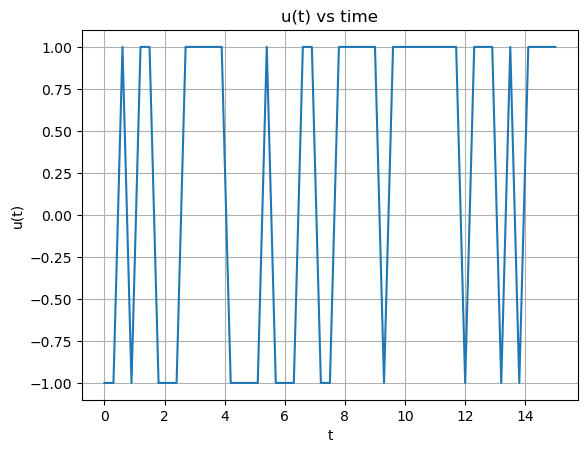

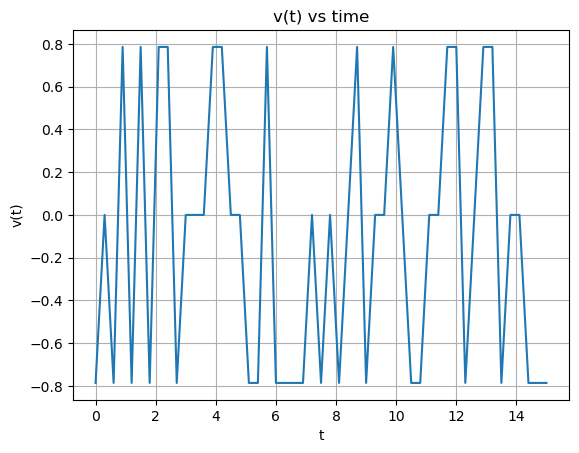

In [46]:
u=[2*(0.5-i%2) for i in u_t]
v=[(1-i//2)*np.pi/4 for i in u_t]

x = np.linspace(0, T, N+1)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, N+1)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


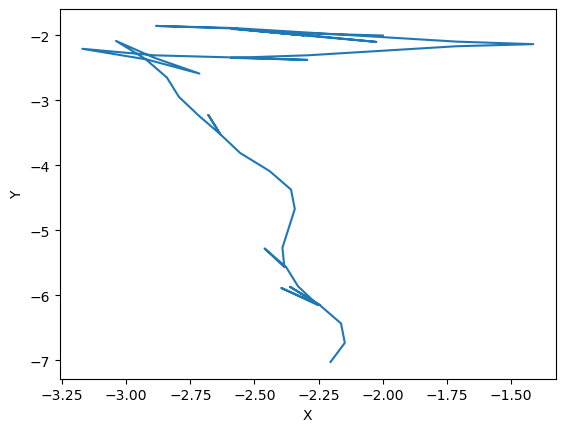

In [47]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

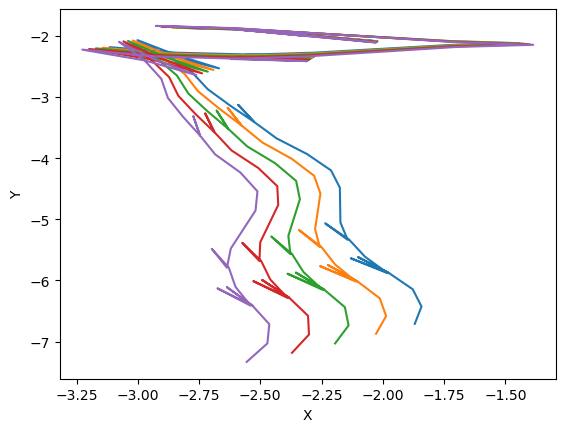

52.092968966251284


In [48]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))


## Best Trajectory

In [49]:
u=[2*(0.5-i%2) for i in best_u]
v=[(1-i//2)*np.pi/4 for i in best_u]

x = np.linspace(0, T, N+1)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, N+1)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

NameError: name 'best_u' is not defined

In [ ]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

## Pure Exploitation Trajectory

In [ ]:
position=np.array([[-2,-2,0] for _ in range(num_system)])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(num_system)]

for time in range(N+1):           
    
    #print(candidates_u)
    u_k = decide_u_exploitation(gpr_list[time],flags[time],observation)
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''
    
u=[2*(0.5-i%2) for i in u_t]
v=[(1-i//2)*np.pi/4 for i in u_t]


x = np.linspace(0, T, N+1)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, N+1)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(position))